# PHYS805 Final Project Notebook

In [1]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import torch
import wandb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
import mplhep as hep
import pandas as pd
import random
import datetime
from pprint import pprint
plt.style.use(hep.style.CMS)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# auto reload of imported modules
%load_ext autoreload
%autoreload 2

from utils import data_utils
from utils import dataloader
from utils import metric
from utils import model
from utils import training

%config InlineBackend.figure_format = 'retina'

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-pac

cuda


In [2]:
# Data config stuff
with open("datasets.yaml", "r") as f:
    ds_cfg = yaml.safe_load(f)

features = [
    "Jet_pt",
    "Jet_eta",
    "Jet_phi",
    "Jet_mass",
    "Jet_nConstituents",
    "Jet_nSVs",
    "Jet_area",
]
other_branches = [
    "nJet",
    "Pileup_nPU",
]
branches = features + other_branches
num_ftrs = len(features)

test_split = 0.2
val_split = 0.5

In [ ]:
sig = data_utils.load_data(ds_cfg, "EMJ", filter_name=branches, entry_stop=-1)
bkg = data_utils.load_data(ds_cfg, "QCD", filter_name=branches, entry_stop=100_000)
bkg = data_utils.match_pu(sig, bkg)

In [4]:
nPU = torch.tensor(
    np.concatenate([
        ak.to_numpy(sig["Pileup_nPU"]),
        ak.to_numpy(bkg["Pileup_nPU"])
    ]),
    dtype=torch.float32
)

# njets = int(max(ak.max(sig["nJet"]), ak.max(bkg["nJet"])))
njets = 10
sig_tensor = data_utils.ak_to_torch(sig, features, njets, label=1)
bkg_tensor = data_utils.ak_to_torch(bkg, features, njets, label=0)
data_tensor = torch.cat([sig_tensor, bkg_tensor], dim=0)
rnd_idx = torch.randperm(data_tensor.size(0))
data_tensor = data_tensor[rnd_idx]
nPU = nPU[rnd_idx]

In [5]:
# Split
X_train, X_temp, y_train, y_temp = train_test_split(
    data_tensor[..., :-1],
    data_tensor[:, 0, -1],
    test_size=test_split,
    shuffle=True,
)

# test and val split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size= val_split
)

print(y_train.shape, y_val.shape, y_test.shape)
print(X_train.shape, X_val.shape, X_test.shape)

torch.Size([31468]) torch.Size([3934]) torch.Size([3934])
torch.Size([31468, 10, 7]) torch.Size([3934, 10, 7]) torch.Size([3934, 10, 7])


In [6]:
norm_constants = data_utils.compute_norm_constants(X_train)
train_ds = dataloader.JetDataset(X_train, norm_constants, y_train)
val_ds = dataloader.JetDataset(X_val, norm_constants, y_val)
test_ds = dataloader.JetDataset(X_test, norm_constants, y_test)

In [7]:
batch_size = 512
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [8]:
pprint(norm_constants)

{'area_max': 0.8974609375,
 'area_min': 0.0997314453125,
 'eta_max': 5.099609375,
 'eta_min': -5.1044921875,
 'mass_max': 448.5,
 'mass_min': -7.474422454833984e-05,
 'nconst_max': 106.0,
 'nconst_min': 1.0,
 'nsv_max': 10.0,
 'nsv_min': 0.0,
 'phi_max': 3.141592653589793,
 'phi_min': -3.141592653589793,
 'pt_max': 8.17582893371582,
 'pt_min': 2.70805025100708}


## Features Study

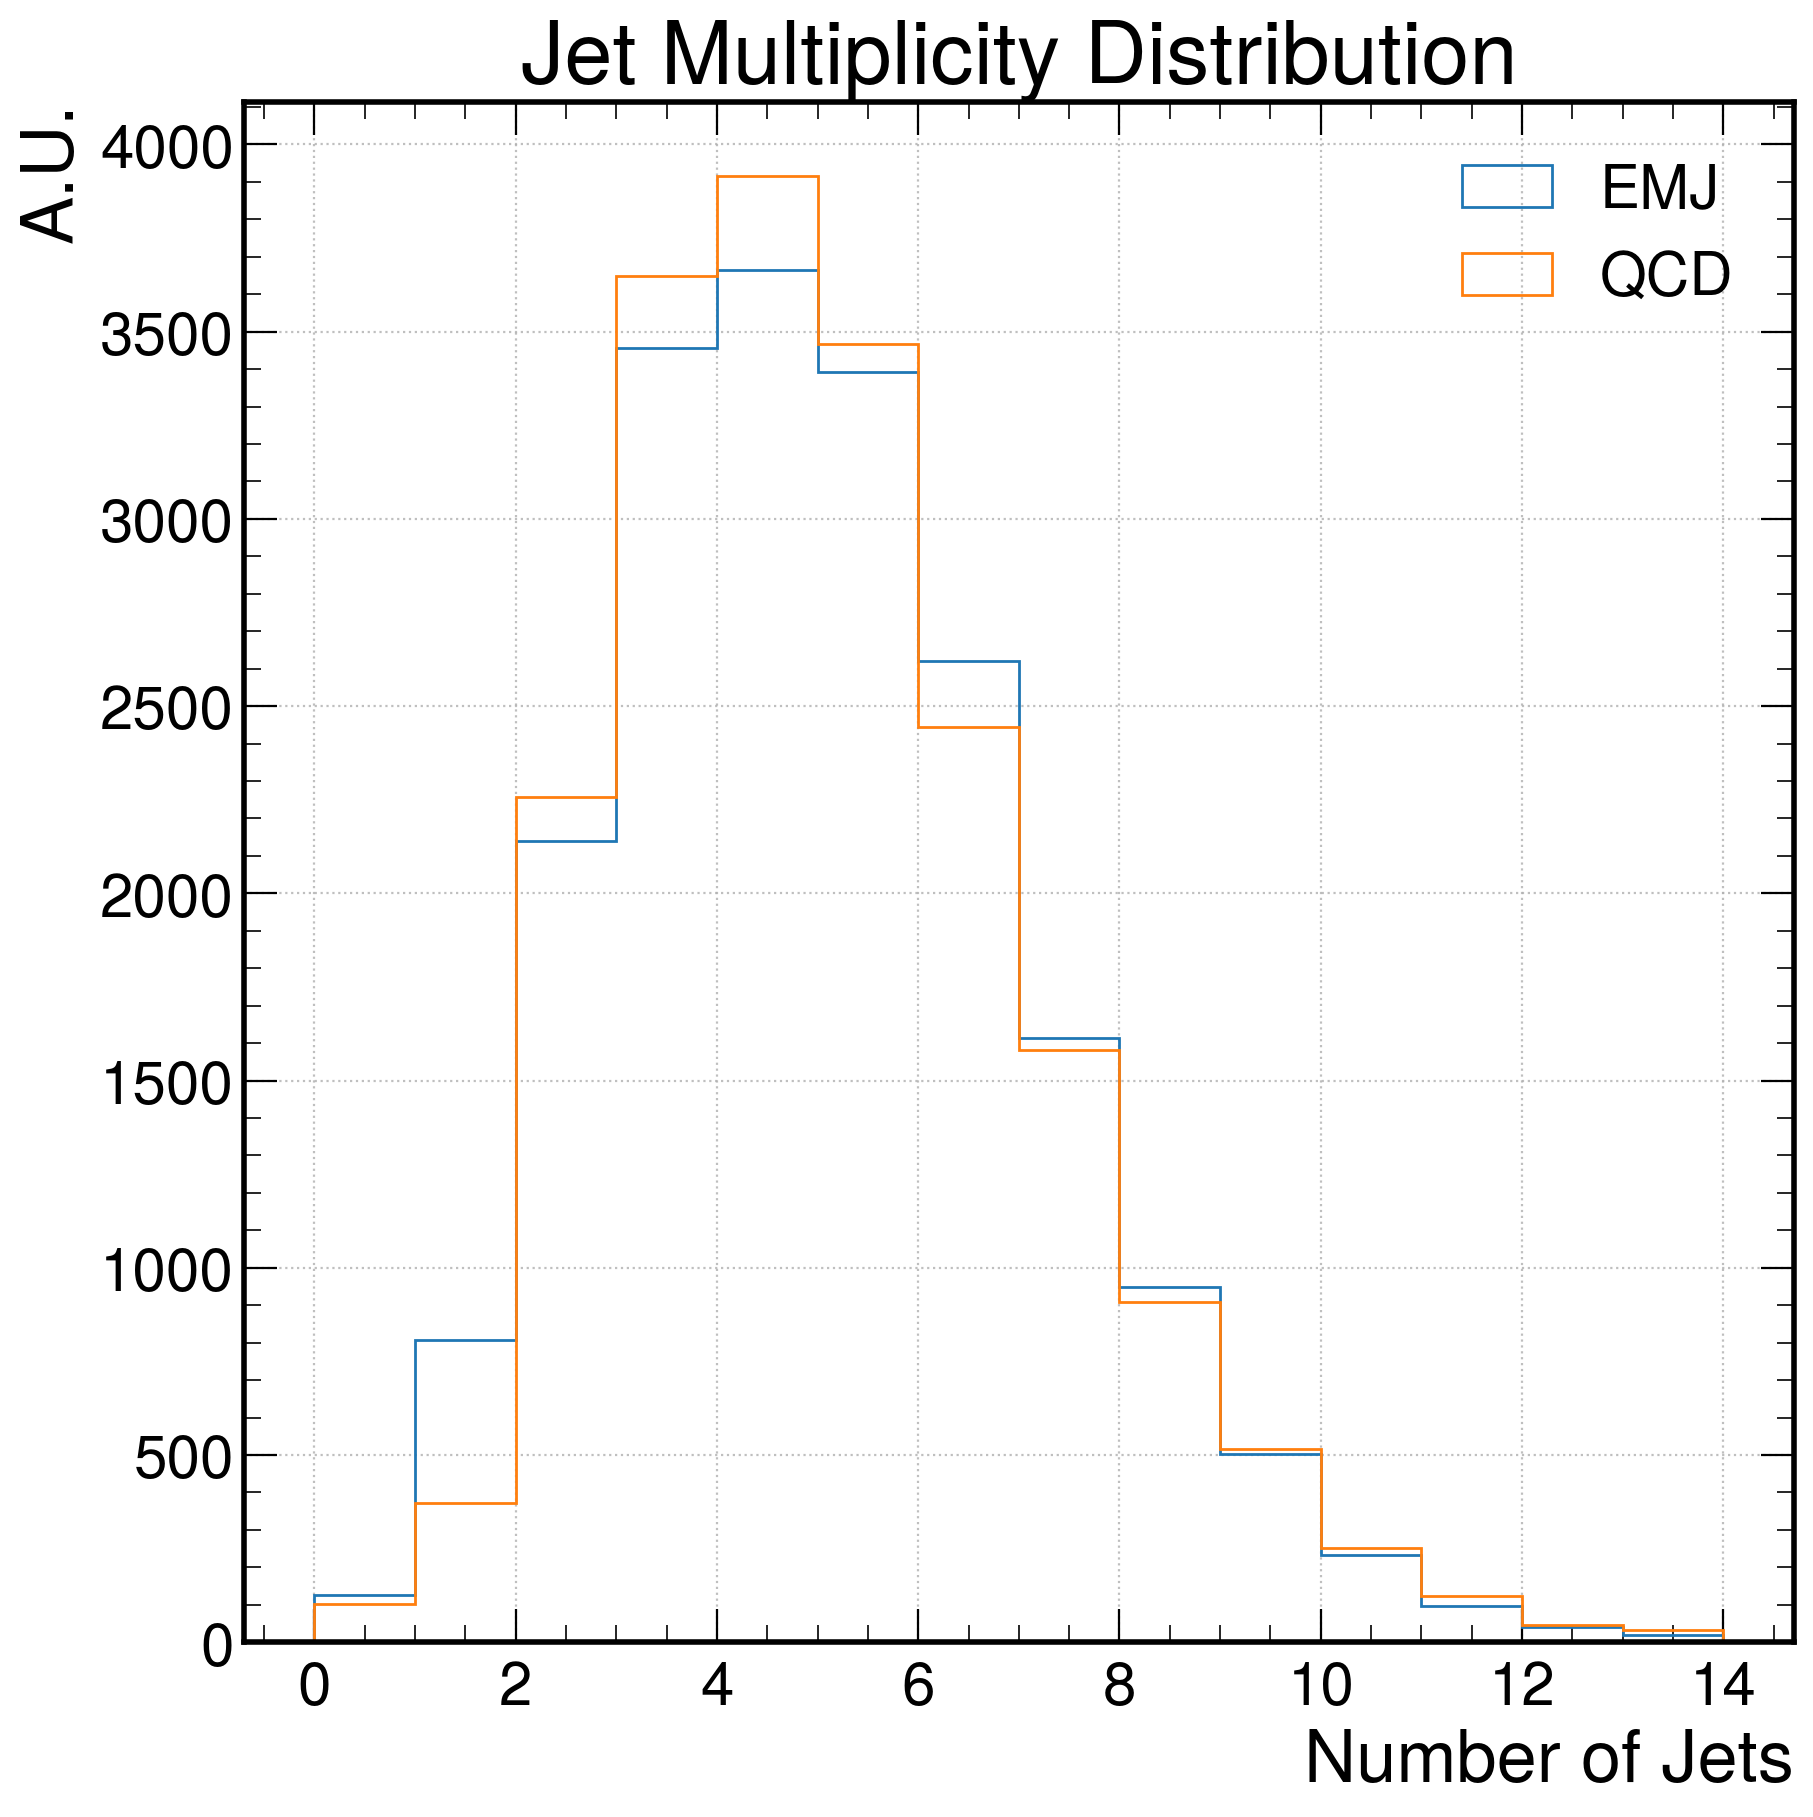

In [9]:
# Plot njets distribution
fig, ax = plt.subplots()
sig_njets = ak.to_numpy(sig['nJet'])
bkg_njets = ak.to_numpy(bkg['nJet'])
ax.hist(sig_njets, bins=np.arange(0, 15), density=False, label="EMJ", histtype="step")
ax.hist(bkg_njets, bins=np.arange(0, 15), density=False, label="QCD", histtype="step")
ax.set_xlabel("Number of Jets")
ax.set_ylabel("A.U.")
ax.set_title("Jet Multiplicity Distribution")
ax.legend()
ax.grid(True)
plt.show()

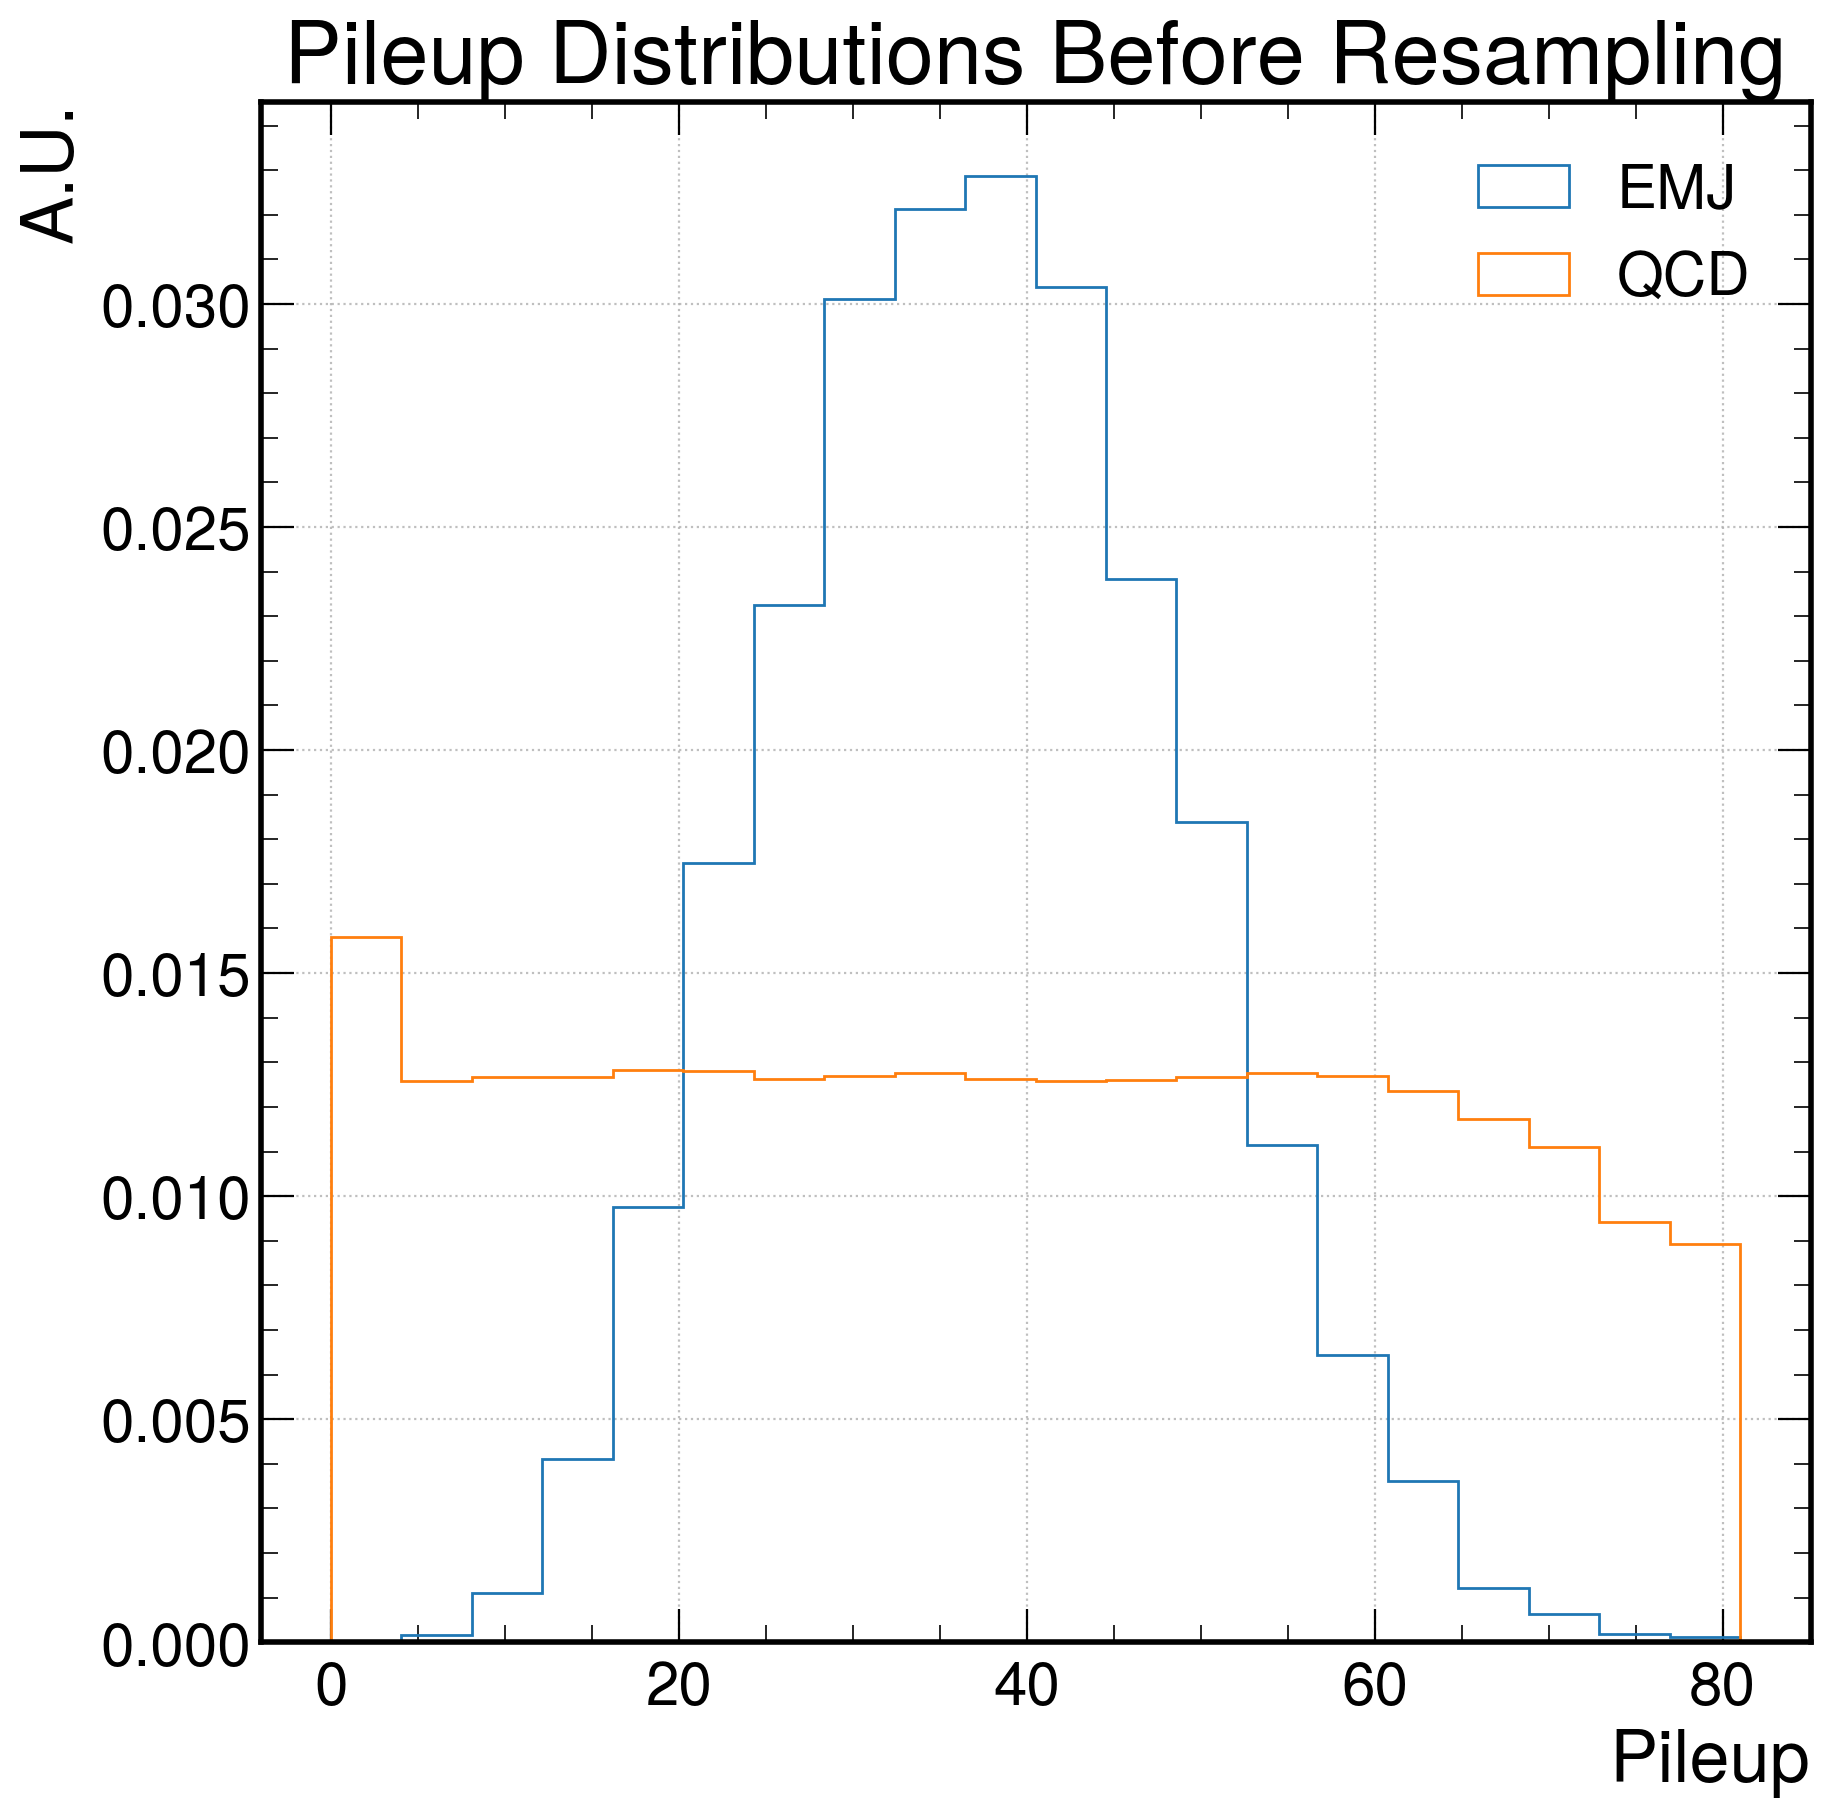

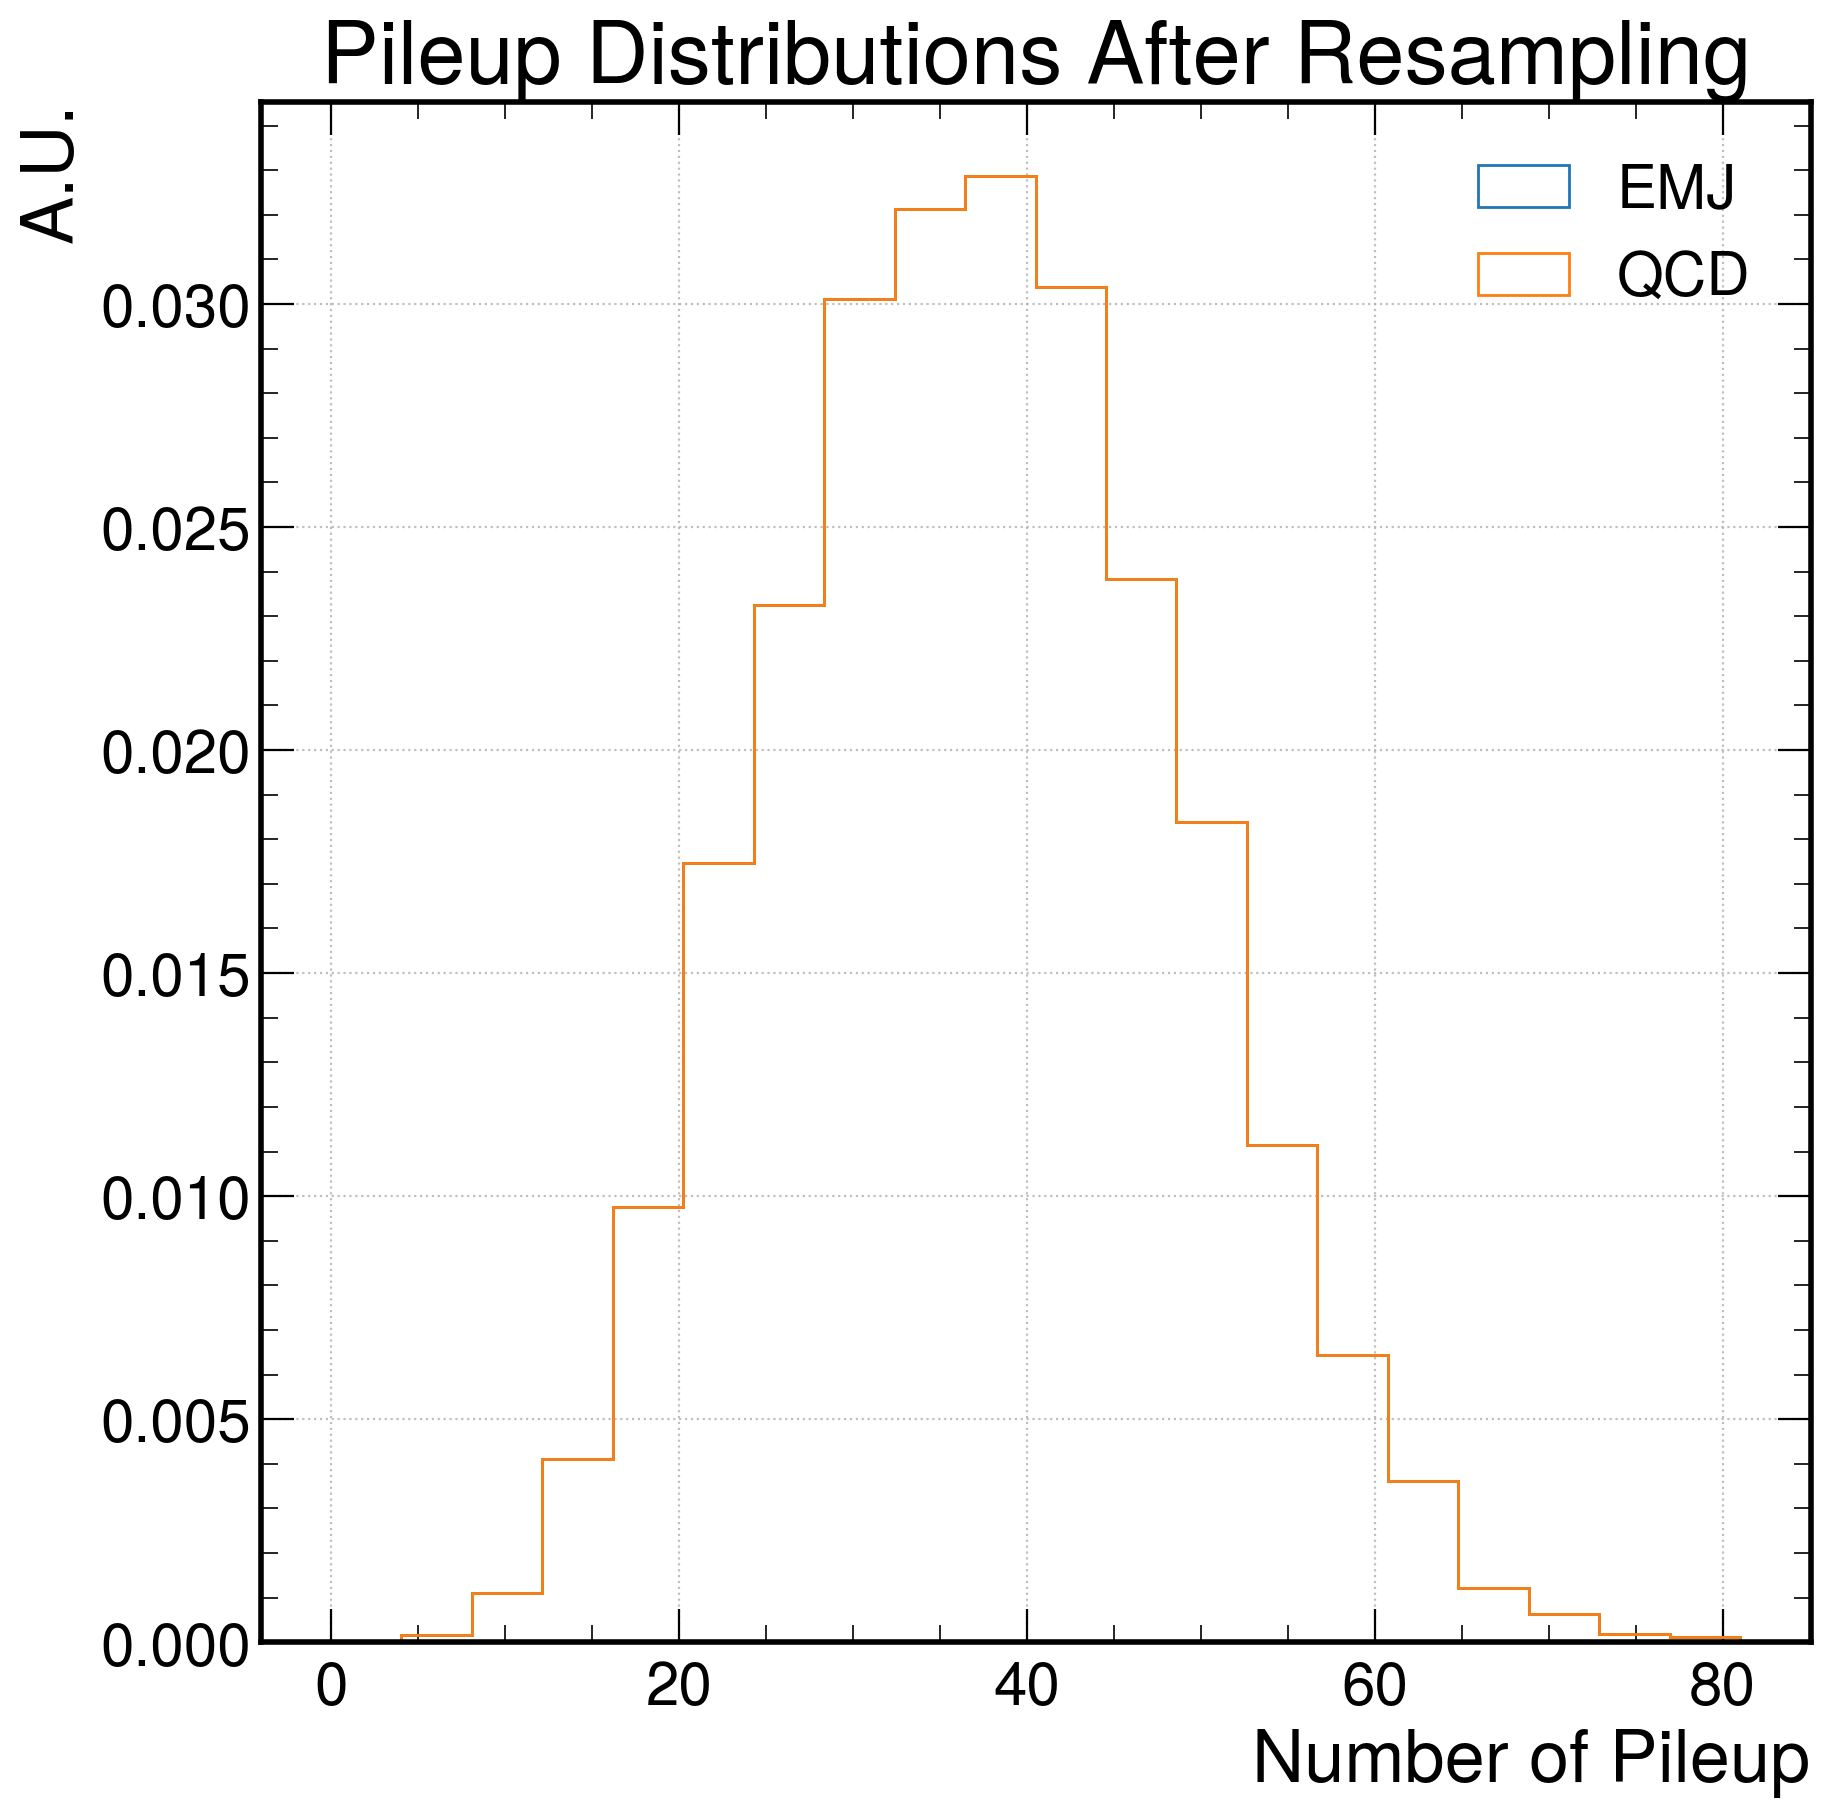

In [10]:
# Plot pileup distribution
bins = 20
x_min = 0
x_max = nPU.max().item() + 1

# Plotting PU before resampling
sig_pu = data_utils.load_data(ds_cfg, "EMJ", filter_name="Pileup_nPU", entry_stop=-1)["Pileup_nPU"].to_numpy()
bkg_pu = data_utils.load_data(ds_cfg, "QCD", filter_name="Pileup_nPU", entry_stop=-1)["Pileup_nPU"].to_numpy()

fig, ax = plt.subplots()
ax.hist(sig_pu, bins=bins, range=(x_min, x_max), label="EMJ", histtype="step", density=True)
ax.hist(bkg_pu, bins=bins, range=(x_min, x_max), label="QCD", histtype="step", density=True)
ax.set_xlabel("Pileup")
ax.set_ylabel("A.U.")
ax.set_title("Pileup Distributions Before Resampling")
ax.grid(True)
ax.legend()
plt.show()
del(bkg_pu, sig_pu)

# After resampling
fig, ax = plt.subplots()
ax.hist(ak.to_numpy(sig["Pileup_nPU"]), bins=bins, range=(x_min, x_max), density=True, label="EMJ", histtype="step")
ax.hist(ak.to_numpy(bkg["Pileup_nPU"]), bins=bins, range=(x_min, x_max), density=True, label="QCD", histtype="step")
ax.set_xlabel("Number of Pileup")
ax.set_title("Pileup Distributions After Resampling")
ax.set_ylabel("A.U.")
ax.legend()
ax.grid(True)
plt.show()

In [11]:
# Plot pt distrib using awkward arrays
# Plot njets distribution
sig_njets = ak.to_numpy(sig['nJet'])
bkg_njets = ak.to_numpy(bkg['nJet'])
sig_jets = sig[sig_njets < njets]
bkg_jets = bkg[bkg_njets < njets]

def plot_ftrs(sig, bkg, ftr_name, fig_title, nbins, xrange, xlabel, ylabel, log, normalized=True):
    sig_ftr = sig[ftr_name]
    bkg_ftr = bkg[ftr_name]
    
    fig, ax = plt.subplots()
    ax.hist(ak.flatten(sig_ftr), bins=nbins, range=xrange, density=normalized, alpha=0.5, label='EMJ', histtype='step', linewidth=1.5)
    ax.hist(ak.flatten(bkg_ftr), bins=nbins, range=xrange, density=normalized, alpha=0.5, label='QCD', histtype='step', linewidth=1.5)
    ax.set_title(fig_title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yscale('log' if log else 'linear')
    ax.legend()
    ax.grid(True)
    plt.show()

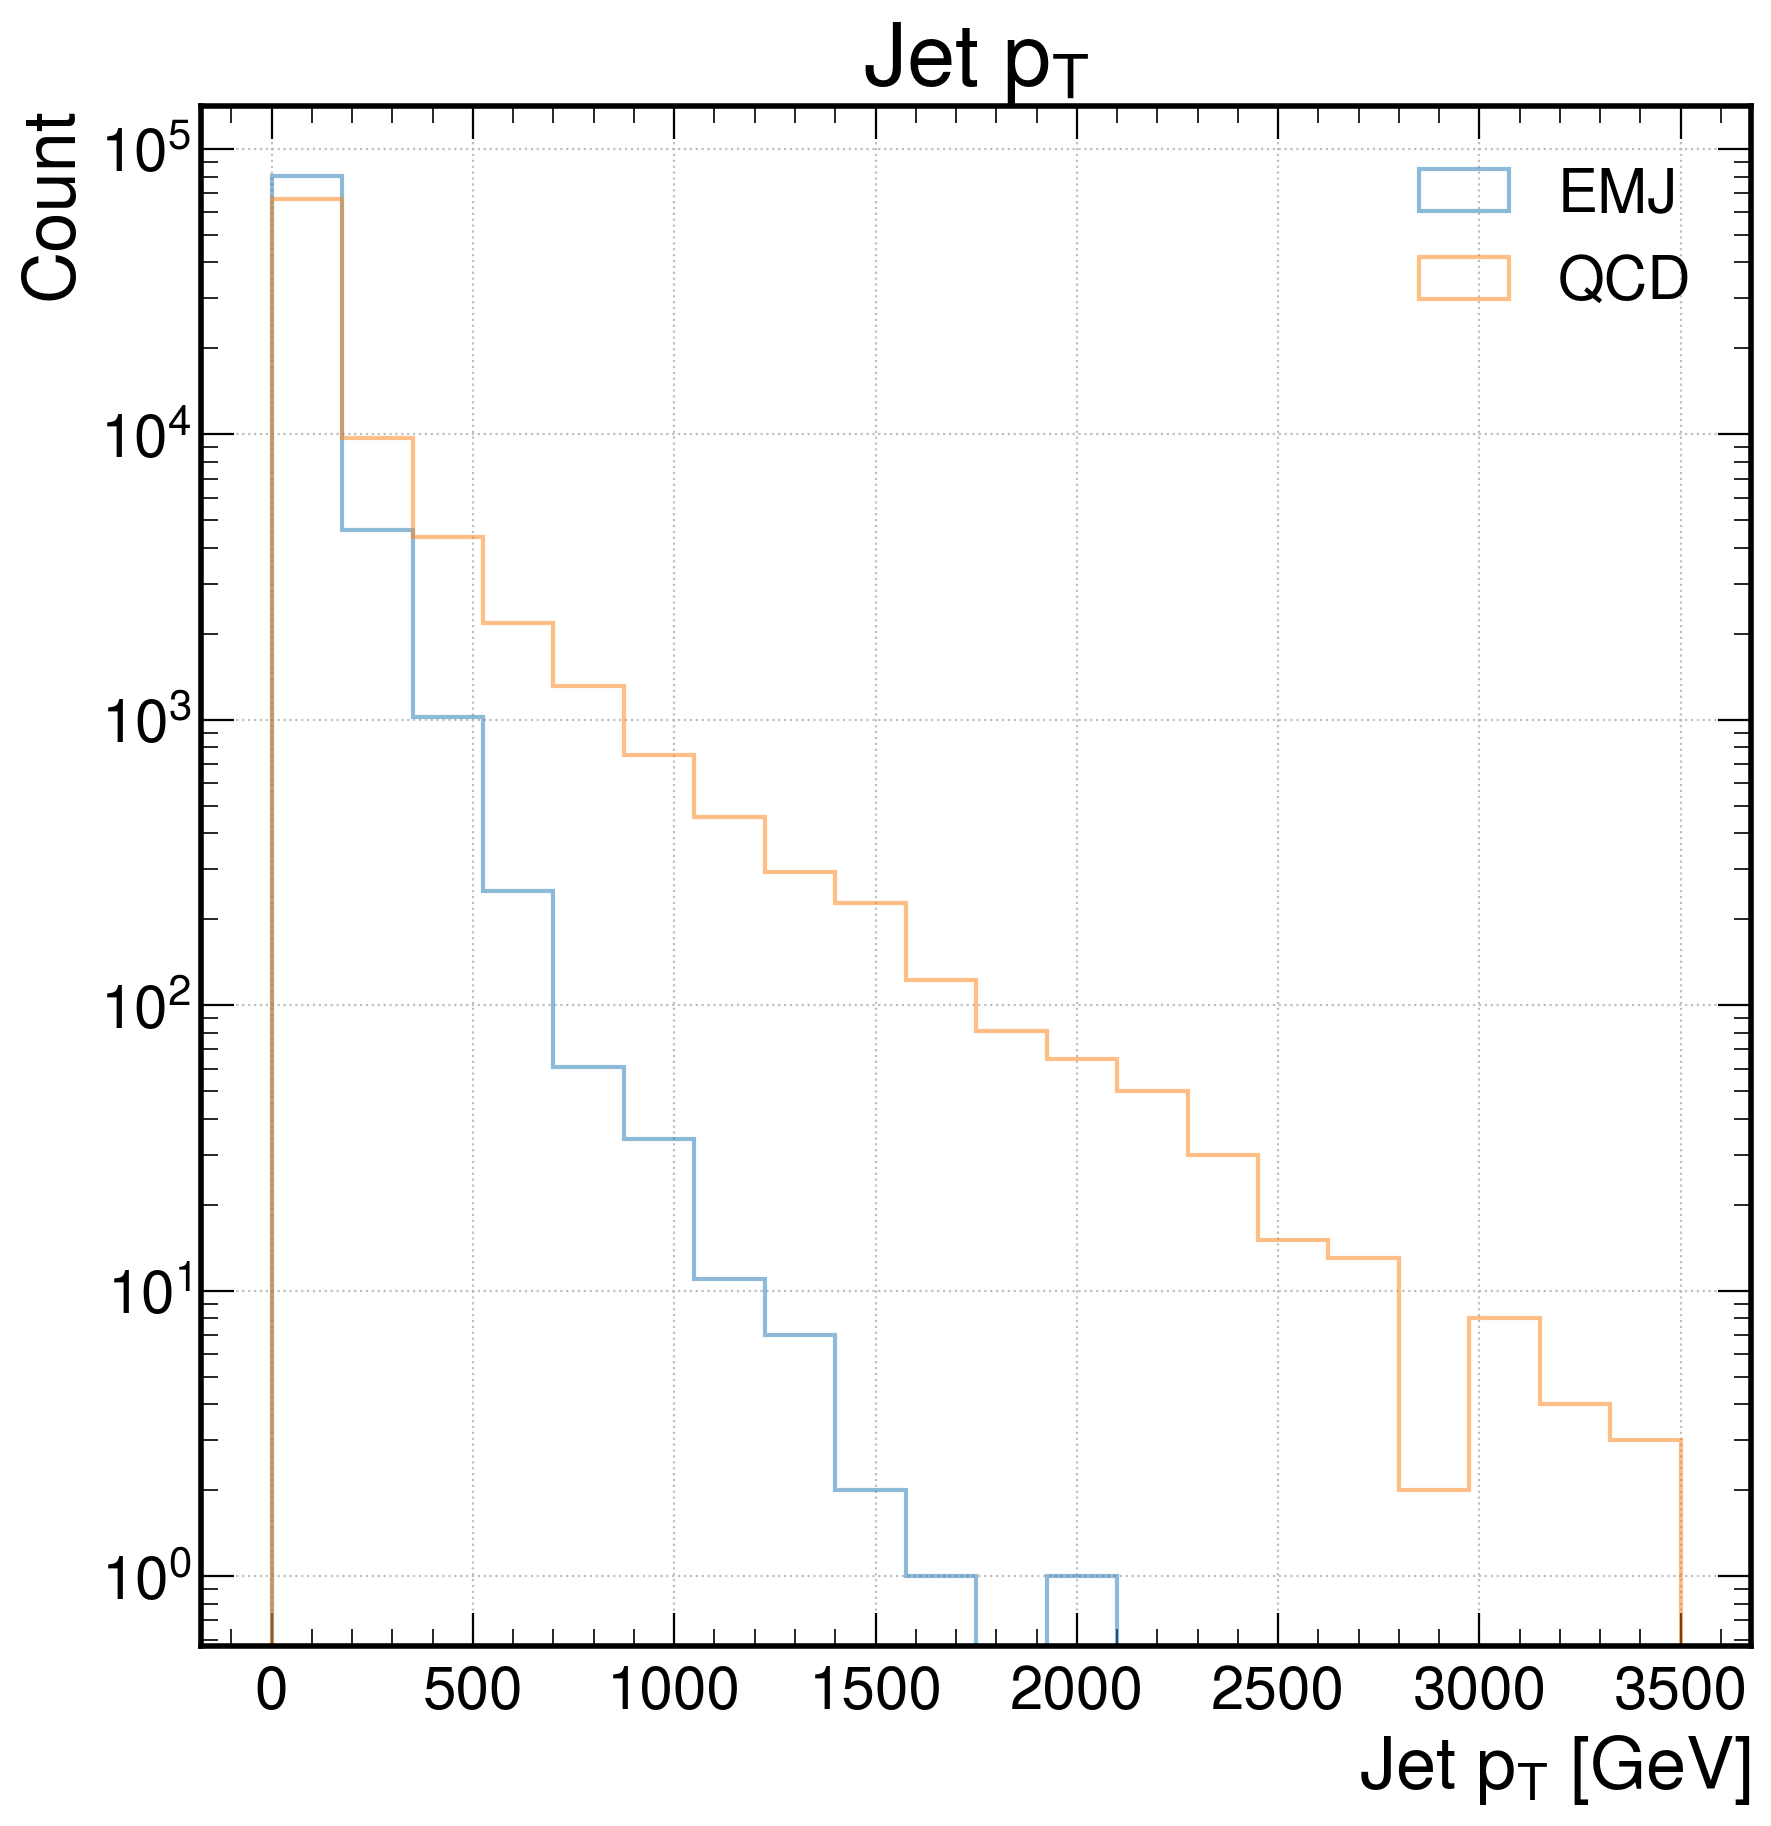

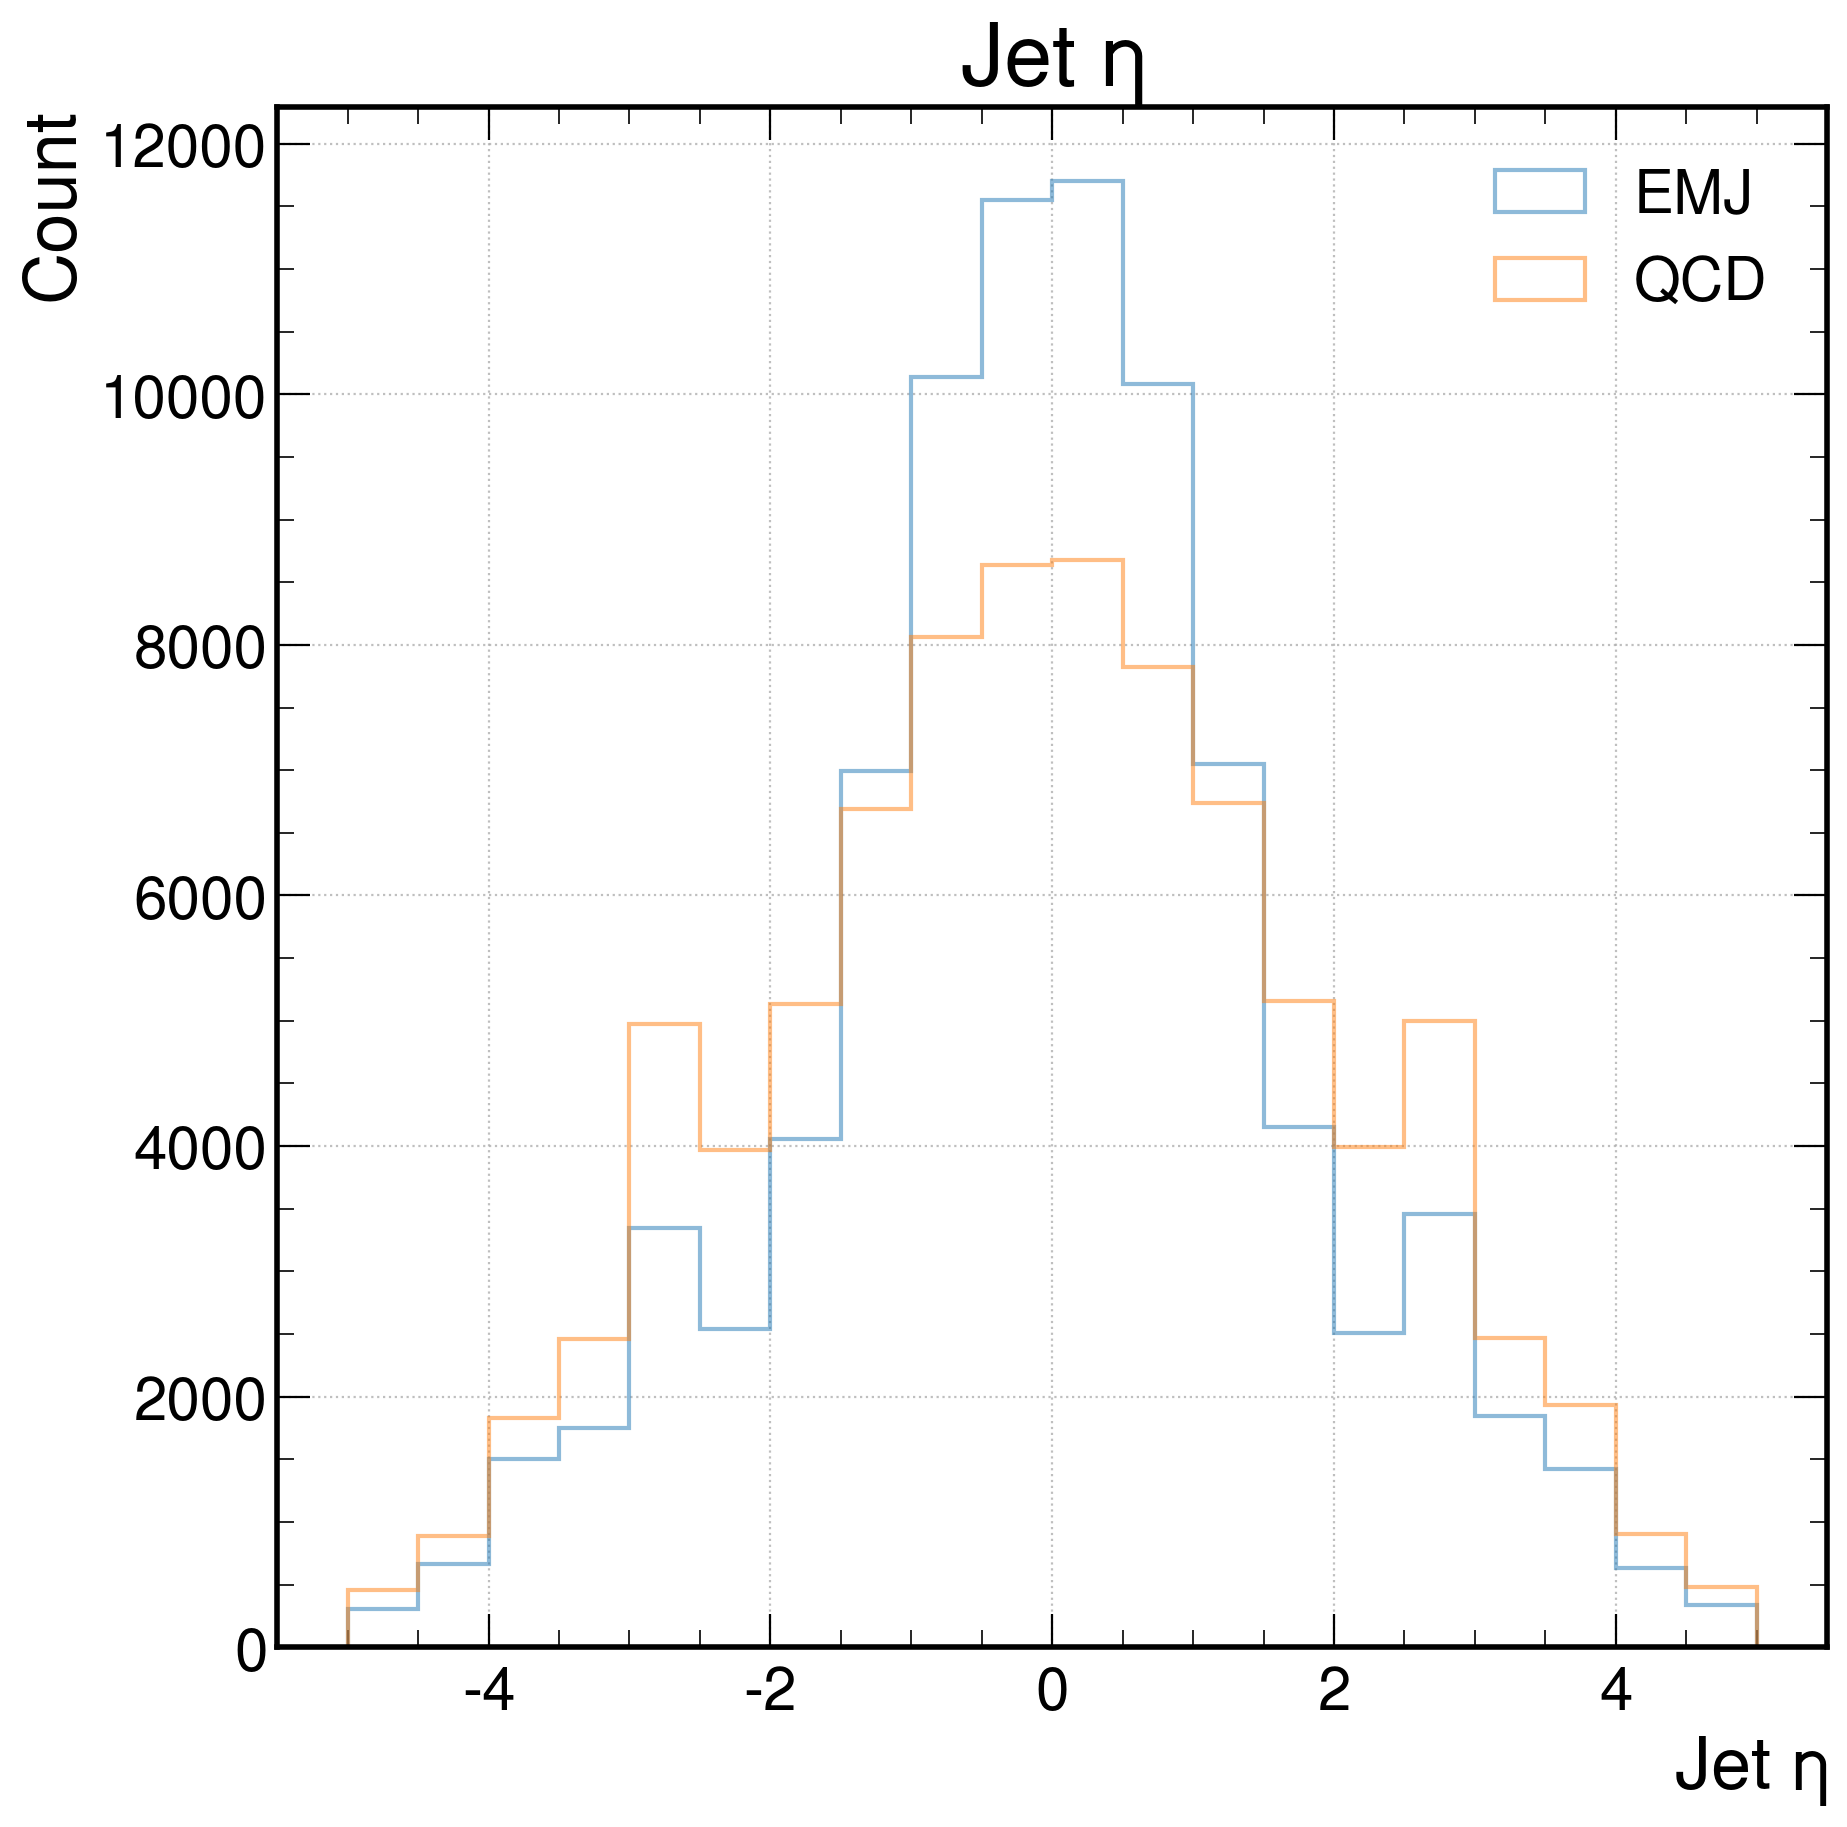

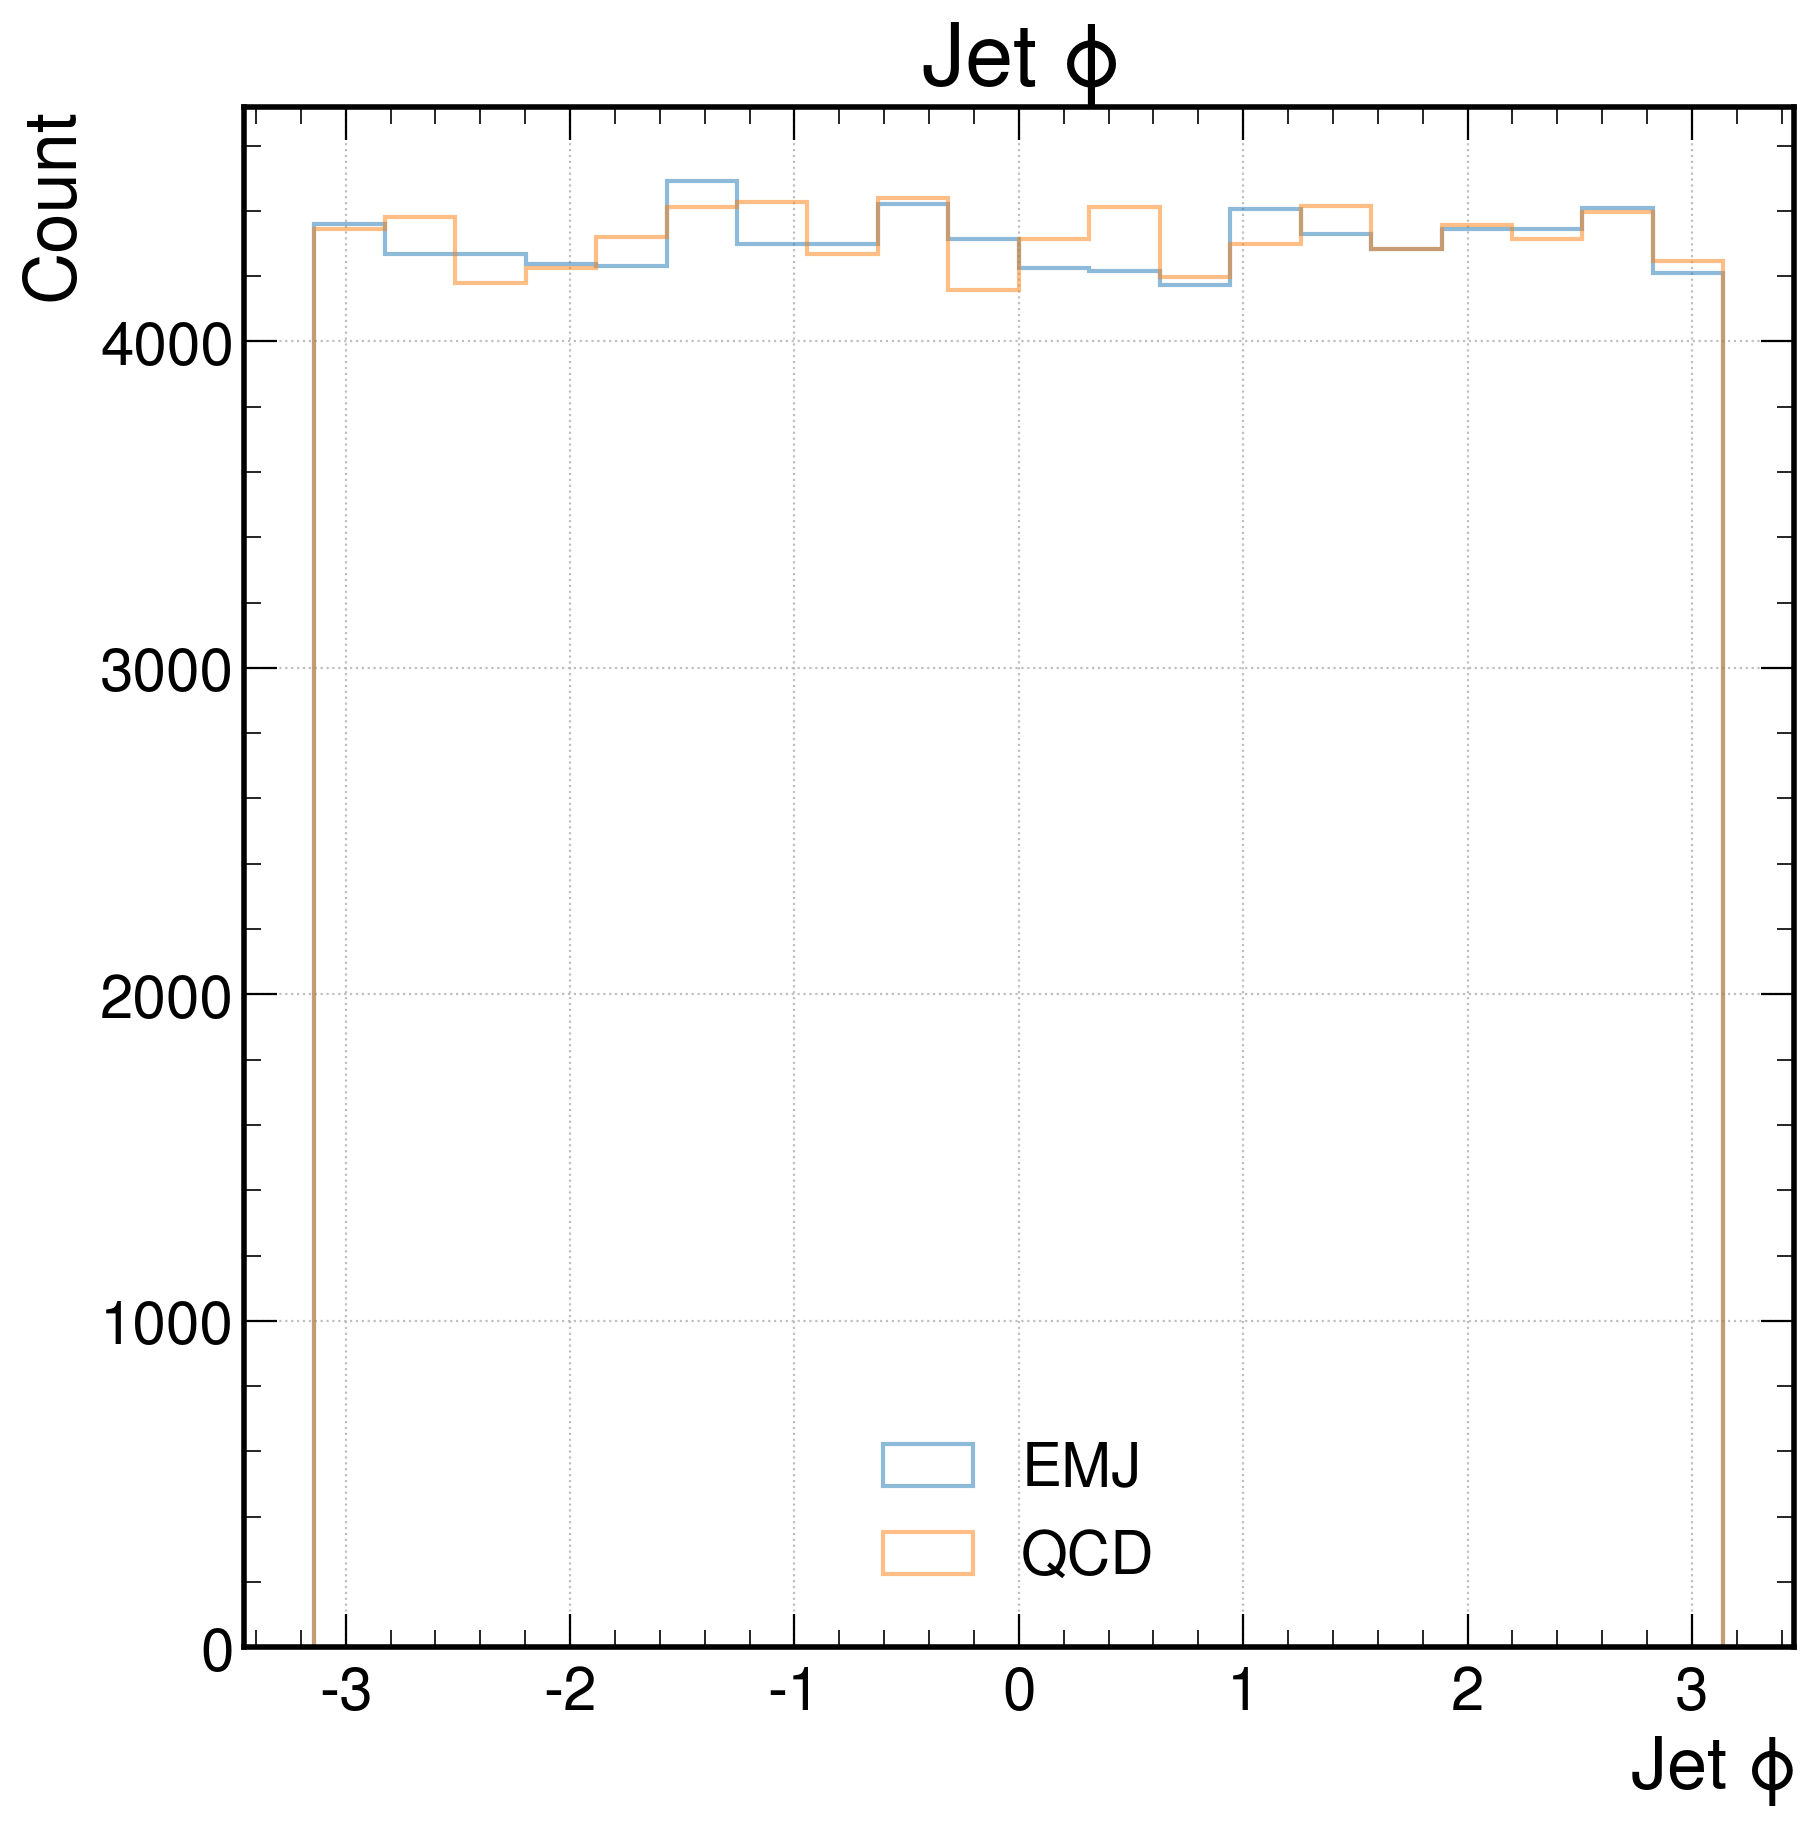

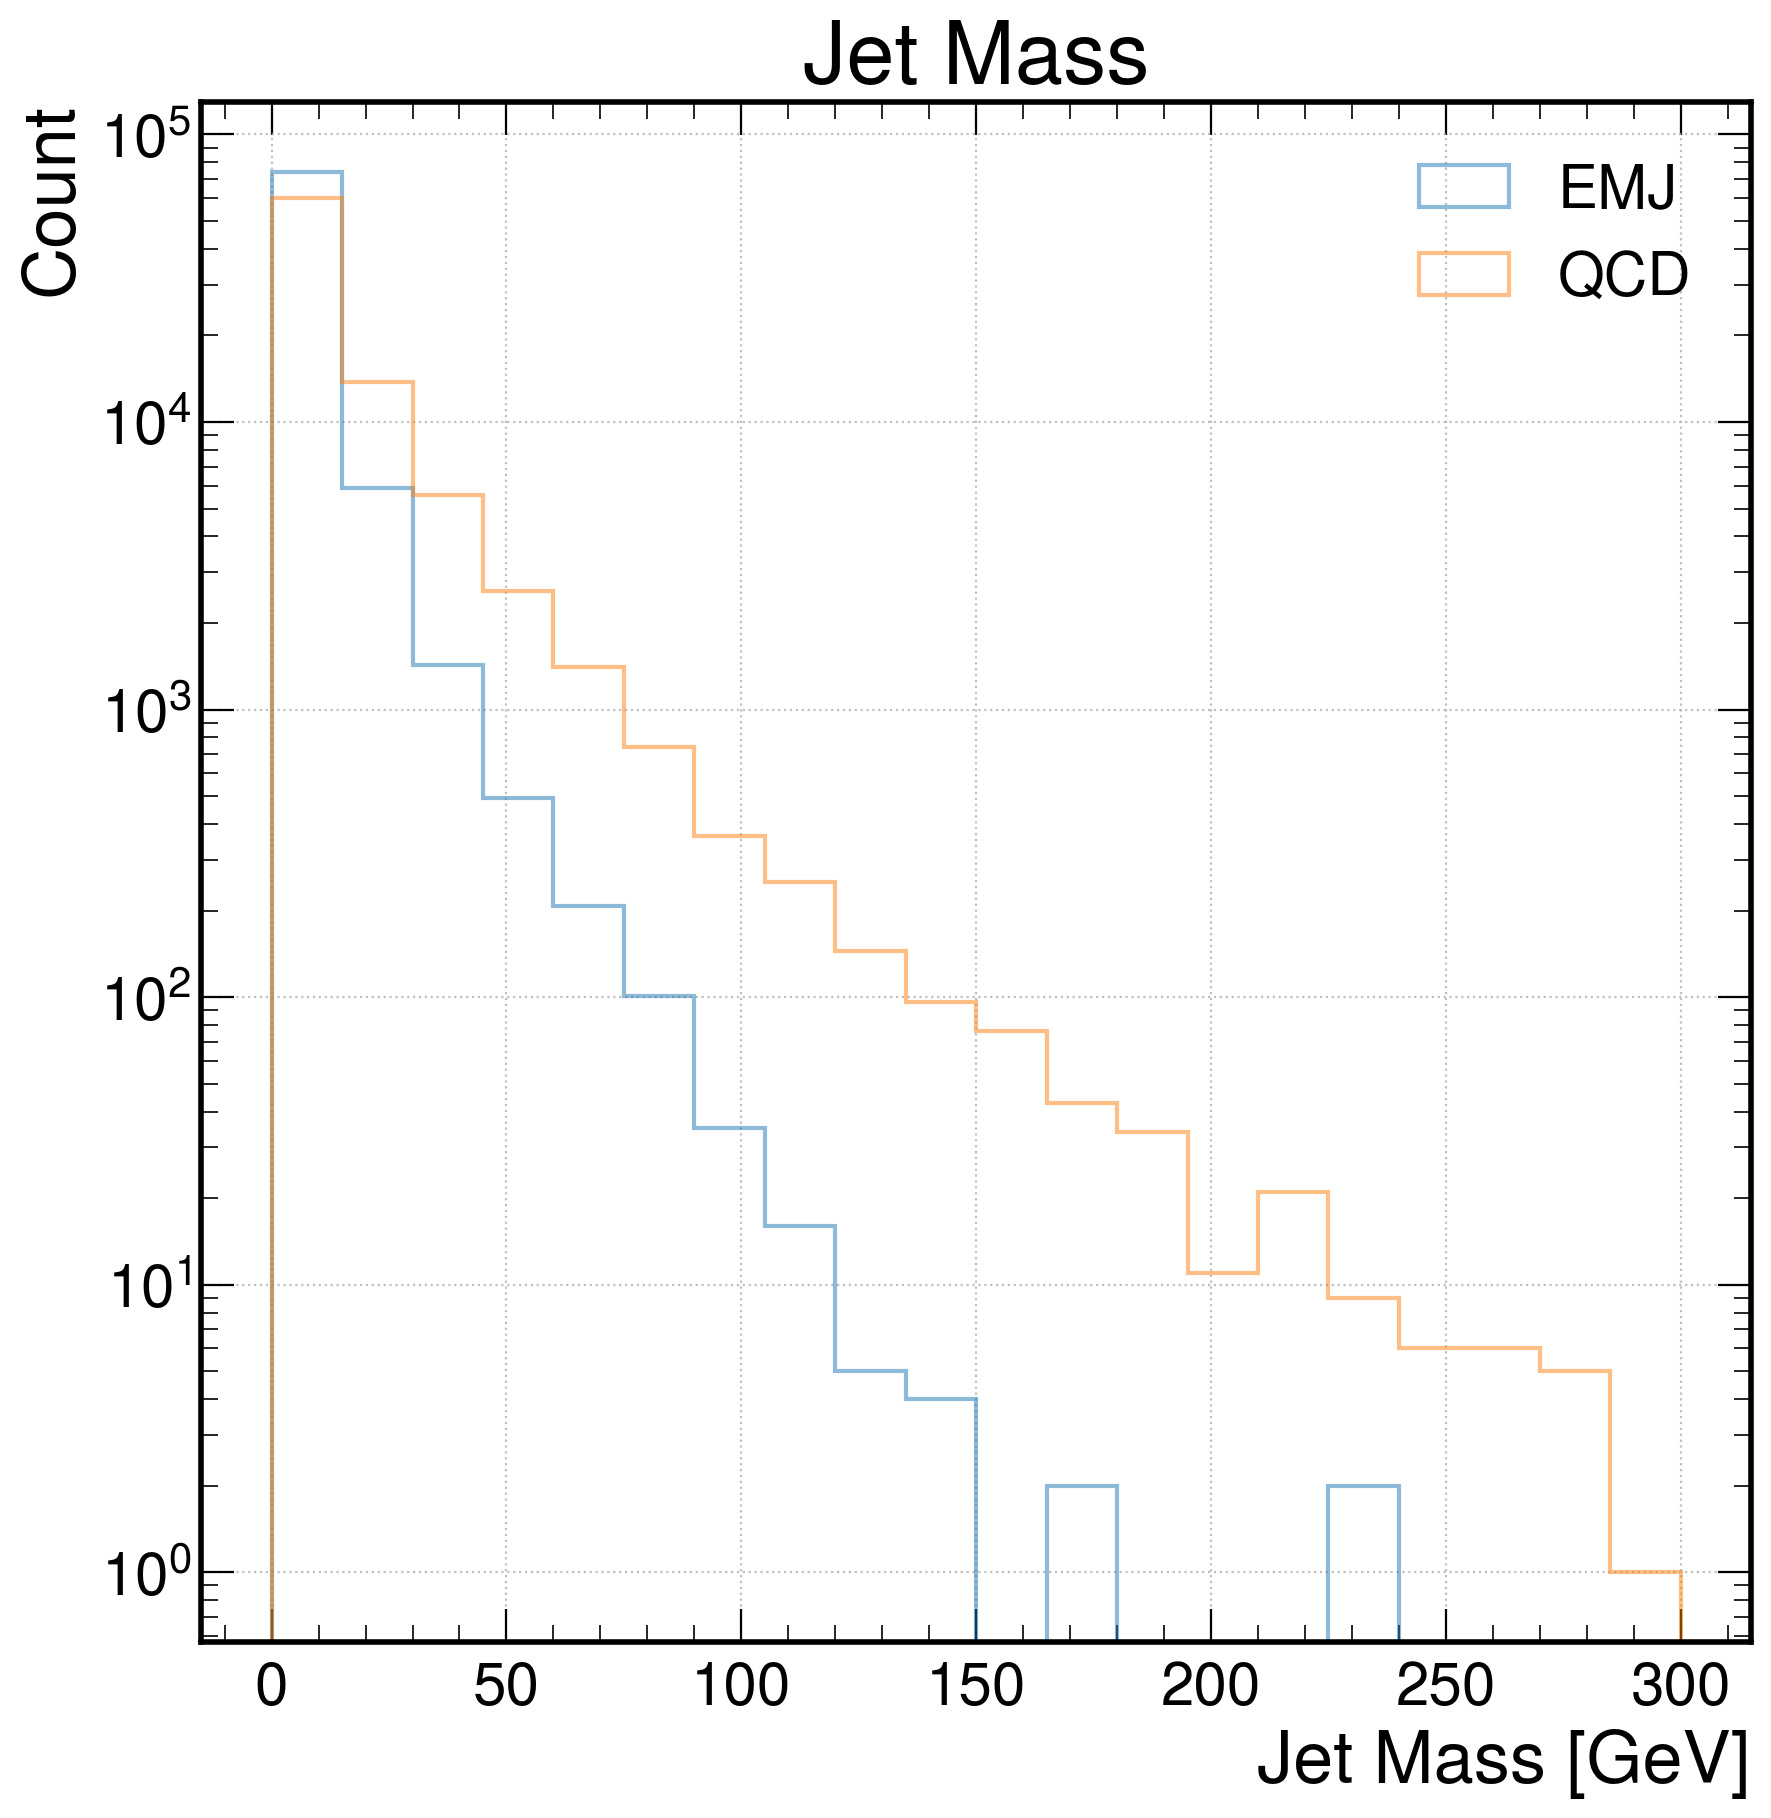

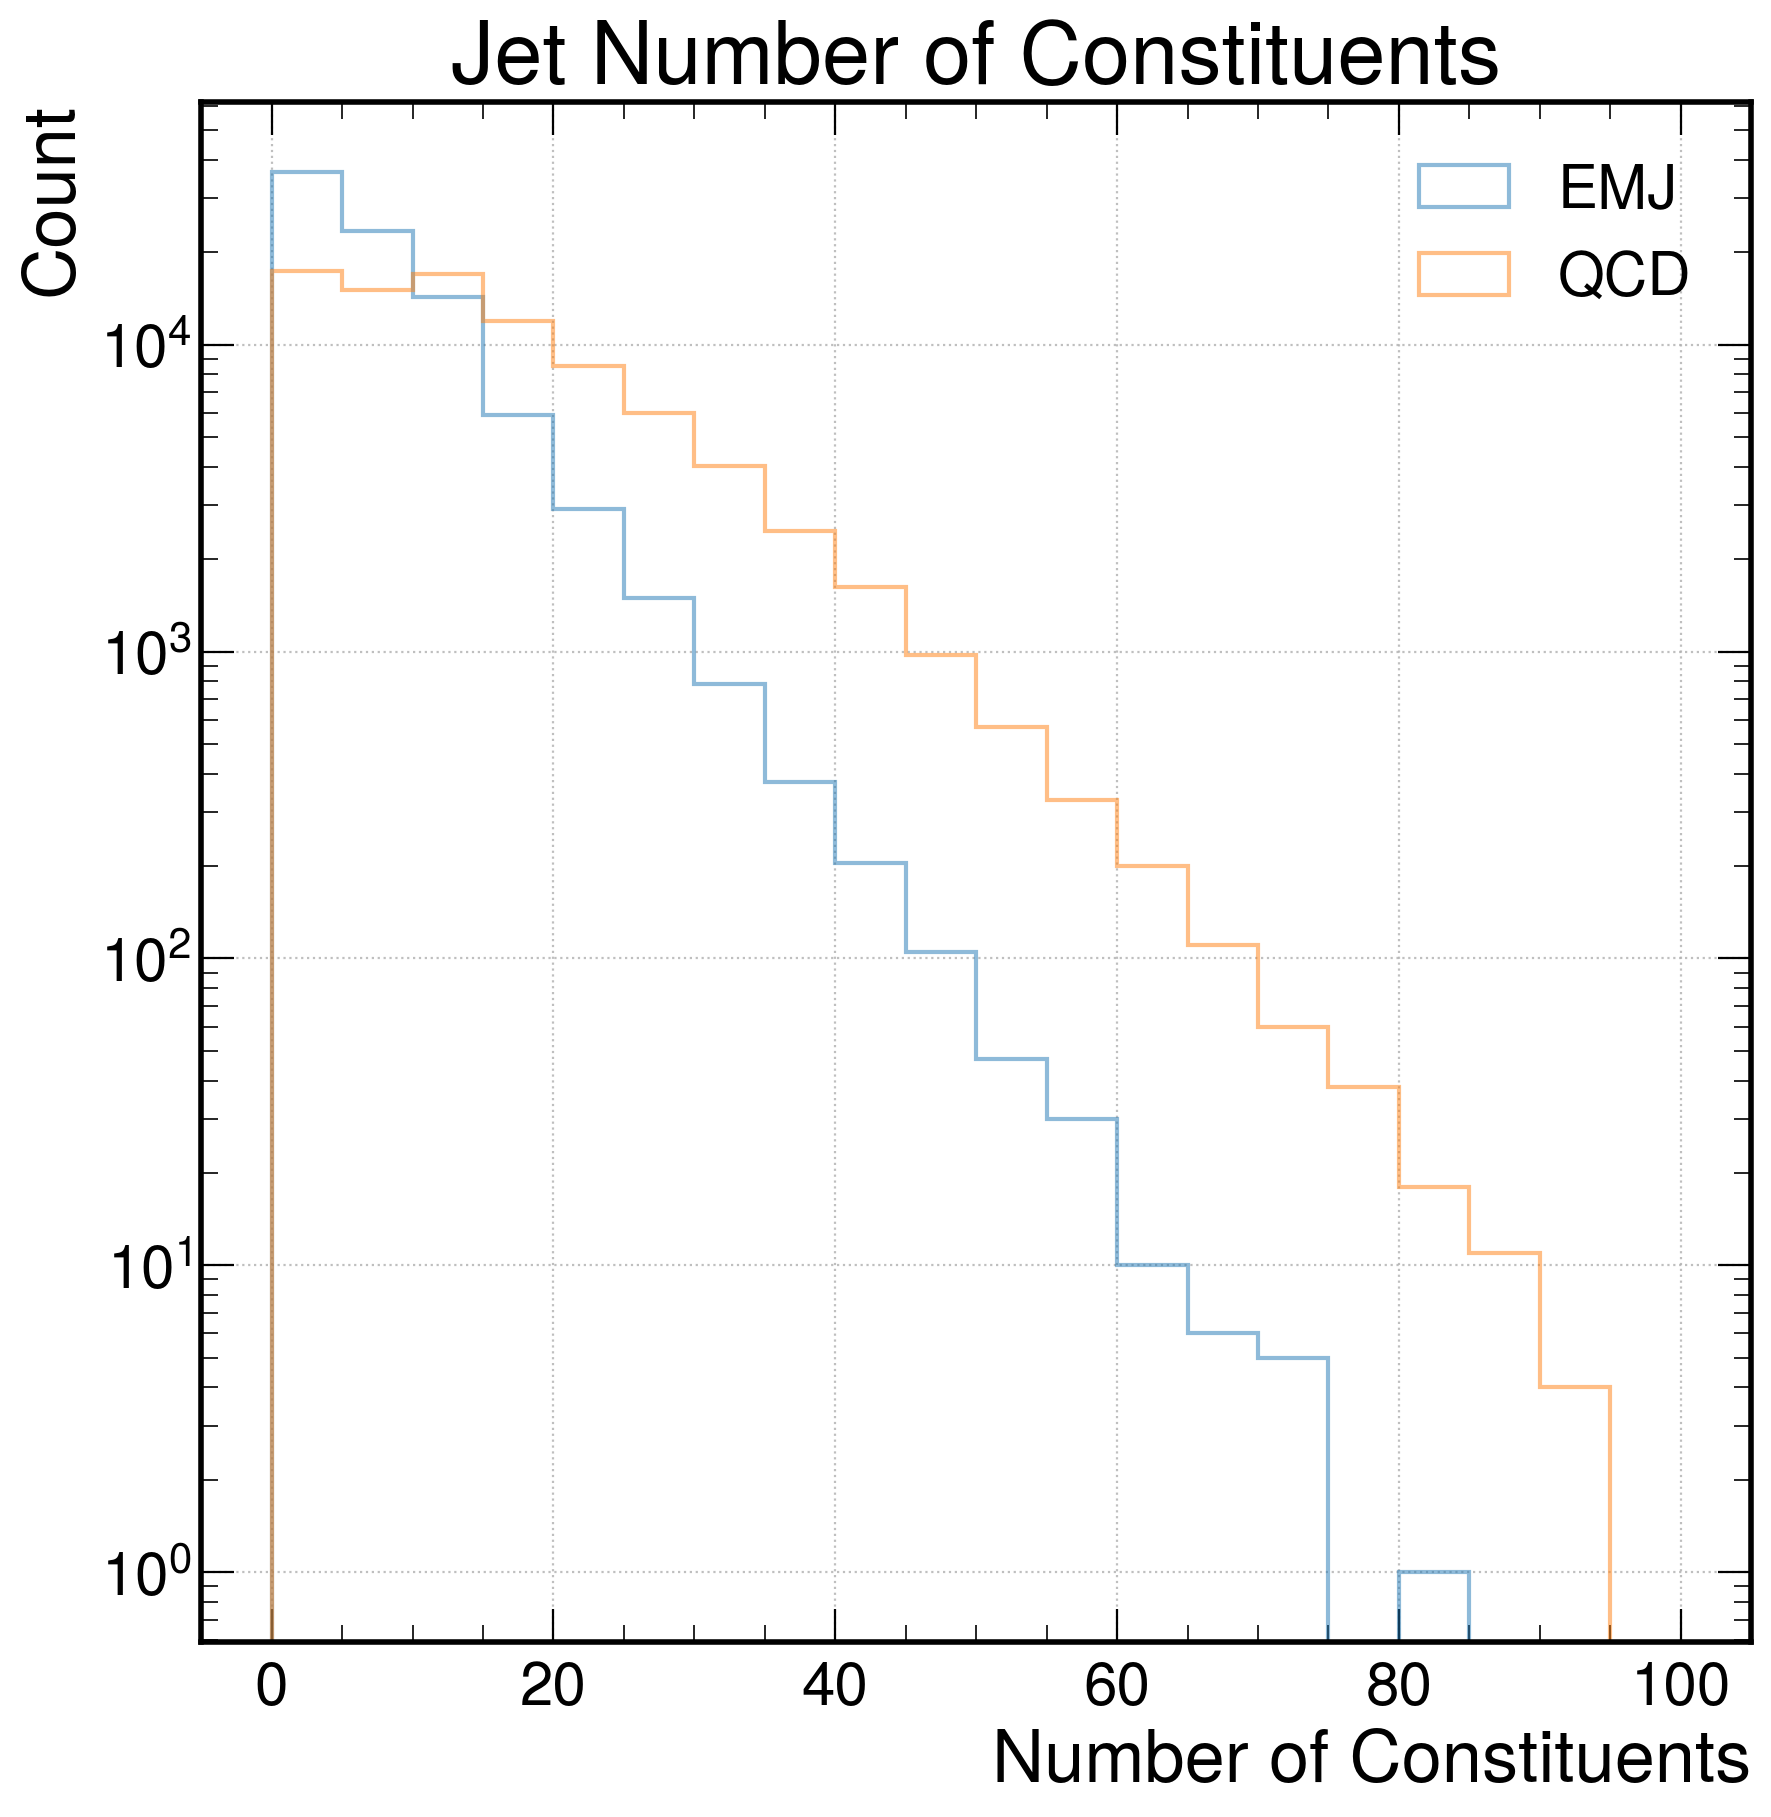

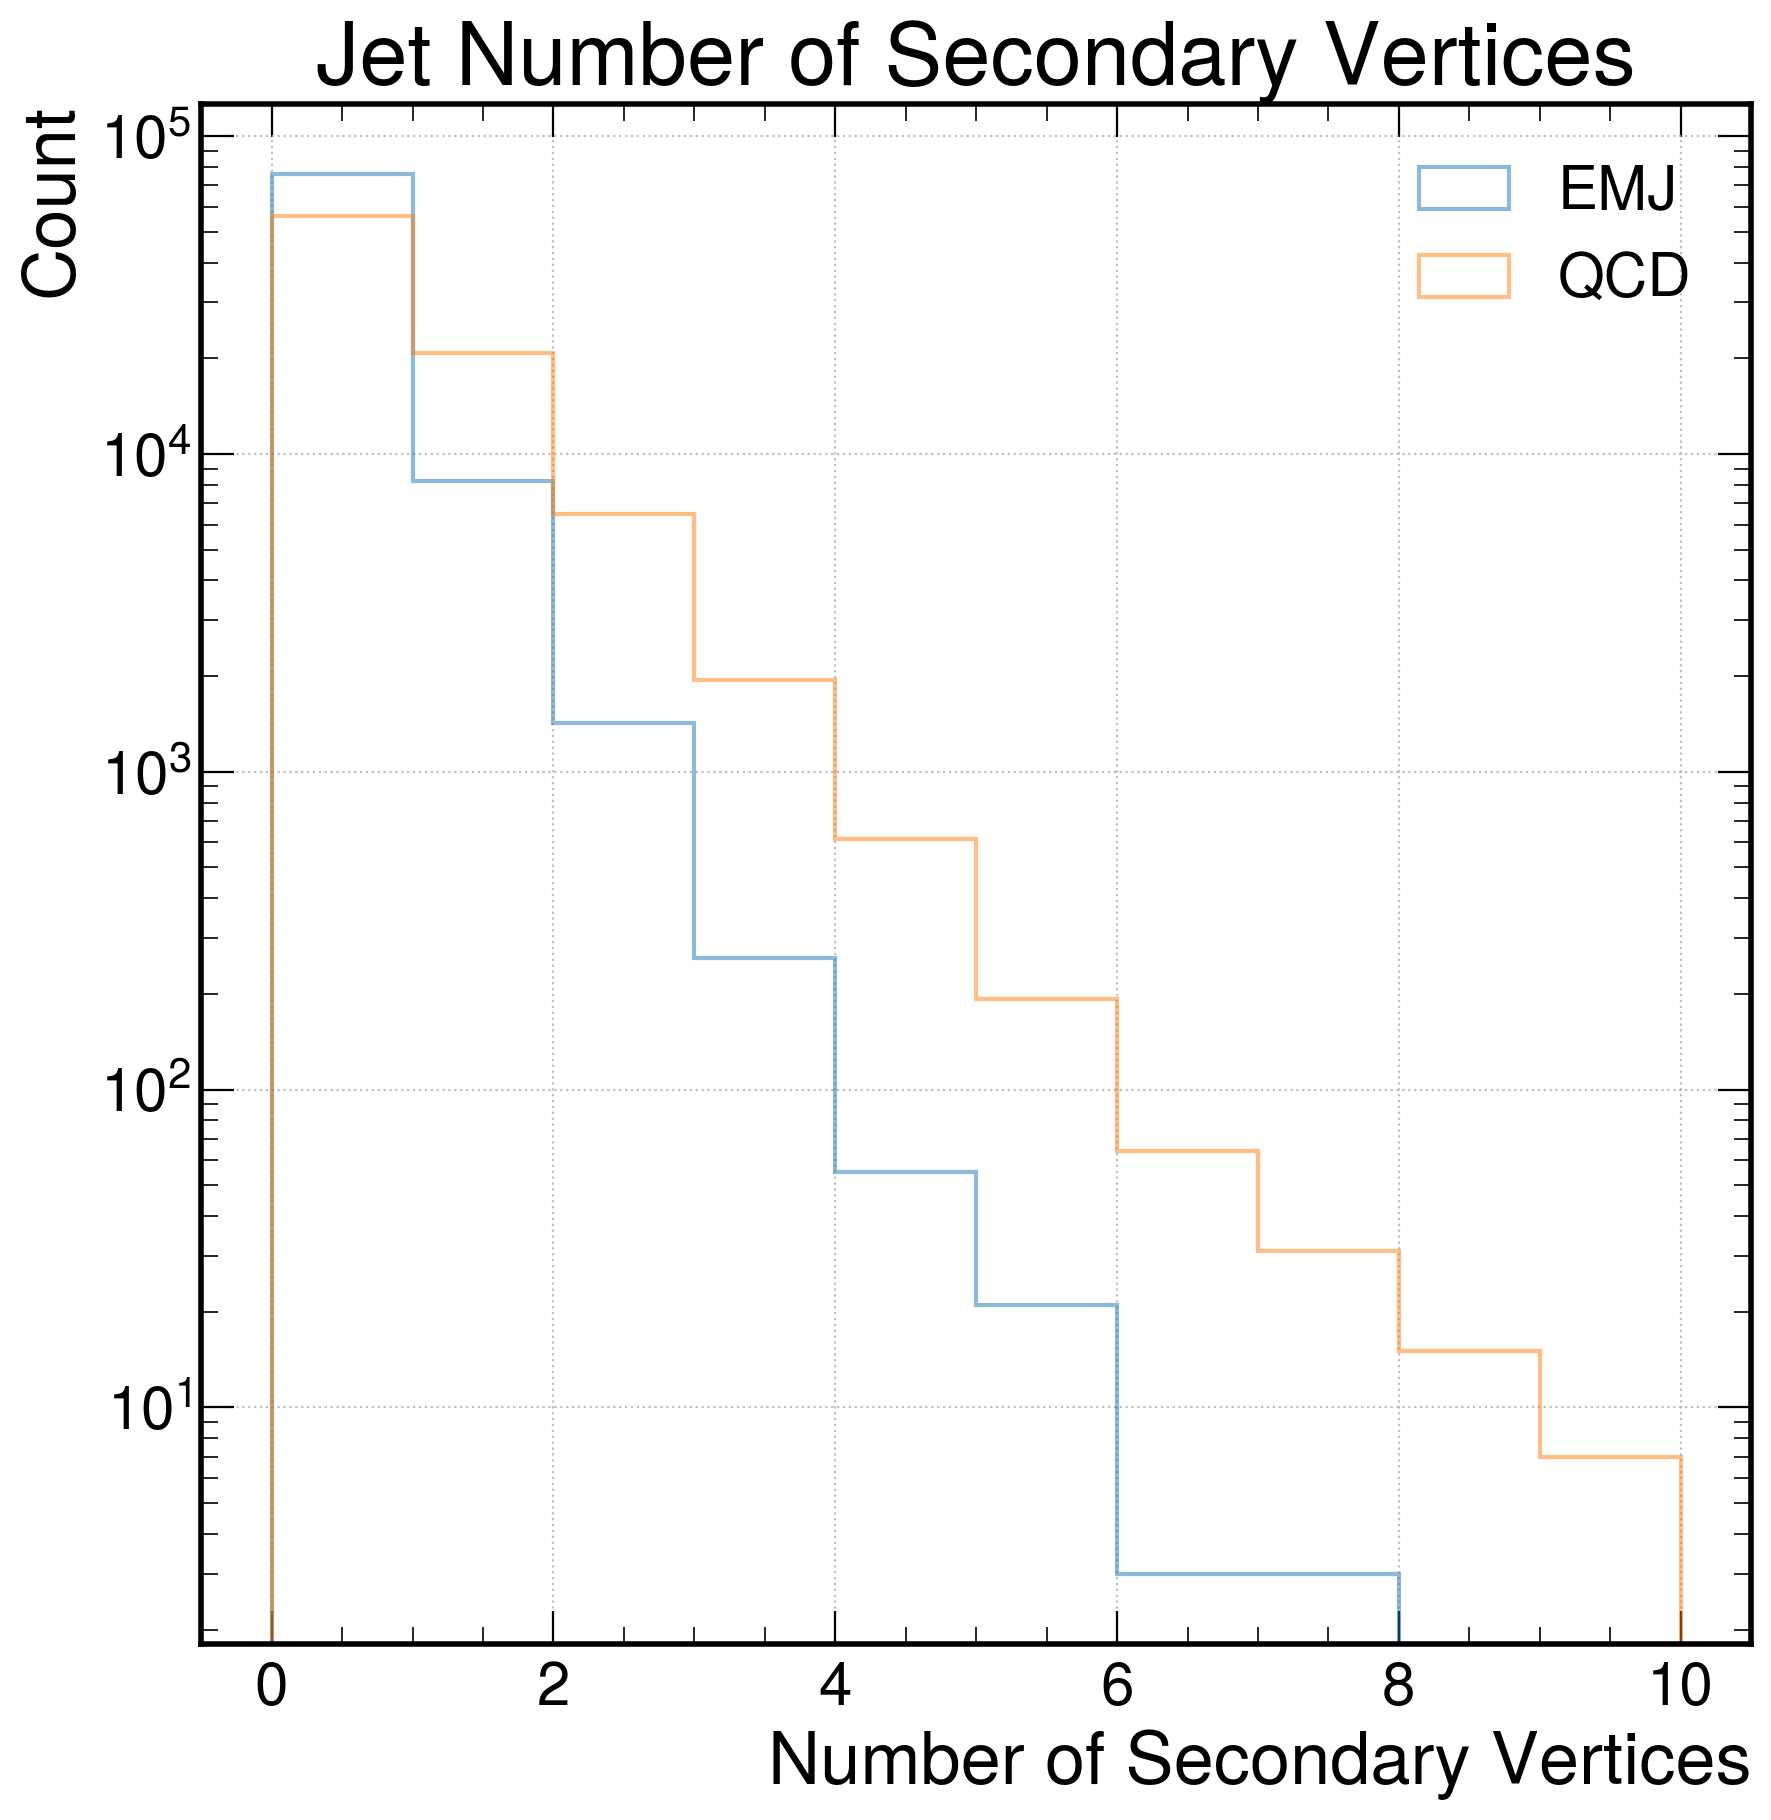

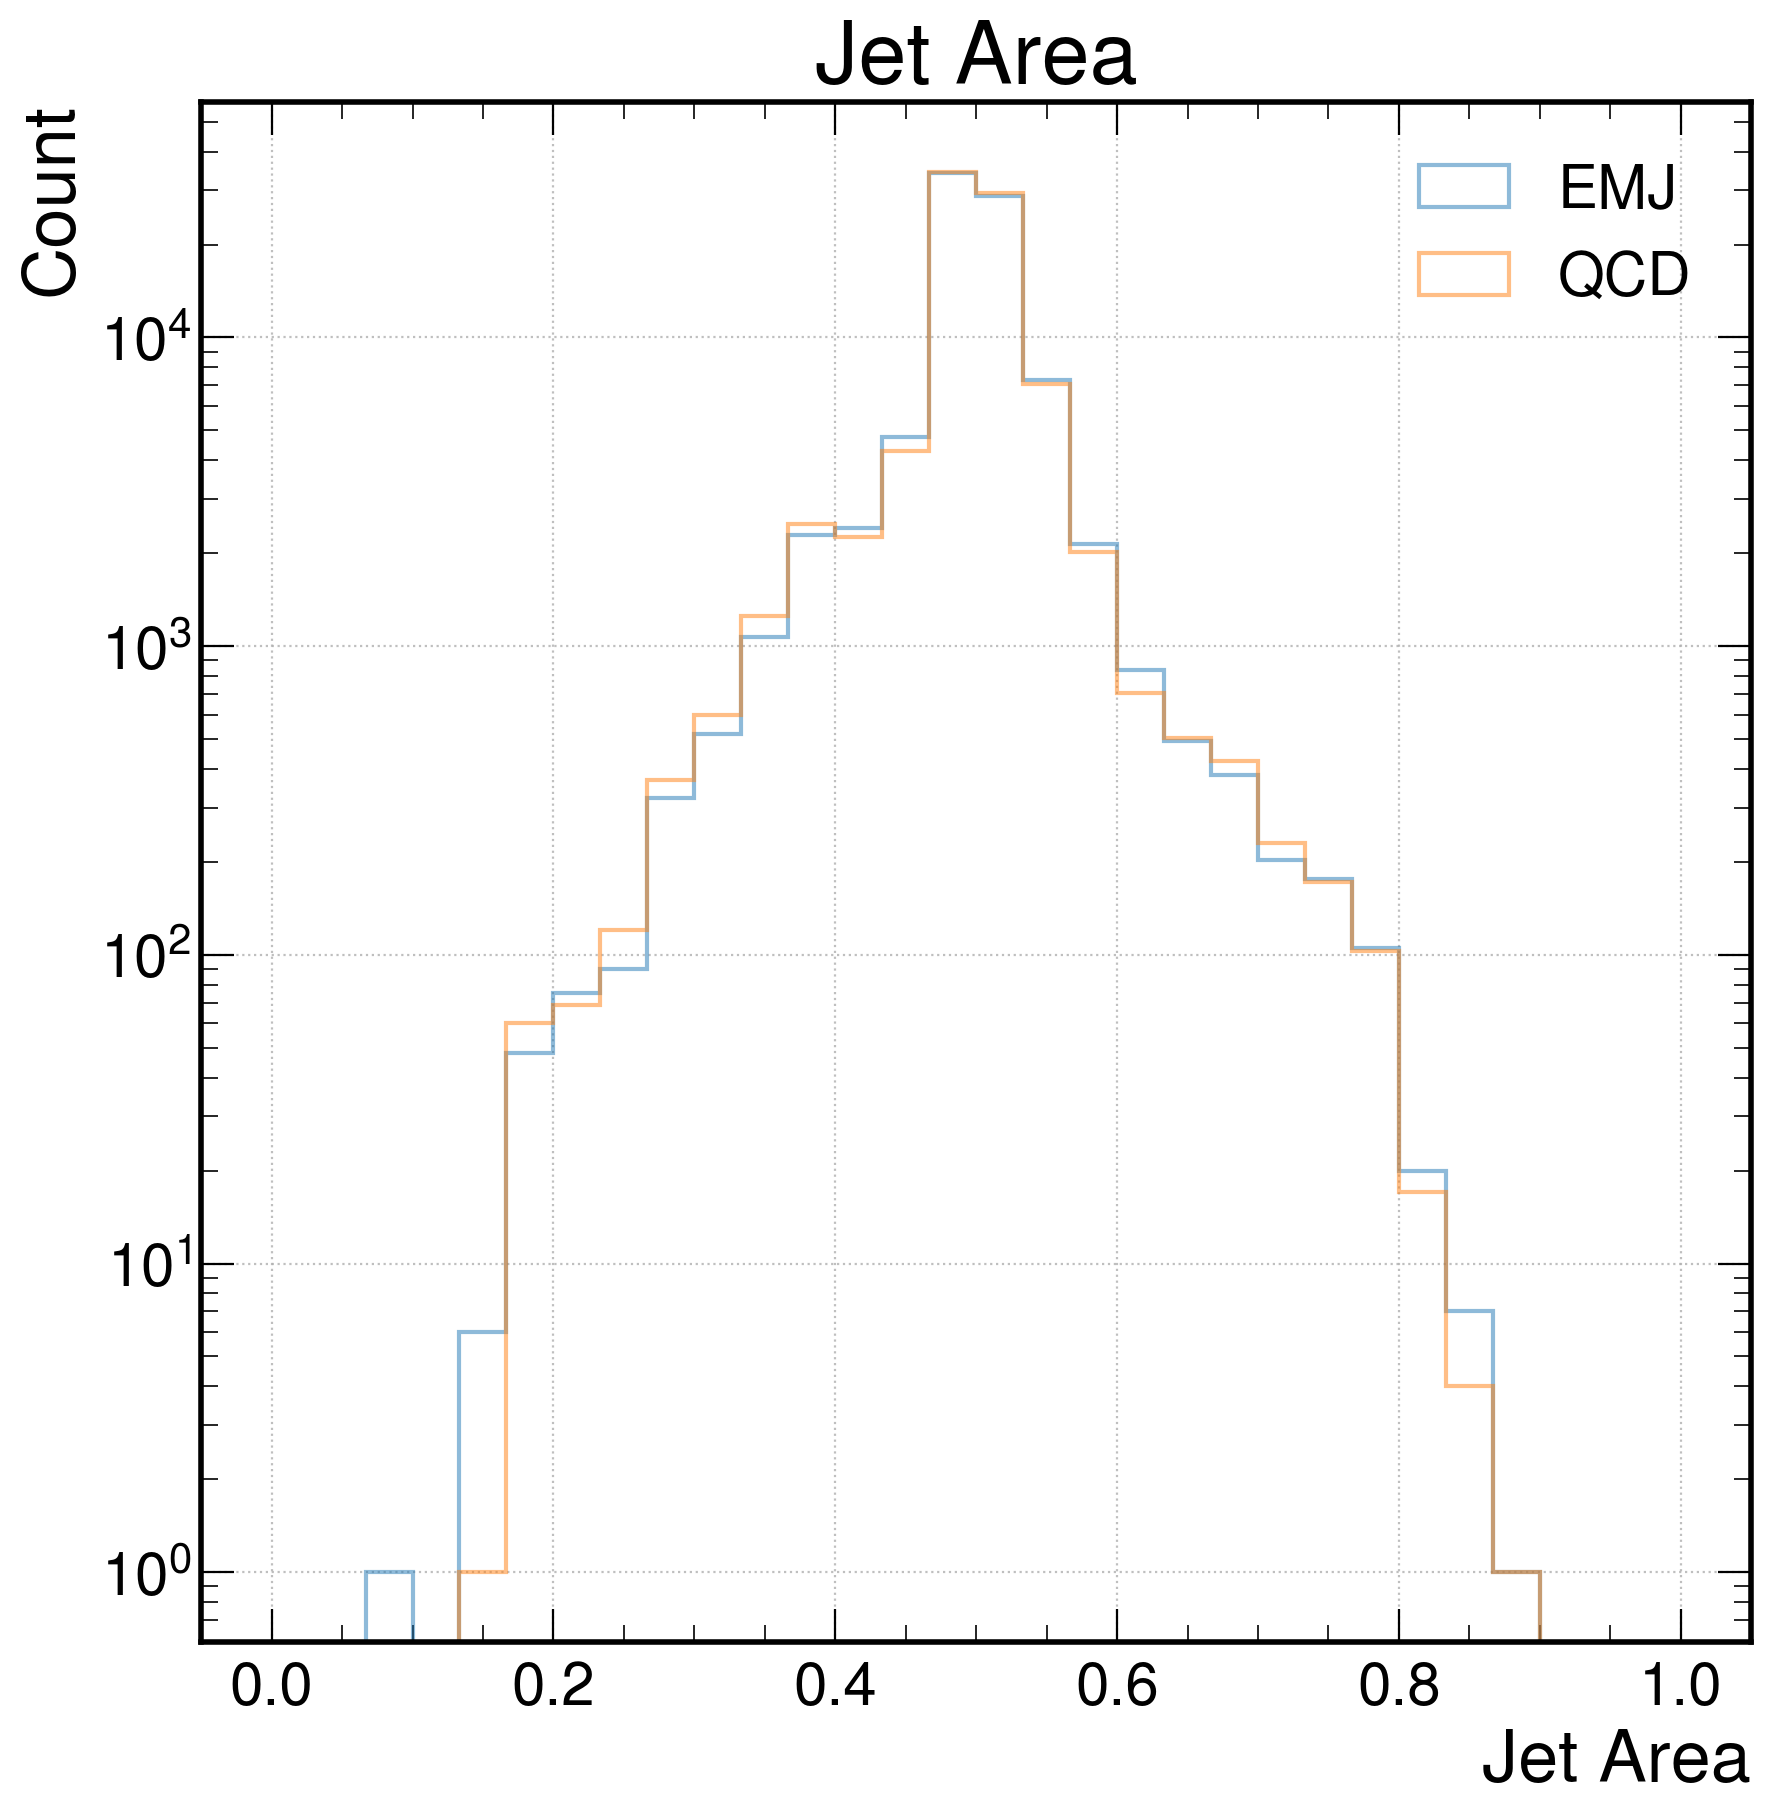

In [12]:
plot_ftrs(sig_jets, bkg_jets, "Jet_pt", "Jet $p_T$", 20, (0, 3500), "Jet $p_T$ [GeV]", "Count", log=True, normalized=False)
plot_ftrs(sig_jets, bkg_jets, "Jet_eta", "Jet $\eta$", 20, (-5, 5), "Jet $\eta$", "Count", log=False, normalized=False)
plot_ftrs(sig_jets, bkg_jets, "Jet_phi", "Jet $\phi$", 20, (-3.14, 3.14), "Jet $\phi$", "Count", log=False, normalized=False)
plot_ftrs(sig_jets, bkg_jets, "Jet_mass", "Jet Mass", 20, (0, 300), "Jet Mass [GeV]", "Count", log=True, normalized=False)
plot_ftrs(sig_jets, bkg_jets, "Jet_nConstituents", "Jet Number of Constituents", 20, (0, 100), "Number of Constituents", "Count", log=True, normalized=False)
plot_ftrs(sig_jets, bkg_jets, "Jet_nSVs", "Jet Number of Secondary Vertices", 10, (0, 10), "Number of Secondary Vertices", "Count", log=True, normalized=False)
plot_ftrs(sig_jets, bkg_jets, "Jet_area", "Jet Area", 30, (0, 1), "Jet Area", "Count", log=True, normalized=False)

In [13]:
# Looking at feature correlation with PU
lead_jets = data_tensor[:, 0, :]
corr_coefs = {}
for i, ftr_name in enumerate(features):
    corr_matrix = torch.corrcoef(torch.stack((lead_jets[:, i], nPU), dim=0))
    corr_coefs[ftr_name] = corr_matrix[0, 1].item()
    print(f"Correlation coefficient between {ftr_name} and nPU: {corr_coefs[ftr_name]:.4f}")

Correlation coefficient between Jet_pt and nPU: -0.0015
Correlation coefficient between Jet_eta and nPU: 0.0028
Correlation coefficient between Jet_phi and nPU: -0.0026
Correlation coefficient between Jet_mass and nPU: -0.0022
Correlation coefficient between Jet_nConstituents and nPU: -0.0488
Correlation coefficient between Jet_nSVs and nPU: -0.0230
Correlation coefficient between Jet_area and nPU: 0.0242


## Baseline: Training NN on Inputs

In [9]:
config_nn = {
    "n_epochs": 500,
    "learning_rate": 1e-3,
    "num_heads": 2,
    "num_layers": 1,
    "hidden_size": 4,
    "beta": 0.5,
    "patience": 20,
    "batch_size": batch_size,
}
pprint(config_nn)

{'batch_size': 512,
 'beta': 0.5,
 'hidden_size': 4,
 'learning_rate': 0.001,
 'n_epochs': 500,
 'num_heads': 2,
 'num_layers': 1,
 'patience': 20}


In [15]:
metrics = metric.metrics()
bce_loss = torch.nn.BCEWithLogitsLoss()
sigmoid = torch.nn.Sigmoid()

classifier_nn = model.MLPClassifier(
    input_dim=len(features) * njets,
    hidden_dim=config_nn["hidden_size"],
    hidden_layers=2,
    output_dim=1
).to(device)

optimizer_nn = torch.optim.Adam(
    list(classifier_nn.parameters()),
    lr=config_nn["learning_rate"]
)
    
early_stopper = training.EarlyStopping(config_nn["patience"])

In [16]:
# Classifier train without encoder
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
wandb.init(
    project="ml4phys_finalproj",
    name=f"run_classifier_nn_baseline_{timestamp}",
    config=config_nn
)

early_stopper = training.EarlyStopping(patience=config_nn["patience"]) # New instance

for epoch in range(config_nn["n_epochs"]):
    metrics.reset()
    classifier_nn.train()
    correct = count = 0
    total_bce = 0.0
    for x, _, labels in train_loader:
        x = x.to(device)
        x = x.view(x.size(0), -1)

        labels = labels.to(device)
        logit = classifier_nn(x)

        loss_bce = bce_loss(logit.squeeze(), labels)
        optimizer_nn.zero_grad()
        loss_bce.backward()
        optimizer_nn.step()
        total_bce += loss_bce.item() * x.size(0)
        metrics.update(labels.cpu(), (sigmoid(logit).squeeze() > 0.5).long().cpu())
        
    avg_bce = total_bce / len(train_ds)
    accuracy, precision, recall, f1_score = metrics.compute()

    # Eval
    metrics.reset()
    correct_val = count_val = 0
    total_bce_val = 0.0
    classifier_nn.eval()
    with torch.no_grad():
        for x_val, _, labels_val in val_loader:
            x_val = x_val.to(device)
            x_val = x_val.view(x_val.size(0), -1)
            labels_val = labels_val.to(device)
            logit_val = classifier_nn(x_val)

            loss_bce_val = bce_loss(logit_val.squeeze(), labels_val)
            total_bce_val += loss_bce_val.item() * x_val.size(0)
            metrics.update(labels_val.cpu(), (sigmoid(logit_val).squeeze() > 0.5).long().cpu())
    
    avg_bce_val = total_bce_val / len(val_ds)
    accuracy_val, precision_val, recall_val, f1_score_val = metrics.compute()

    print(f"Epoch {epoch+1}/{config_nn['n_epochs']}")
    print(f"Loss: {avg_bce:.4f}, BCE: {avg_bce:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")
    print(f"Val Loss: {avg_bce_val:.4f}, Val BCE: {avg_bce_val:.4f}, Val Accuracy: {accuracy_val:.4f}, Val Precision: {precision_val:.4f}, Val Recall: {recall_val:.4f}, Val F1 Score: {f1_score_val:.4f}")

    wandb.log({
        "epoch": epoch + 1,

        "bce_loss": avg_bce,
        "val_bce_loss": avg_bce_val,

        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "val_accuracy": accuracy_val,
        "val_precision": precision_val,
        "val_recall": recall_val,
        "val_f1_score": f1_score_val,
    })

    if early_stopper(avg_bce_val, classifier_nn):
        break

wandb.finish()

wandb: Currently logged in as: roycruzcan (roycruzcan-university-of-wisconsin-madison) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-scikit-learn/1.2.2-0c13e29466e1ed7a5a491b40663ac551/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-scikit-learn/1.2.2-0c13e29466e1ed7a5a491b40663ac551/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/500
Loss: 0.7217, BCE: 0.7217, Accuracy: 0.5002, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Val Loss: 0.7179, Val BCE: 0.7179, Val Accuracy: 0.4906, Val Precision: 0.0000, Val Recall: 0.0000, Val F1 Score: 0.0000
New best stop metric: 0.7179133479947903


/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-scikit-learn/1.2.2-0c13e29466e1ed7a5a491b40663ac551/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-scikit-learn/1.2.2-0c13e29466e1ed7a5a491b40663ac551/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/500
Loss: 0.7117, BCE: 0.7117, Accuracy: 0.5002, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Val Loss: 0.7122, Val BCE: 0.7122, Val Accuracy: 0.4906, Val Precision: 0.0000, Val Recall: 0.0000, Val F1 Score: 0.0000
New best stop metric: 0.7122359884894313


/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-scikit-learn/1.2.2-0c13e29466e1ed7a5a491b40663ac551/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/500
Loss: 0.7063, BCE: 0.7063, Accuracy: 0.5003, Precision: 0.5200, Recall: 0.0025, F1 Score: 0.0049
Val Loss: 0.7077, Val BCE: 0.7077, Val Accuracy: 0.4906, Val Precision: 0.0000, Val Recall: 0.0000, Val F1 Score: 0.0000
New best stop metric: 0.7077495159688308


/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-scikit-learn/1.2.2-0c13e29466e1ed7a5a491b40663ac551/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/500
Loss: 0.7027, BCE: 0.7027, Accuracy: 0.4992, Precision: 0.4765, Recall: 0.0206, F1 Score: 0.0395
Val Loss: 0.7042, Val BCE: 0.7042, Val Accuracy: 0.4906, Val Precision: 0.0000, Val Recall: 0.0000, Val F1 Score: 0.0000
New best stop metric: 0.7042024780422768


/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-scikit-learn/1.2.2-0c13e29466e1ed7a5a491b40663ac551/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/500
Loss: 0.7000, BCE: 0.7000, Accuracy: 0.4999, Precision: 0.4950, Recall: 0.0315, F1 Score: 0.0592
Val Loss: 0.7015, Val BCE: 0.7015, Val Accuracy: 0.4906, Val Precision: 0.0000, Val Recall: 0.0000, Val F1 Score: 0.0000
New best stop metric: 0.7014720546575022


/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-scikit-learn/1.2.2-0c13e29466e1ed7a5a491b40663ac551/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/500
Loss: 0.6978, BCE: 0.6978, Accuracy: 0.5014, Precision: 0.5115, Recall: 0.0550, F1 Score: 0.0993
Val Loss: 0.6993, Val BCE: 0.6993, Val Accuracy: 0.4906, Val Precision: 0.0000, Val Recall: 0.0000, Val F1 Score: 0.0000
New best stop metric: 0.6992613504123252


/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-scikit-learn/1.2.2-0c13e29466e1ed7a5a491b40663ac551/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/500
Loss: 0.6955, BCE: 0.6955, Accuracy: 0.5069, Precision: 0.5681, Recall: 0.0557, F1 Score: 0.1014
Val Loss: 0.6976, Val BCE: 0.6976, Val Accuracy: 0.4906, Val Precision: 0.0000, Val Recall: 0.0000, Val F1 Score: 0.0000
New best stop metric: 0.6975695406899697
Epoch 8/500
Loss: 0.6943, BCE: 0.6943, Accuracy: 0.5092, Precision: 0.5839, Recall: 0.0631, F1 Score: 0.1138
Val Loss: 0.6963, Val BCE: 0.6963, Val Accuracy: 0.4908, Val Precision: 0.6667, Val Recall: 0.0010, Val F1 Score: 0.0020
New best stop metric: 0.6963180033883045
Epoch 9/500
Loss: 0.6931, BCE: 0.6931, Accuracy: 0.5116, Precision: 0.6185, Recall: 0.0594, F1 Score: 0.1084
Val Loss: 0.6954, Val BCE: 0.6954, Val Accuracy: 0.4924, Val Precision: 0.8889, Val Recall: 0.0040, Val F1 Score: 0.0079
New best stop metric: 0.6953969172675051
Epoch 10/500
Loss: 0.6916, BCE: 0.6916, Accuracy: 0.5158, Precision: 0.6026, Recall: 0.0915, F1 Score: 0.1589
Val Loss: 0.6624, Val BCE: 0.6624, Val Accuracy: 0.6240, Val Precision: 0.587

In [17]:
# Load the model from best checkpoint
classifier_nn.load_state_dict(early_stopper.best_model_state)

# Save best model 
torch.save(classifier_nn.state_dict(), "./models/classifier_nn.pth")

## Baseline: Jointly Trained Encoder + Classifier

### Architecture Instantiation & Training

In [10]:
config_joint = {
    "n_epochs": 500,
    "learning_rate": 1e-3,
    "num_heads": 2,
    "num_layers": 1,
    "hidden_size": 4,
    "contrastive_temp": 0.07,
    "beta": 0.5,
    "patience": 20,
    "batch_size": batch_size,
}
pprint(config_joint)

{'batch_size': 512,
 'beta': 0.5,
 'contrastive_temp': 0.07,
 'hidden_size': 4,
 'learning_rate': 0.001,
 'n_epochs': 500,
 'num_heads': 2,
 'num_layers': 1,
 'patience': 20}


In [19]:
metrics = metric.metrics()
bce_loss = torch.nn.BCEWithLogitsLoss()
contrastive_loss = training.SupConLoss(config_joint["contrastive_temp"])
sigmoid = torch.nn.Sigmoid()

encoder_joint = model.TransformerEncoder(
    num_features=num_ftrs,
    embed_size=config_joint["hidden_size"],
    num_heads=config_joint["num_heads"],
    num_layers=config_joint["num_layers"]
).to(device)

classifier_joint = model.MLPClassifier(
    input_dim=config_joint["hidden_size"],
    hidden_dim=config_joint["hidden_size"],
    hidden_layers=2,
    output_dim=1
).to(device)

optimizer_joint = torch.optim.Adam(
    list(encoder_joint.parameters()) + list(classifier_joint.parameters()),
    lr=config_joint["learning_rate"]
)

early_stopper = training.EarlyStopping(config_joint["patience"])

In [20]:
# Train loop
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
wandb.init(
    project="ml4phys_finalproj",
    name=f"run_jointarch_{timestamp}",
    config=config_joint
)

for epoch in range(config_joint["n_epochs"]):
    metrics.reset()
    encoder_joint.train()
    classifier_joint.train()

    correct = count = 0
    total_loss = total_bce = total_contrastive = 0.0
    for x, mask, labels in train_loader:
        x = x.to(device)
        mask = mask.to(device)
        labels = labels.to(device)

        latent = encoder_joint(x, mask).to(device)
        logit = classifier_joint(latent)

        loss_bce = bce_loss(logit.squeeze(), labels)
        loss_contrastive = contrastive_loss(latent.unsqueeze(1), labels)
        loss = (1 - config_joint["beta"]) * loss_bce + config_joint["beta"] * loss_contrastive
        optimizer_joint.zero_grad()
        loss.backward()
        optimizer_joint.step()

        total_contrastive += loss_contrastive.item() * x.size(0)
        total_bce += loss_bce.item() * x.size(0)
        total_loss += loss.item() * x.size(0)
        metrics.update(labels.cpu(), (sigmoid(logit).squeeze() > 0.5).long().cpu())
        
    avg_loss = total_loss / len(train_ds)
    avg_contrastive = total_contrastive / len(train_ds)
    avg_bce = total_bce / len(train_ds)
    accuracy, precision, recall, f1_score = metrics.compute()

    # Eval
    metrics.reset()
    correct_val = count_val = 0
    total_loss_val = total_bce_val = total_contrastive_val = 0.0
    encoder_joint.eval()
    classifier_joint.eval()
    with torch.no_grad():
        for x_val, mask_val, labels_val in val_loader:
            x_val = x_val.to(device)
            mask_val = mask_val.to(device)
            labels_val = labels_val.to(device)

            latent_val = encoder_joint(x_val, mask_val).to(device)
            logit_val = classifier_joint(latent_val)

            loss_contrastive_val = contrastive_loss(latent_val.unsqueeze(1), labels_val)
            loss_bce_val = bce_loss(logit_val.squeeze(), labels_val)
            loss_val = (1 - config_joint["beta"]) * loss_bce_val + config_joint["beta"] * loss_contrastive_val
            total_contrastive_val += loss_contrastive_val.item() * x_val.size(0)
            total_bce_val += loss_bce_val.item() * x_val.size(0)
            total_loss_val += loss_val.item() * x_val.size(0)
        metrics.update(labels_val.cpu(), (sigmoid(logit_val).squeeze() > 0.5).long().cpu())

    avg_contrastive_val = total_contrastive_val / len(val_ds)
    avg_bce_val = total_bce_val / len(val_ds)
    avg_loss_val = total_loss_val / len(val_ds)
    accuracy_val, precision_val, recall_val, f1_score_val = metrics.compute()

    print(f"Epoch {epoch+1}/{config_joint['n_epochs']}")
    print(f"Loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")
    print(f"Val Loss: {avg_loss_val:.4f}, Val BCE: {avg_bce_val:.4f}, Val Accuracy: {accuracy_val:.4f}, Val Precision: {precision_val:.4f}, Val Recall: {recall_val:.4f}, Val F1 Score: {f1_score_val:.4f}")

    wandb.log({
        "epoch": epoch + 1,

        "contrastive_loss": avg_contrastive,
        "bce_loss": avg_bce,
        "loss": avg_loss,
        "val_contrastive_loss": avg_contrastive_val,
        "val_bce_loss": avg_bce_val,
        "val_loss": avg_loss_val,

        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "val_accuracy": accuracy_val,
        "val_precision": precision_val,
        "val_recall": recall_val,
        "val_f1_score": f1_score_val,
    })

    if early_stopper(avg_loss_val, [encoder_joint, classifier_joint]):
        break
    
wandb.finish()

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-scikit-learn/1.2.2-0c13e29466e1ed7a5a491b40663ac551/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/500
Loss: 3.7185, BCE: 0.6949, Accuracy: 0.5024, Precision: 0.5015, Recall: 0.7542, F1 Score: 0.6024
Val Loss: 3.4457, Val BCE: 0.6932, Val Accuracy: 0.4857, Val Precision: 0.0000, Val Recall: 0.0000, Val F1 Score: 0.0000
New best stop metric: 3.445730089232227


/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-scikit-learn/1.2.2-0c13e29466e1ed7a5a491b40663ac551/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/500
Loss: 3.4766, BCE: 0.6940, Accuracy: 0.5025, Precision: 0.5016, Recall: 0.7344, F1 Score: 0.5960
Val Loss: 3.4438, Val BCE: 0.6932, Val Accuracy: 0.4857, Val Precision: 0.0000, Val Recall: 0.0000, Val F1 Score: 0.0000
New best stop metric: 3.4438052897412095


/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-scikit-learn/1.2.2-0c13e29466e1ed7a5a491b40663ac551/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/500
Loss: 3.4675, BCE: 0.6937, Accuracy: 0.4995, Precision: 0.4995, Recall: 0.7263, F1 Score: 0.5919
Val Loss: 3.4392, Val BCE: 0.6928, Val Accuracy: 0.4857, Val Precision: 0.0000, Val Recall: 0.0000, Val F1 Score: 0.0000
New best stop metric: 3.4391606220086333


/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-scikit-learn/1.2.2-0c13e29466e1ed7a5a491b40663ac551/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/500
Loss: 3.4630, BCE: 0.6935, Accuracy: 0.5019, Precision: 0.5012, Recall: 0.7254, F1 Score: 0.5928
Val Loss: 3.4345, Val BCE: 0.6923, Val Accuracy: 0.4857, Val Precision: 0.0000, Val Recall: 0.0000, Val F1 Score: 0.0000
New best stop metric: 3.434486645881331


/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-scikit-learn/1.2.2-0c13e29466e1ed7a5a491b40663ac551/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/500
Loss: 3.4575, BCE: 0.6926, Accuracy: 0.5027, Precision: 0.5018, Recall: 0.7265, F1 Score: 0.5936
Val Loss: 3.4300, Val BCE: 0.6913, Val Accuracy: 0.4857, Val Precision: 0.0000, Val Recall: 0.0000, Val F1 Score: 0.0000
New best stop metric: 3.4300146584105966
Epoch 6/500
Loss: 3.4496, BCE: 0.6905, Accuracy: 0.5307, Precision: 0.5226, Recall: 0.7071, F1 Score: 0.6010
Val Loss: 3.4174, Val BCE: 0.6874, Val Accuracy: 0.7571, Val Precision: 0.6908, Val Recall: 0.9556, Val F1 Score: 0.8019
New best stop metric: 3.4173554295383255
Epoch 7/500
Loss: 3.4414, BCE: 0.6843, Accuracy: 0.5872, Precision: 0.5713, Recall: 0.6968, F1 Score: 0.6279
Val Loss: 3.4033, Val BCE: 0.6756, Val Accuracy: 0.7229, Val Precision: 0.6543, Val Recall: 0.9778, Val F1 Score: 0.7840
New best stop metric: 3.4033246269429704
Epoch 8/500
Loss: 3.4273, BCE: 0.6688, Accuracy: 0.6510, Precision: 0.6311, Recall: 0.7263, F1 Score: 0.6753
Val Loss: 3.3897, Val BCE: 0.6521, Val Accuracy: 0.7514, Val Precision: 0.6838

In [21]:
# Load the best model from early stopping
best_model_states = early_stopper.best_model_state
encoder_joint.load_state_dict(best_model_states[0])
classifier_joint.load_state_dict(best_model_states[1])

# Save
torch.save({
    "encoder_state": encoder_joint.state_dict(),
    "classifier_state": classifier_joint.state_dict(),
}, "./models/encoder_classifier_joint.pth")

## Encoder + Classifier w/ Encoder Pre-training

In [11]:
config_pretr = {
    "n_epochs_encoder": 500,
    "n_epochs_classifier": 500,
    "learning_rate_encoder": 1e-3,
    "learning_rate_classifier": 1e-3,
    "num_heads": 2,
    "num_layers": 1,
    "hidden_size": 4,
    "contrastive_temp": 0.07,
    "patience_encoder": 20,
    "patience_classifier": 20,
    "batch_size": batch_size,
}
pprint(config_pretr)

{'batch_size': 512,
 'contrastive_temp': 0.07,
 'hidden_size': 4,
 'learning_rate_classifier': 0.001,
 'learning_rate_encoder': 0.001,
 'n_epochs_classifier': 500,
 'n_epochs_encoder': 500,
 'num_heads': 2,
 'num_layers': 1,
 'patience_classifier': 20,
 'patience_encoder': 20}


In [26]:
metrics = metric.metrics()
bce_loss = torch.nn.BCEWithLogitsLoss()
contrastive_loss = training.SupConLoss(config_pretr["contrastive_temp"])
sigmoid = torch.nn.Sigmoid()

classifier = model.MLPClassifier(
    input_dim=config_pretr["hidden_size"],
    hidden_dim=config_pretr["hidden_size"],
    hidden_layers=2,
    output_dim=1
).to(device)

optimizer_classifier = torch.optim.Adam(
    classifier.parameters(),
    lr=config_pretr["learning_rate_classifier"]
)

In [27]:
encoder = model.TransformerEncoder(
    num_features=num_ftrs,
    embed_size=config_pretr["hidden_size"],
    num_heads=config_pretr["num_heads"],
    num_layers=config_pretr["num_layers"]
).to(device)

optimizer_encoder = torch.optim.Adam(
    encoder.parameters(),
    lr=config_pretr["learning_rate_encoder"]
)

# Encoder pretrain
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
wandb.init(
    project="ml4phys_finalproj",
    name=f"run_encoderpretrain_{timestamp}",
    config=config_pretr
)

early_stopper = training.EarlyStopping(config_pretr["patience_encoder"])
for epoch in range(config_pretr["n_epochs_encoder"]):
    encoder.train()
    total_contrastive = 0.0
    for x, mask, labels in train_loader:
        x = x.to(device)
        mask = mask.to(device)
        labels = labels.to(device)
        latent = encoder(x, mask).to(device)

        loss_contrastive = contrastive_loss(latent.unsqueeze(1), labels)
        optimizer_encoder.zero_grad()
        loss_contrastive.backward()
        optimizer_encoder.step()
        total_contrastive += loss_contrastive.item() * x.size(0)
        
    avg_contrastive = total_contrastive / len(train_ds)

    # Eval
    encoder.eval()
    total_contrastive_val = 0.0
    with torch.no_grad():
        for x_val, mask_val, labels_val in val_loader:
            x_val = x_val.to(device)
            mask_val = mask_val.to(device)
            labels_val = labels_val.to(device)

            latent_val = encoder(x_val, mask_val).to(device)
            loss_contrastive_val = contrastive_loss(latent_val.unsqueeze(1), labels_val)
            total_contrastive_val += loss_contrastive_val.item() * x_val.size(0)

    avg_contrastive_val = total_contrastive_val / len(val_ds)

    print(f"Epoch {epoch+1}/{config_pretr['n_epochs_encoder']}")
    print(f"Contrastive Loss: {avg_contrastive:.4f}, Contrastive Loss Val: {avg_contrastive_val:.4f}")

    wandb.log({
        "epoch": epoch + 1,
        "contrastive_loss": avg_contrastive,
        "val_contrastive_loss": avg_contrastive_val,
    })
    
    if early_stopper(avg_contrastive_val, encoder):
        break

wandb.finish()

Epoch 1/500
Contrastive Loss: 6.8981, Contrastive Loss Val: 6.1985
New best stop metric: 6.198510962933772
Epoch 2/500
Contrastive Loss: 6.2644, Contrastive Loss Val: 6.1874
New best stop metric: 6.187362829197707
Epoch 3/500
Contrastive Loss: 6.2379, Contrastive Loss Val: 6.1776
New best stop metric: 6.177563147309715
Epoch 4/500
Contrastive Loss: 6.2204, Contrastive Loss Val: 6.1600
New best stop metric: 6.1600450536110225
Epoch 5/500
Contrastive Loss: 6.2071, Contrastive Loss Val: 6.1439
New best stop metric: 6.143935305852846
Epoch 6/500
Contrastive Loss: 6.1958, Contrastive Loss Val: 6.1321
New best stop metric: 6.132134701554764
Epoch 7/500
Contrastive Loss: 6.1895, Contrastive Loss Val: 6.1321
New best stop metric: 6.132118907263271
Epoch 8/500
Contrastive Loss: 6.1825, Contrastive Loss Val: 6.1278
New best stop metric: 6.12778001250988
Epoch 9/500
Contrastive Loss: 6.1765, Contrastive Loss Val: 6.1241
New best stop metric: 6.124072515364523
Epoch 10/500
Contrastive Loss: 6.1721

In [28]:
# Load the best model from the early stopping
encoder.load_state_dict(early_stopper.best_model_state)

# Save best model 
# torch.save(encoder.state_dict(), "./models/encoder.pth")

<All keys matched successfully>

In [29]:
# Classifier train with pretrained encoder
wandb.init(
    project="ml4phys_finalproj",
    name=f"run_classifier_wpretrainedencoder_{timestamp}",
    config=config_pretr
)

encoder.eval()
early_stopper = training.EarlyStopping(patience=config_pretr["patience_classifier"]) # New instance

for epoch in range(config_pretr["n_epochs_classifier"]):
    metrics.reset()
    classifier.train()
    correct = count = 0
    total_bce = 0.0
    for x, mask, labels in train_loader:
        x = x.to(device)
        mask = mask.to(device)
        labels = labels.to(device)
        latent = encoder(x, mask).to(device)
        logit = classifier(latent)

        loss_bce = bce_loss(logit.squeeze(), labels)
        optimizer_classifier.zero_grad()
        loss_bce.backward()
        optimizer_classifier.step()
        total_bce += loss_bce.item() * x.size(0)
        metrics.update(labels.cpu(), (sigmoid(logit).squeeze() > 0.5).long().cpu())
        
    avg_bce = total_bce / len(train_ds)
    accuracy, precision, recall, f1_score = metrics.compute()

    # Eval
    metrics.reset()
    correct_val = count_val = 0
    total_bce_val = 0.0
    classifier.eval()
    with torch.no_grad():
        for x_val, mask_val, labels_val in val_loader:
            x_val = x_val.to(device)
            mask_val = mask_val.to(device)
            labels_val = labels_val.to(device)
            latent_val = encoder(x_val, mask_val).to(device)
            logit_val = classifier(latent_val)

            loss_bce_val = bce_loss(logit_val.squeeze(), labels_val)
            total_bce_val += loss_bce_val.item() * x_val.size(0)
            metrics.update(labels_val.cpu(), (sigmoid(logit_val).squeeze() > 0.5).long().cpu())
    
    avg_bce_val = total_bce_val / len(val_ds)
    accuracy_val, precision_val, recall_val, f1_score_val = metrics.compute()

    print(f"Epoch {epoch+1}/{config_pretr['n_epochs_classifier']}")
    print(f"Loss: {avg_bce:.4f}, BCE: {avg_bce:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")
    print(f"Val Loss: {avg_bce_val:.4f}, Val BCE: {avg_bce_val:.4f}, Val Accuracy: {accuracy_val:.4f}, Val Precision: {precision_val:.4f}, Val Recall: {recall_val:.4f}, Val F1 Score: {f1_score_val:.4f}")

    wandb.log({
        "epoch": epoch + 1,

        "bce_loss": avg_bce,
        "val_bce_loss": avg_bce_val,

        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "val_accuracy": accuracy_val,
        "val_precision": precision_val,
        "val_recall": recall_val,
        "val_f1_score": f1_score_val,
    })

    if early_stopper(avg_bce_val, classifier):
        break

wandb.finish()

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-scikit-learn/1.2.2-0c13e29466e1ed7a5a491b40663ac551/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/500
Loss: 0.6927, BCE: 0.6927, Accuracy: 0.5317, Precision: 0.8493, Recall: 0.0767, F1 Score: 0.1407
Val Loss: 0.6904, Val BCE: 0.6904, Val Accuracy: 0.4906, Val Precision: 0.0000, Val Recall: 0.0000, Val F1 Score: 0.0000
New best stop metric: 0.6903828657334021
Epoch 2/500
Loss: 0.6875, BCE: 0.6875, Accuracy: 0.5177, Precision: 0.5138, Recall: 0.6513, F1 Score: 0.5744
Val Loss: 0.6827, Val BCE: 0.6827, Val Accuracy: 0.6683, Val Precision: 0.6063, Val Recall: 0.9950, Val F1 Score: 0.7534
New best stop metric: 0.6827069790034834
Epoch 3/500
Loss: 0.6751, BCE: 0.6751, Accuracy: 0.5653, Precision: 0.5468, Recall: 0.7608, F1 Score: 0.6363
Val Loss: 0.6589, Val BCE: 0.6589, Val Accuracy: 0.7369, Val Precision: 0.6619, Val Recall: 0.9885, Val F1 Score: 0.7929
New best stop metric: 0.6589123564864635
Epoch 4/500
Loss: 0.6358, BCE: 0.6358, Accuracy: 0.7232, Precision: 0.6888, Recall: 0.8141, F1 Score: 0.7462
Val Loss: 0.5945, Val BCE: 0.5945, Val Accuracy: 0.8401, Val Precision: 0.7917

In [31]:
# Load the model from best checkpoint
classifier.load_state_dict(early_stopper.best_model_state)

# Save best model 
torch.save({
    "encoder_state": encoder.state_dict(),
    "classifier_state": classifier.state_dict(),    
}, "./models/encoder_classifier_pretrained.pth")

## Evaluation
### ML Metrics

In [19]:
# # Loading models
# Baseline NN
classifier_nn = model.MLPClassifier(
    input_dim=len(features) * njets,
    hidden_dim=config_nn["hidden_size"],
    hidden_layers=2,
    output_dim=1
).to(device)
classifier_nn.load_state_dict(torch.load("./models/classifier_nn.pth"))

# Joint architecture
checkpoint_joint = torch.load("./models/encoder_classifier_joint.pth")
encoder_joint = model.TransformerEncoder(
    num_features=num_ftrs,
    embed_size=config_joint["hidden_size"],
    num_heads=config_joint["num_heads"],
    num_layers=config_joint["num_layers"]
).to(device)
encoder_joint.load_state_dict(checkpoint_joint["encoder_state"])

classifier_joint = model.MLPClassifier(
    input_dim=config_joint["hidden_size"],
    hidden_dim=config_joint["hidden_size"],
    hidden_layers=2,
    output_dim=1
).to(device)
classifier_joint.load_state_dict(checkpoint_joint["classifier_state"])

# Pretrained encoder + classifier
checkpoint_pretr = torch.load("./models/encoder_classifier_pretrained.pth")
encoder_pretr = model.TransformerEncoder(
    num_features=num_ftrs,
    embed_size=config_pretr["hidden_size"],
    num_heads=config_pretr["num_heads"],
    num_layers=config_pretr["num_layers"]
).to(device)
encoder_pretr.load_state_dict(checkpoint_pretr["encoder_state"])

classifier_pretr = model.MLPClassifier(
    input_dim=config_pretr["hidden_size"],
    hidden_dim=config_pretr["hidden_size"],
    hidden_layers=2,
    output_dim=1
).to(device)
classifier_pretr.load_state_dict(checkpoint_pretr["classifier_state"])

sigmoid = torch.nn.Sigmoid()

In [ ]:
# Get embeddings and logits for test set

def get_embeddings_and_logits(encoder, classifier, dataloader):
    metrics = metric.metrics()

    encoder.eval()
    classifier.eval()
    all_embeddings = []
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for x, mask, labels in dataloader:
            x = x.to(device)
            mask = mask.to(device)
            labels = labels.to(device)

            latent = encoder(x, mask).to(device)
            logit = classifier(latent)

            all_embeddings.append(latent.cpu())
            all_logits.append(logit.cpu())
            all_labels.append(labels.cpu())

            print(logit)

            metrics.update(labels.cpu().numpy(), sigmoid(logit).float().cpu())

    print(metrics.preds)
    print(metrics.labels)
    accuracy, precision, recall, f1_score = metrics.compute()
    return torch.cat(all_embeddings), torch.cat(all_logits), torch.cat(all_labels)

print("Performance metrics for jointly trained model...")
embeddings_joint, logits_joint, labels_joint = get_embeddings_and_logits(encoder_joint, classifier_joint, test_loader)
print("Performance metrics for pretrained encoder + classifier model...")
embeddings_pretr, logits_pretr, labels_pretr = get_embeddings_and_logits(encoder_pretr, classifier_pretr, test_loader)

Performance metrics for jointly trained model...
[[0.11008519679307938], [0.2331448644399643], [0.9997623562812805], [0.11008519679307938], [0.11008519679307938], [0.1224786564707756], [0.9972622394561768], [0.9997991919517517], [0.11008519679307938], [0.8170521259307861], [0.11366315186023712], [0.16353729367256165], [0.11008519679307938], [0.11008519679307938], [0.9997957348823547], [0.9997631907463074], [0.9998039603233337], [0.11008519679307938], [0.11008519679307938], [0.4517539441585541], [0.11073363572359085], [0.11008519679307938], [0.11008519679307938], [0.15150374174118042], [0.11709699779748917], [0.1131356805562973], [0.11008519679307938], [0.9995725750923157], [0.9998127818107605], [0.9997356534004211], [0.11948131024837494], [0.8597419261932373], [0.27667921781539917], [0.9997919201850891], [0.178347647190094], [0.11008519679307938], [0.11008519679307938], [0.9916199445724487], [0.11008519679307938], [0.999776303768158], [0.11008519679307938], [0.7019210457801819], [0.110

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [14]:
# Get logits for baseline NN
def get_logits_nn(classifier, dataloader):
    classifier.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for x, _, labels in dataloader:
            x = x.to(device)
            x = x.view(x.size(0), -1)
            labels = labels.to(device)

            logit = classifier(x)

            all_logits.append(logit.cpu())
            all_labels.append(labels.cpu())
    return torch.cat(all_logits), torch.cat(all_labels)

logits_nn, labels_nn = get_logits_nn(classifier_nn, test_loader)

In [15]:
prob_joint = torch.sigmoid(logits_joint).squeeze().numpy()
prob_pretr = torch.sigmoid(logits_pretr).squeeze().numpy()
prob_nn = torch.sigmoid(logits_nn).squeeze().numpy()

In [16]:
test_data_tensor = test_ds.data.to(device)
test_data_labels = test_ds.labels.to(device)

# Get PCA
pca = PCA(n_components=4)
pca_joint = pca.fit_transform(embeddings_joint.cpu().numpy())
pca_pretr = pca.fit_transform(embeddings_pretr.cpu().numpy())

embeddings_joint_df = pd.DataFrame({
    "label": test_data_labels.cpu().numpy(),
    "embed_1": embeddings_joint[0:, 0].cpu().numpy(),
    "embed_2": embeddings_joint[0:, 1].cpu().numpy(),
    "embed_3": embeddings_joint[0:, 2].cpu().numpy(),
    "embed_4": embeddings_joint[0:, 3].cpu().numpy(),
    "PCA_1": pca_joint[:, 0],
    "PCA_2": pca_joint[:, 1],
    "PCA_3": pca_joint[:, 2],
    "PCA_4": pca_joint[:, 3],
})
embeddings_pretr_df = pd.DataFrame({
    "label": test_data_labels.cpu().numpy(),
    "embed_1": embeddings_pretr[0:, 0].cpu().numpy(),
    "embed_2": embeddings_pretr[0:, 1].cpu().numpy(),
    "embed_3": embeddings_pretr[0:, 2].cpu().numpy(),
    "embed_4": embeddings_pretr[0:, 3].cpu().numpy(),
    "PCA_1": pca_pretr[:, 0],
    "PCA_2": pca_pretr[:, 1],
    "PCA_3": pca_pretr[:, 2],
    "PCA_4": pca_pretr[:, 3],
})

# Convert labels to str (EJ = 1, QCD = 0)
embeddings_joint_df["label"] = embeddings_joint_df["label"].map({1: "EJ", 0: "QCD"})
embeddings_pretr_df["label"] = embeddings_pretr_df["label"].map({1: "EJ", 0: "QCD"})

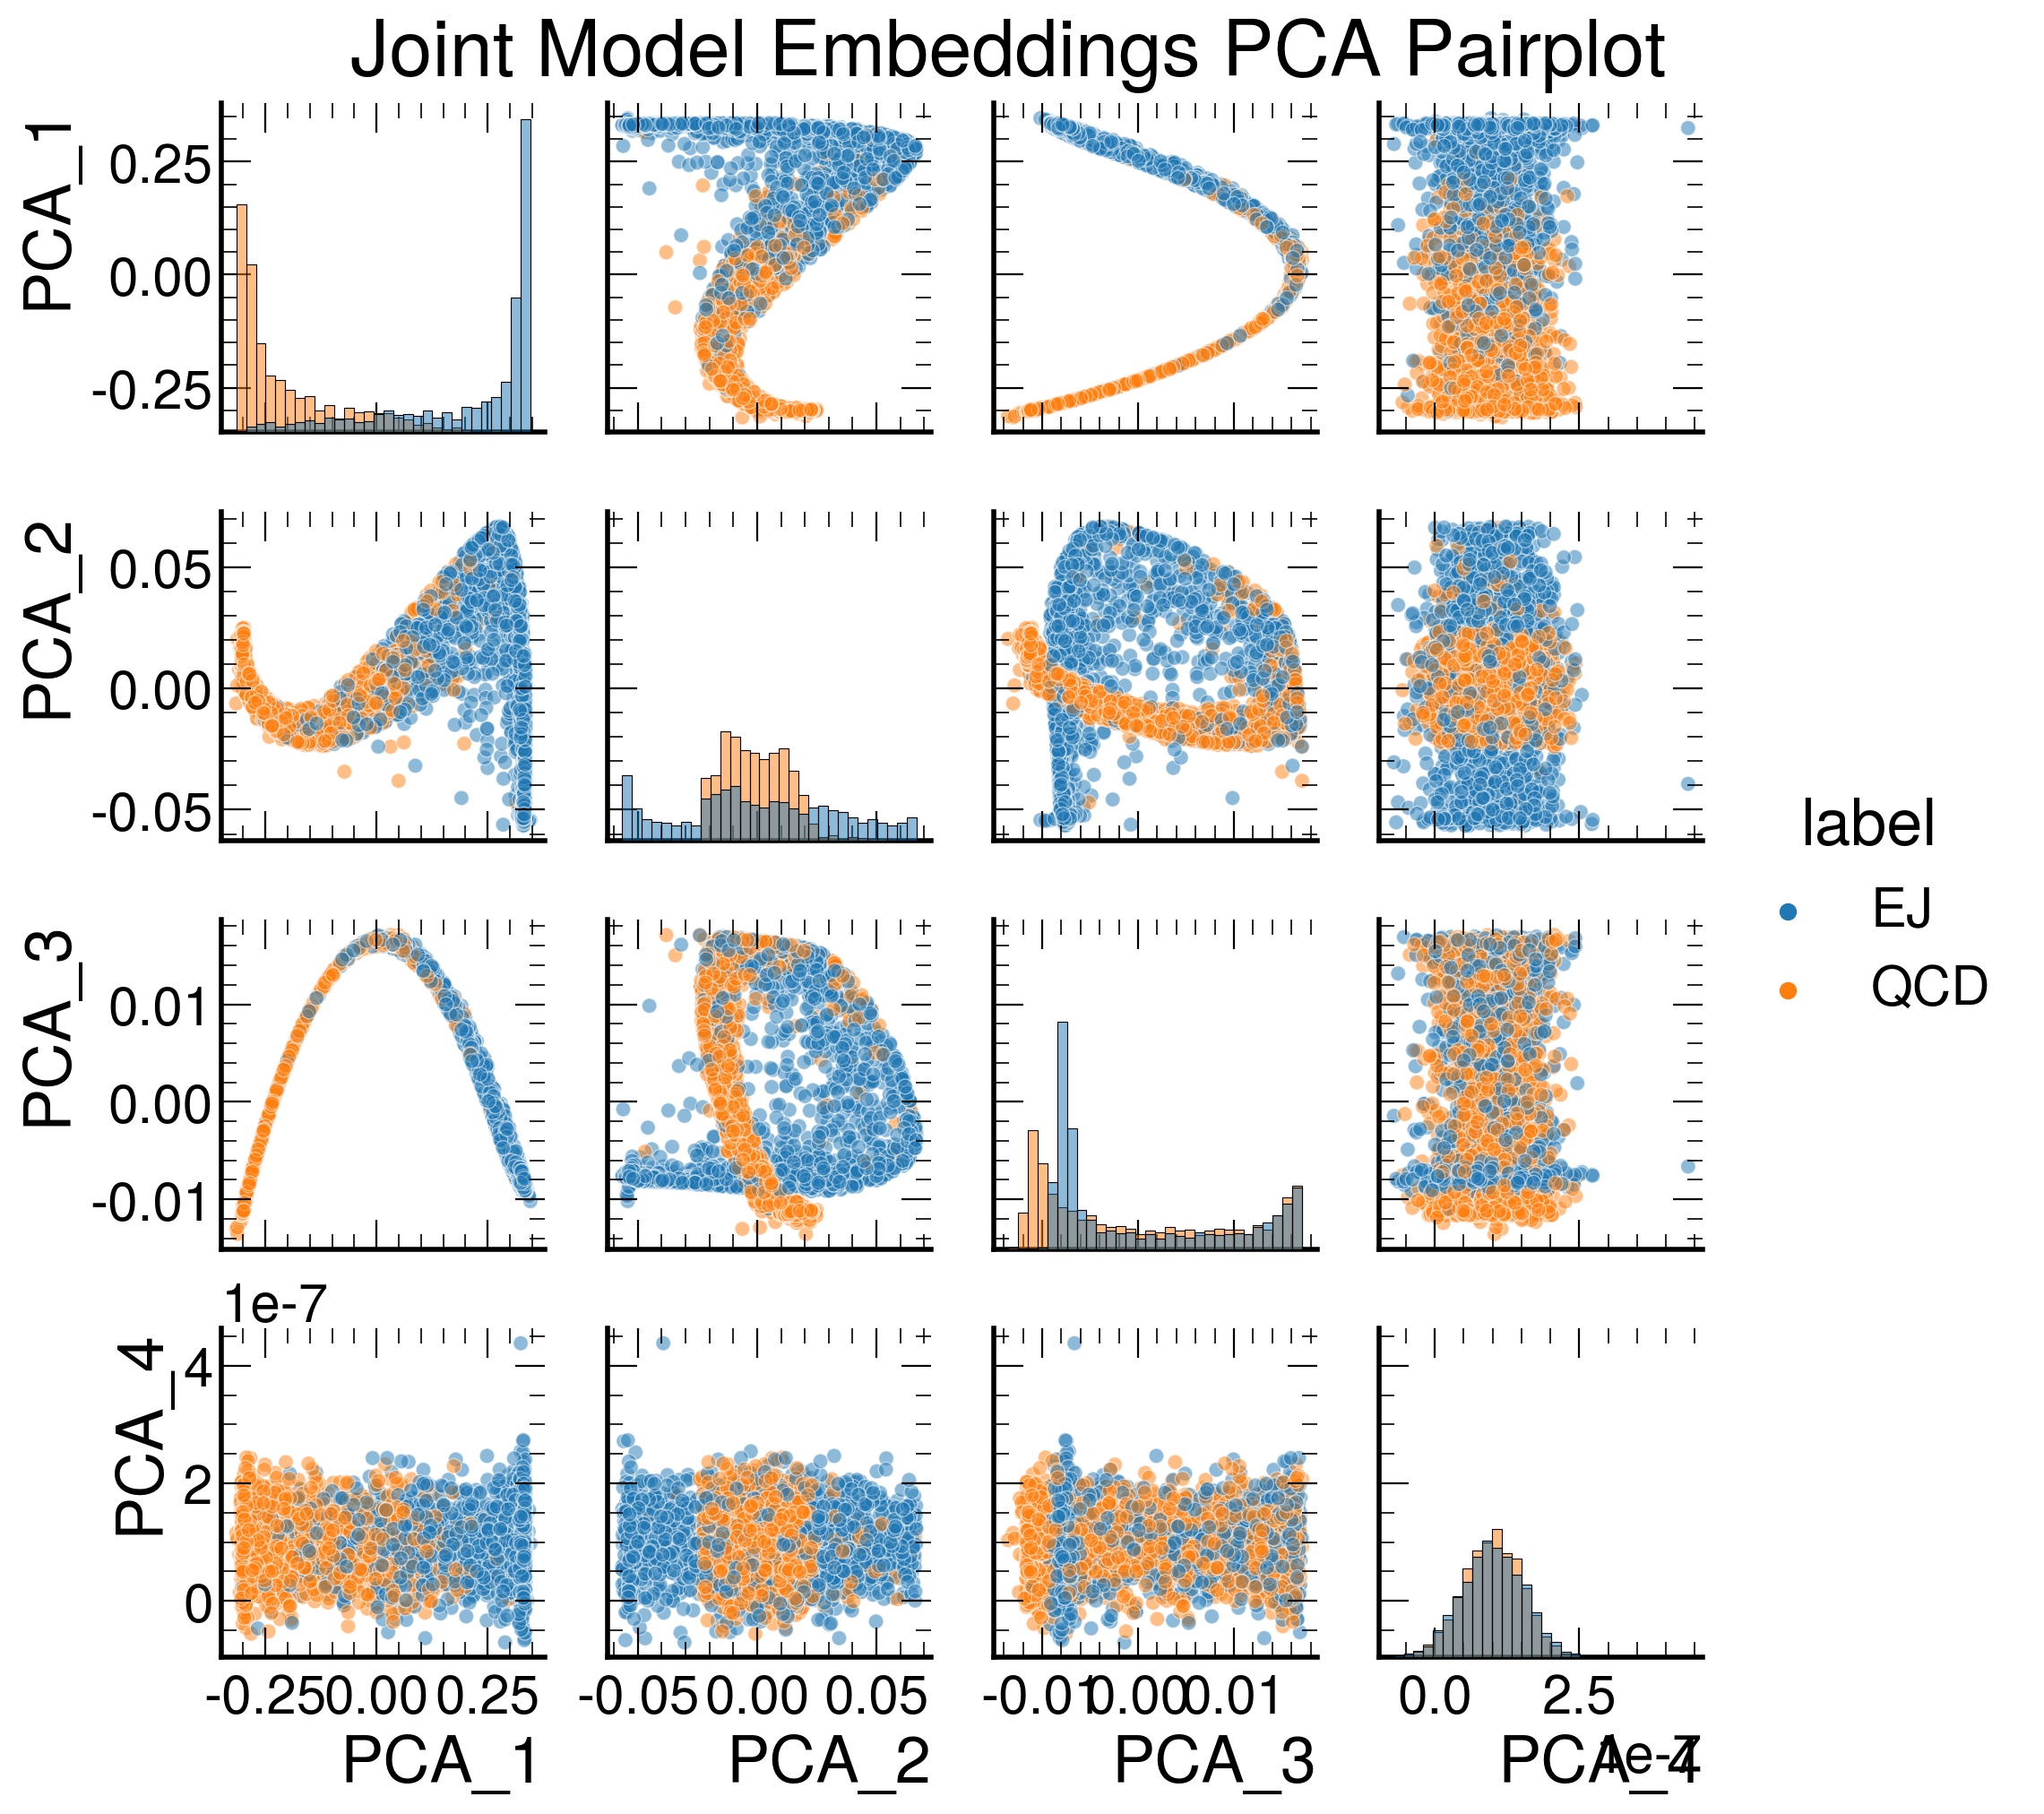

In [62]:
# SNS corner plot for joint model embeddings PCA
# Diagonal: histograms
# Off-diagonal: KDE
sns.pairplot(
    embeddings_joint_df,
    vars=["PCA_1", "PCA_2", "PCA_3", "PCA_4"],
    hue="label",
    diag_kind="hist",
    plot_kws={"alpha": 0.5},
    diag_kws={"bins": 30, "alpha": 0.5}
)
plt.suptitle("Joint Model Embeddings PCA Pairplot", y=1.02)
plt.show()

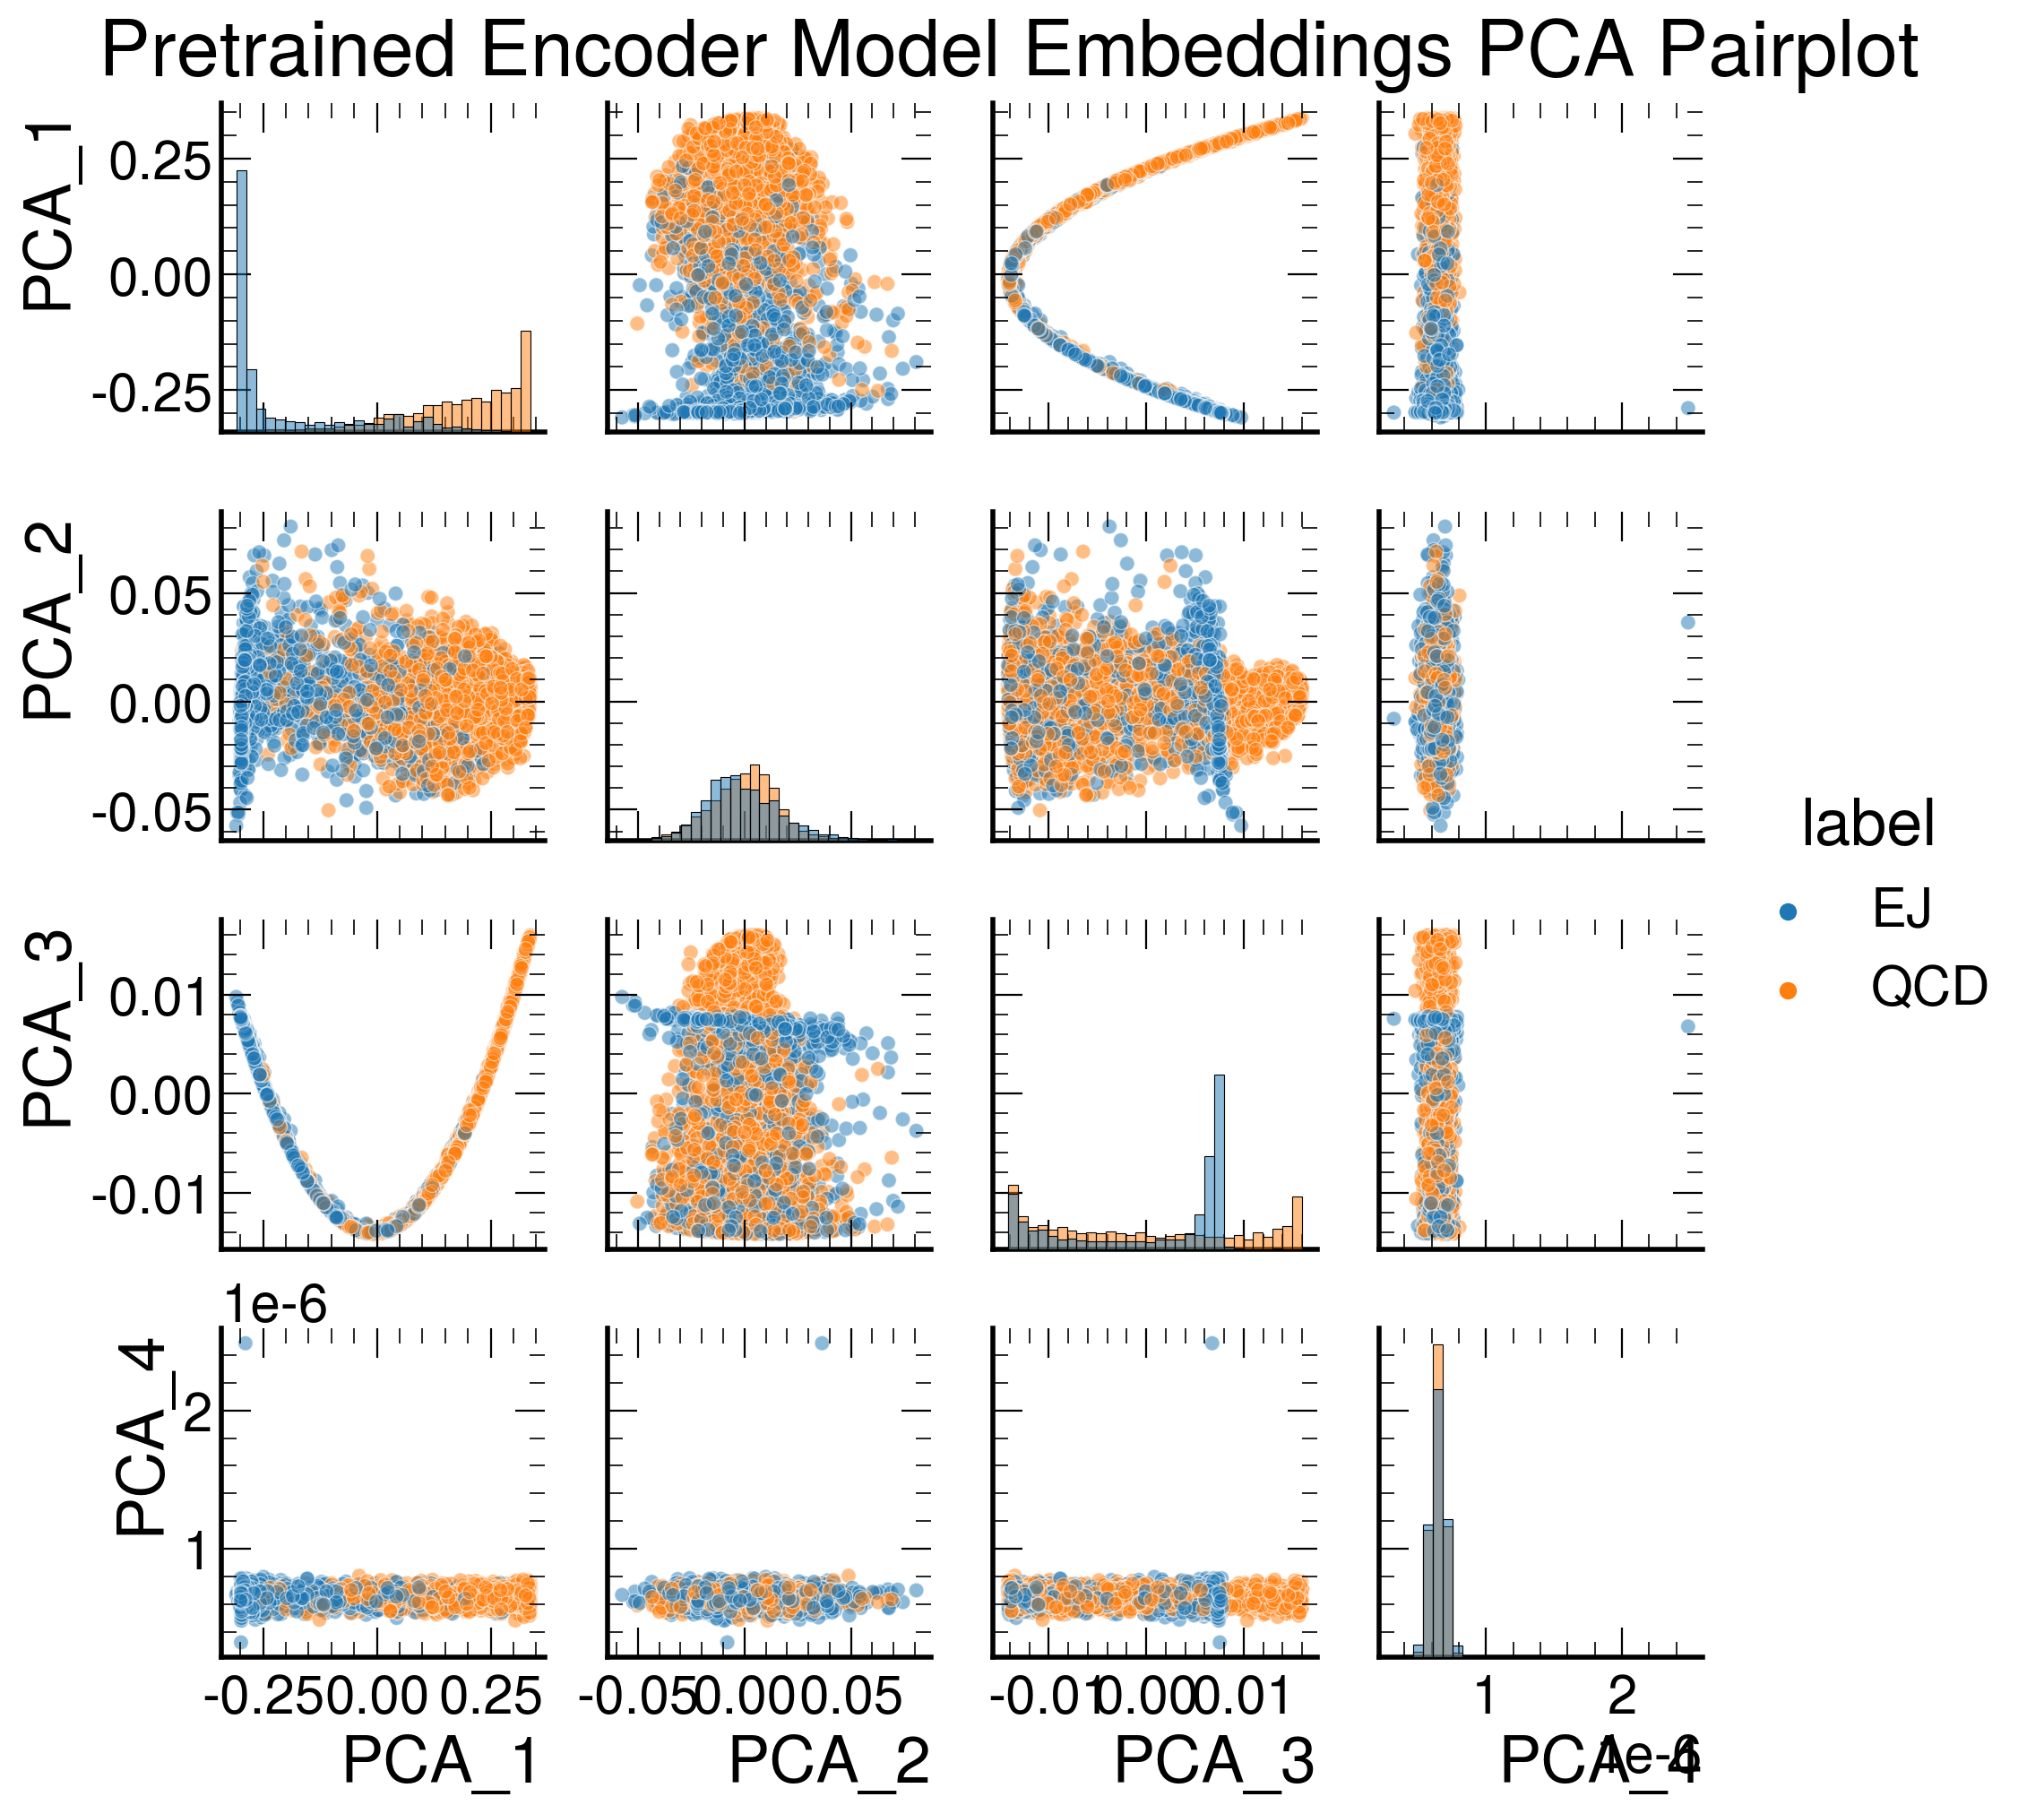

In [63]:
sns.pairplot(
    embeddings_pretr_df,
    vars=["PCA_1", "PCA_2", "PCA_3", "PCA_4"],
    hue="label",
    diag_kind="hist",
    plot_kws={"alpha": 0.5},
    diag_kws={"bins": 30, "alpha": 0.5}
)
plt.suptitle("Pretrained Encoder Model Embeddings PCA Pairplot", y=1.02)
plt.show()

ROC Curves

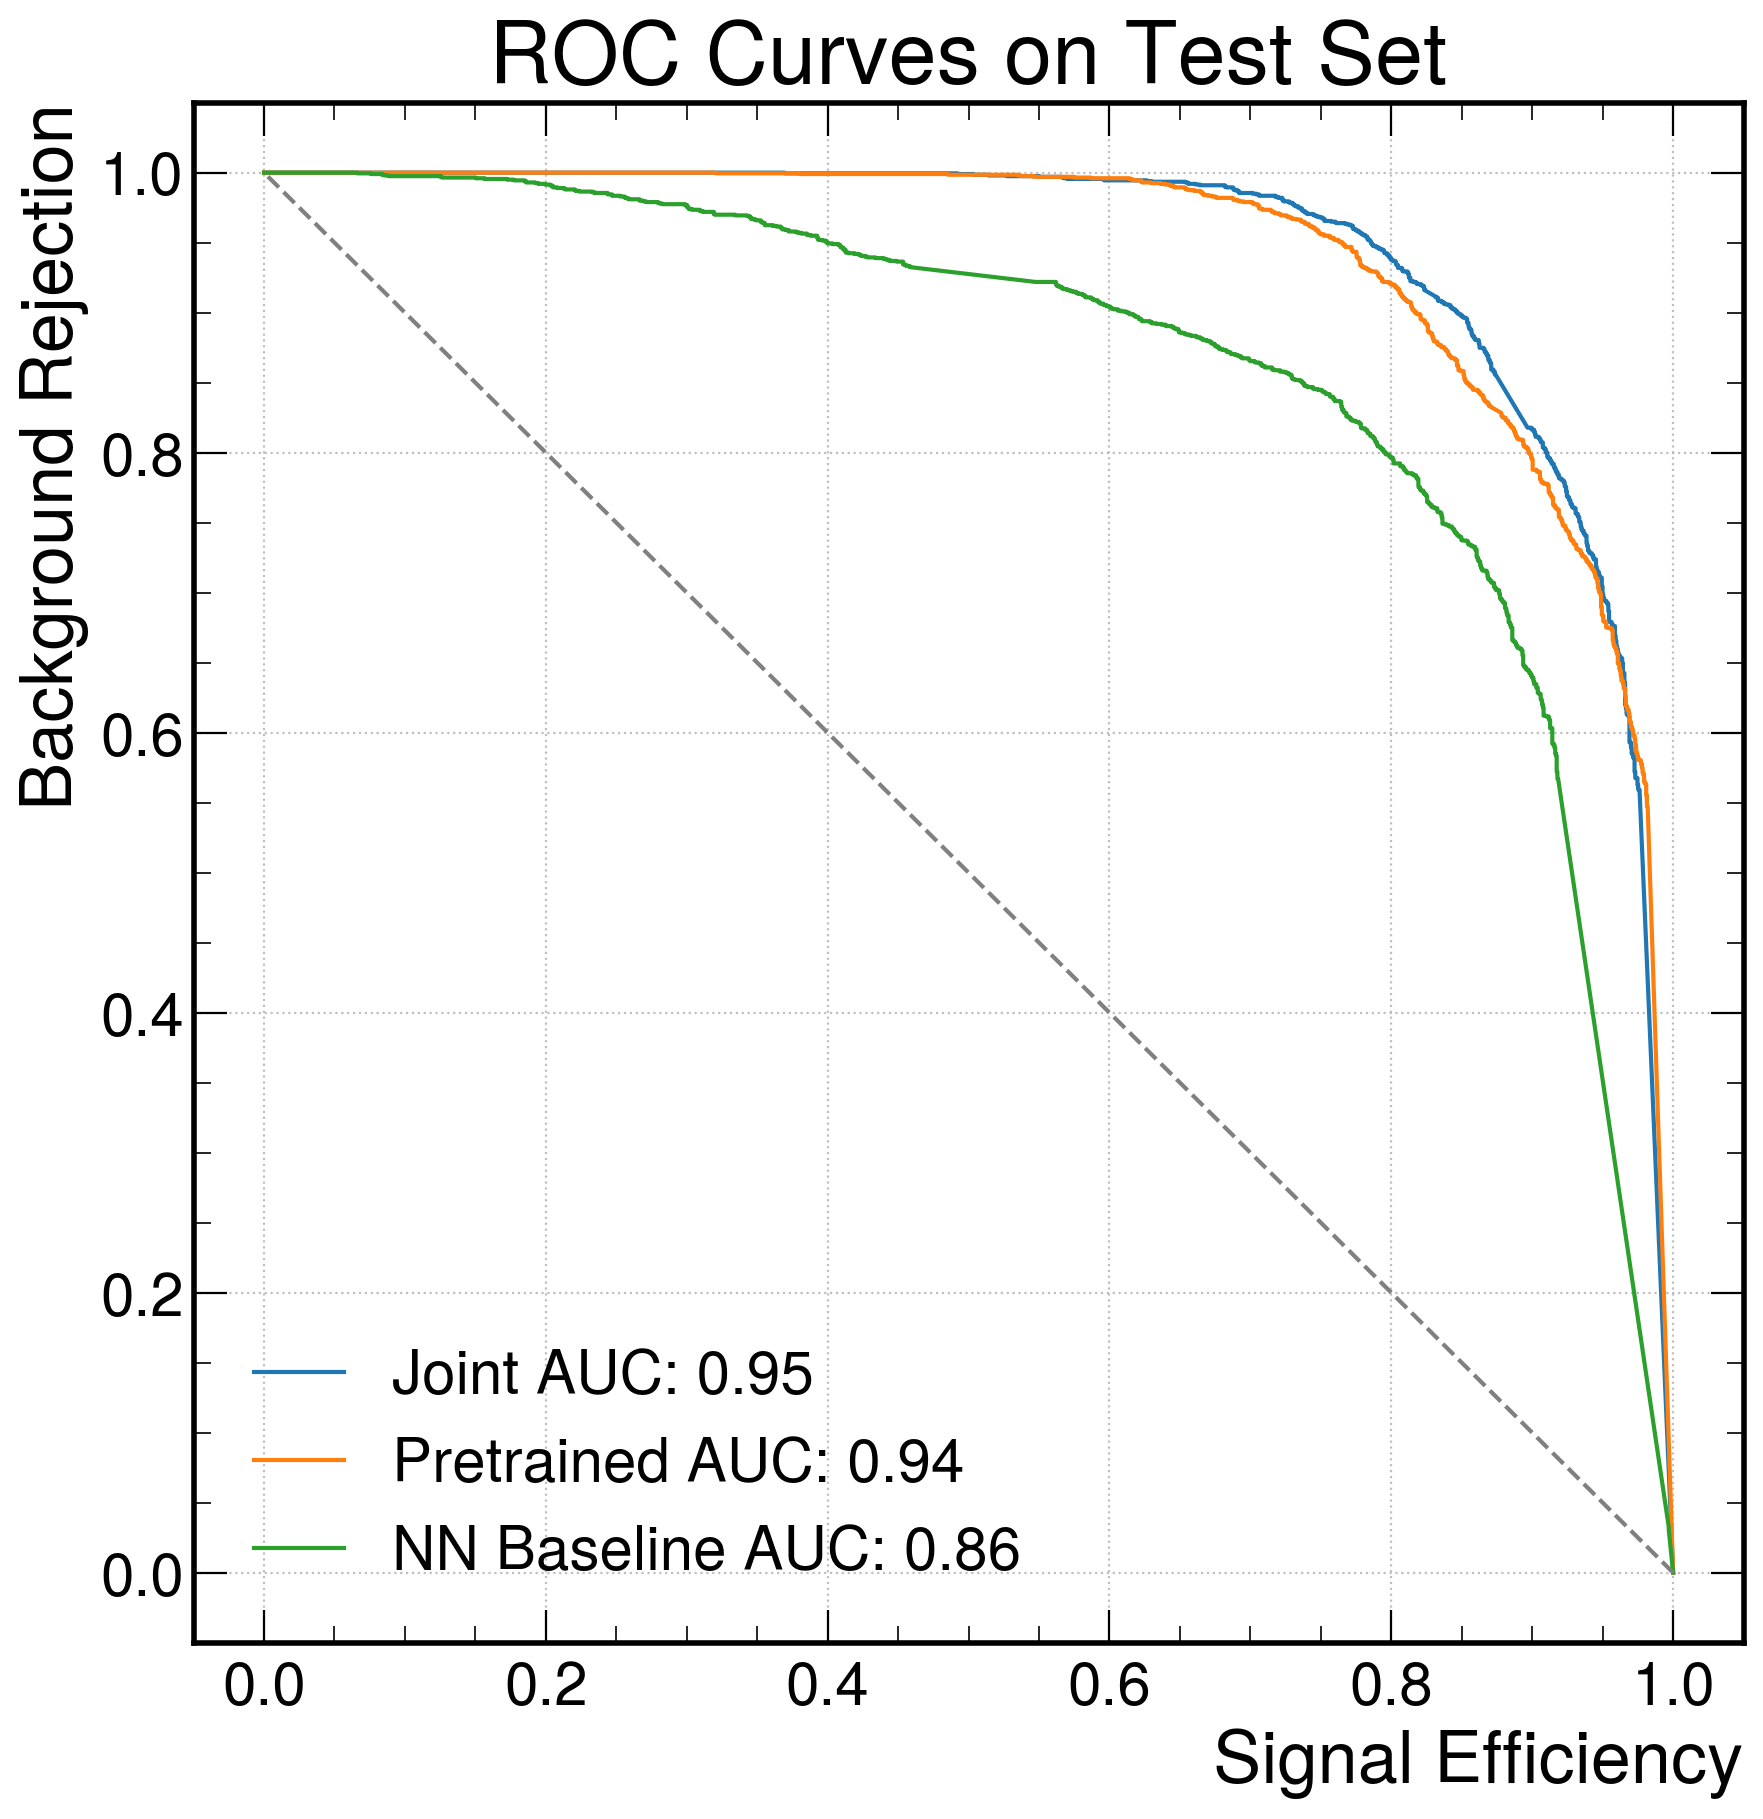

In [75]:
fpr_joint, tpr_joint, _ = roc_curve(labels_joint.numpy(), torch.sigmoid(logits_joint).squeeze().numpy())
fpr_pretr, tpr_pretr, _ = roc_curve(labels_pretr.numpy(), torch.sigmoid(logits_pretr).squeeze().numpy())
fpr_nn, tpr_nn, _ = roc_curve(labels_nn.numpy(), torch.sigmoid(logits_nn).squeeze().numpy())

auc_joint = auc(fpr_joint, tpr_joint)
auc_pretr = auc(fpr_pretr, tpr_pretr)
auc_nn = auc(fpr_nn, tpr_nn)

# Plot ROC curves
fig, ax = plt.subplots()
ax.plot(tpr_joint, 1 - fpr_joint, label=f"Joint AUC: {auc_joint:.2f}")
ax.plot(tpr_pretr, 1 - fpr_pretr, label=f"Pretrained AUC: {auc_pretr:.2f}")
ax.plot(tpr_nn, 1 - fpr_nn, label=f"NN Baseline AUC: {auc_nn:.2f}")
# Diagonal line
ax.plot([1, 0], [0, 1], linestyle="--", color="gray")
ax.set_xlabel("Signal Efficiency")
ax.set_ylabel("Background Rejection")
ax.set_title("ROC Curves on Test Set")
ax.legend()
ax.grid(True)
plt.show()

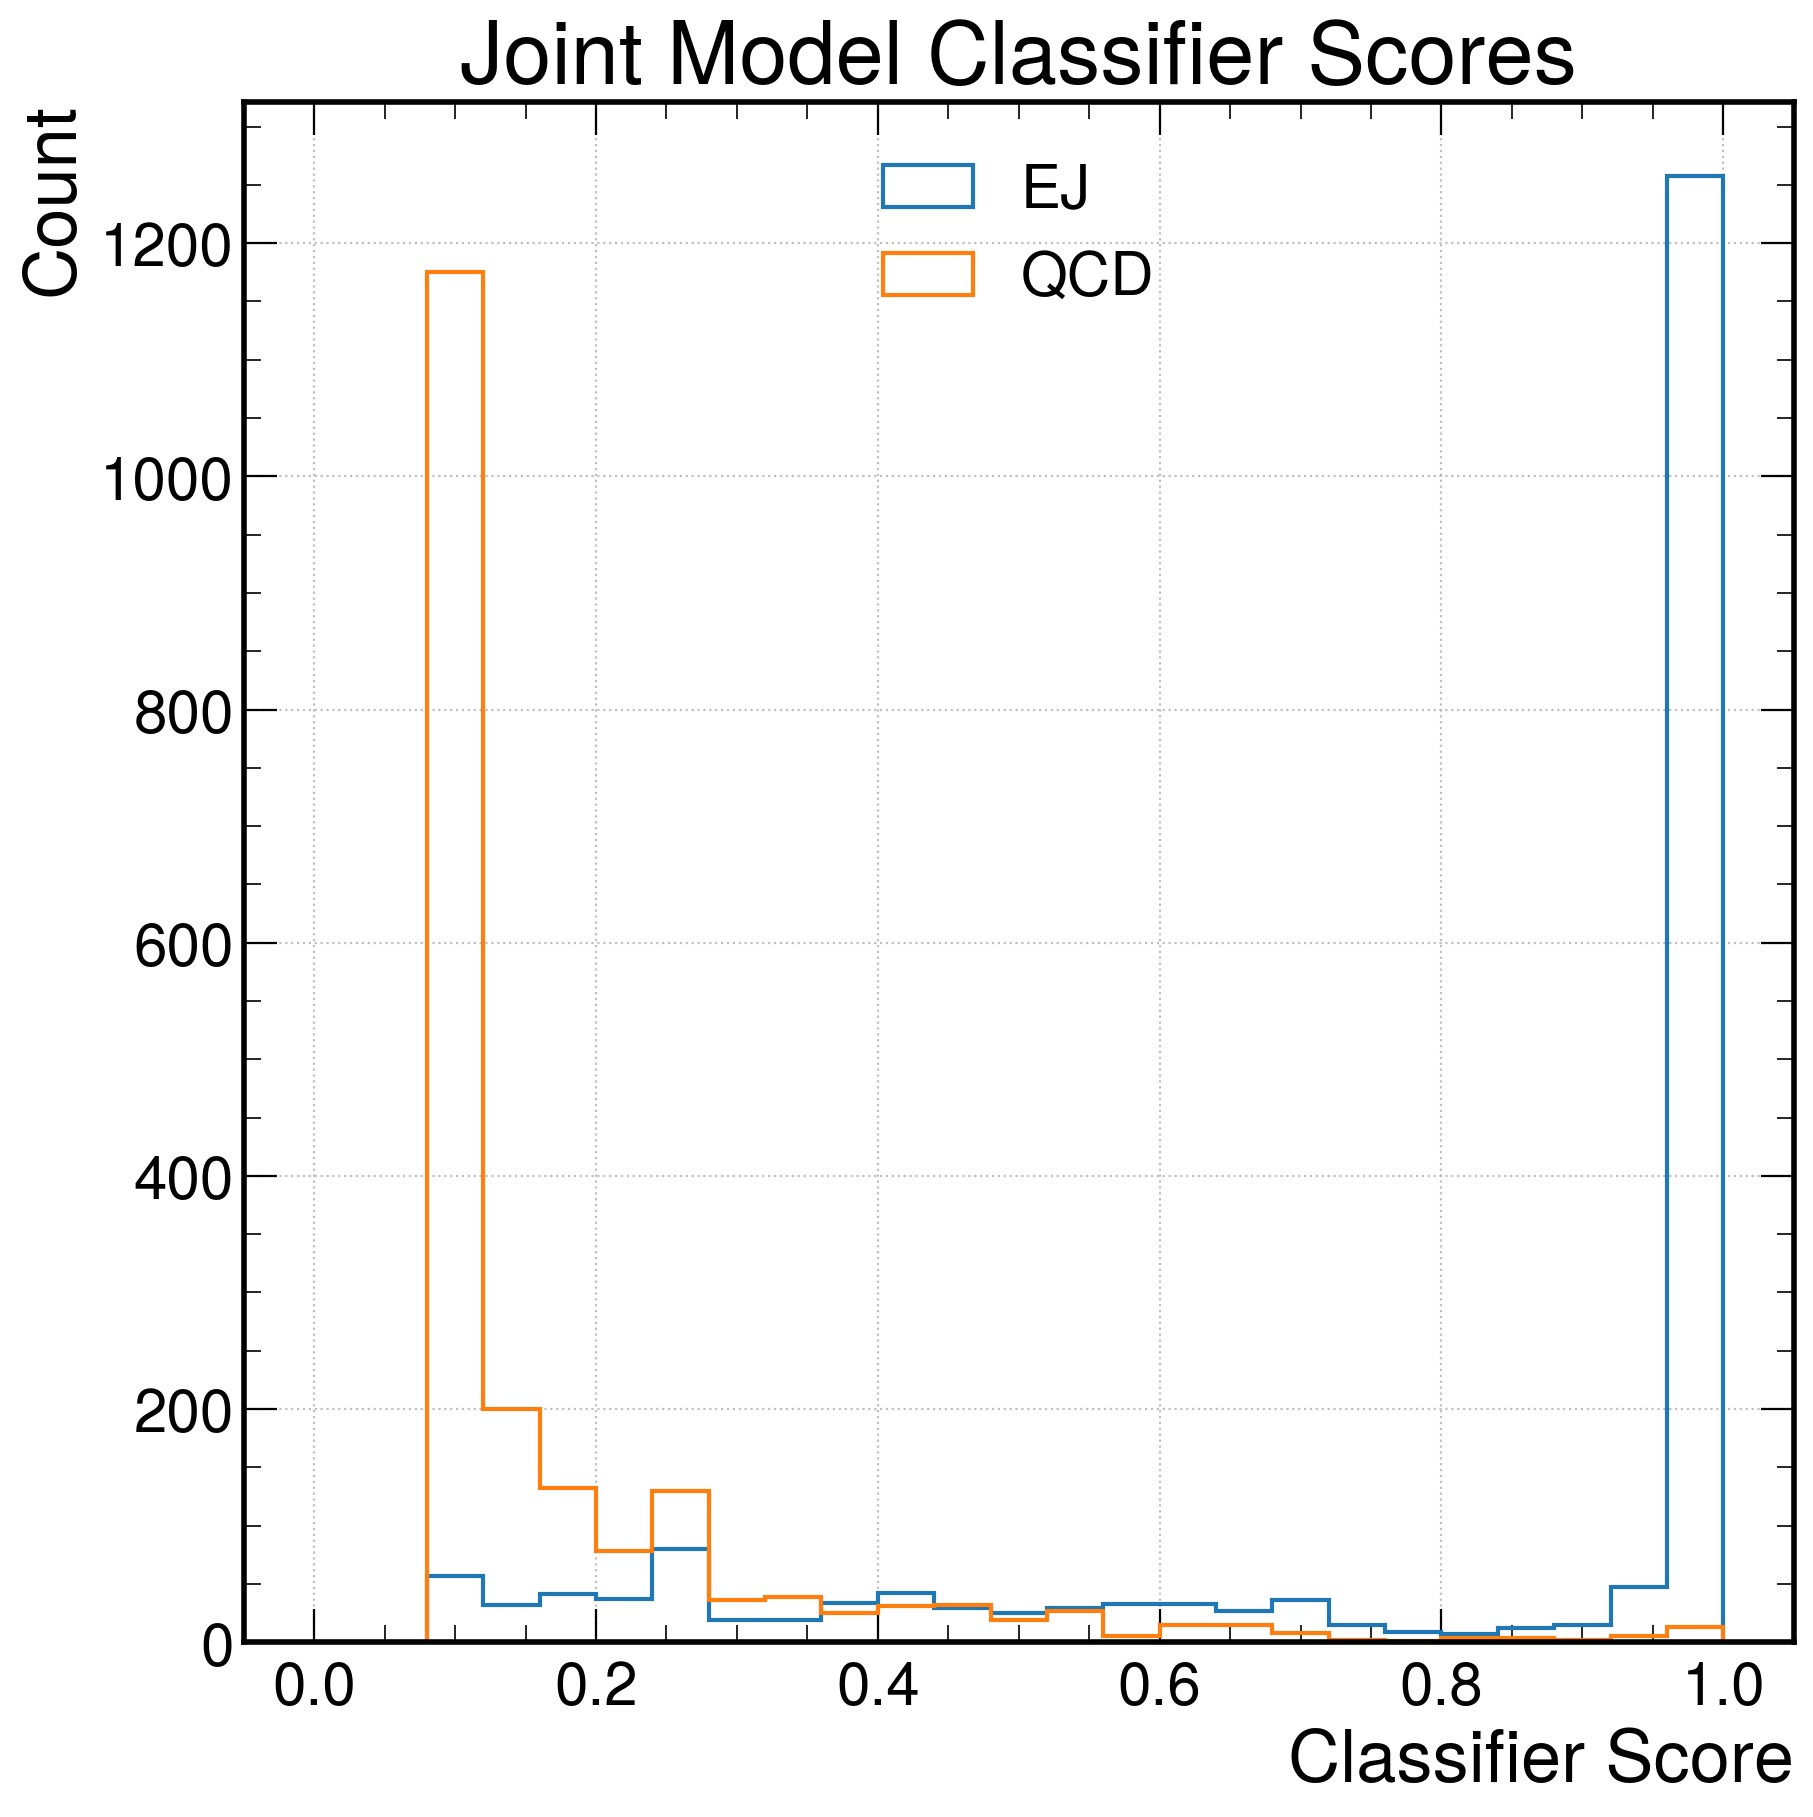

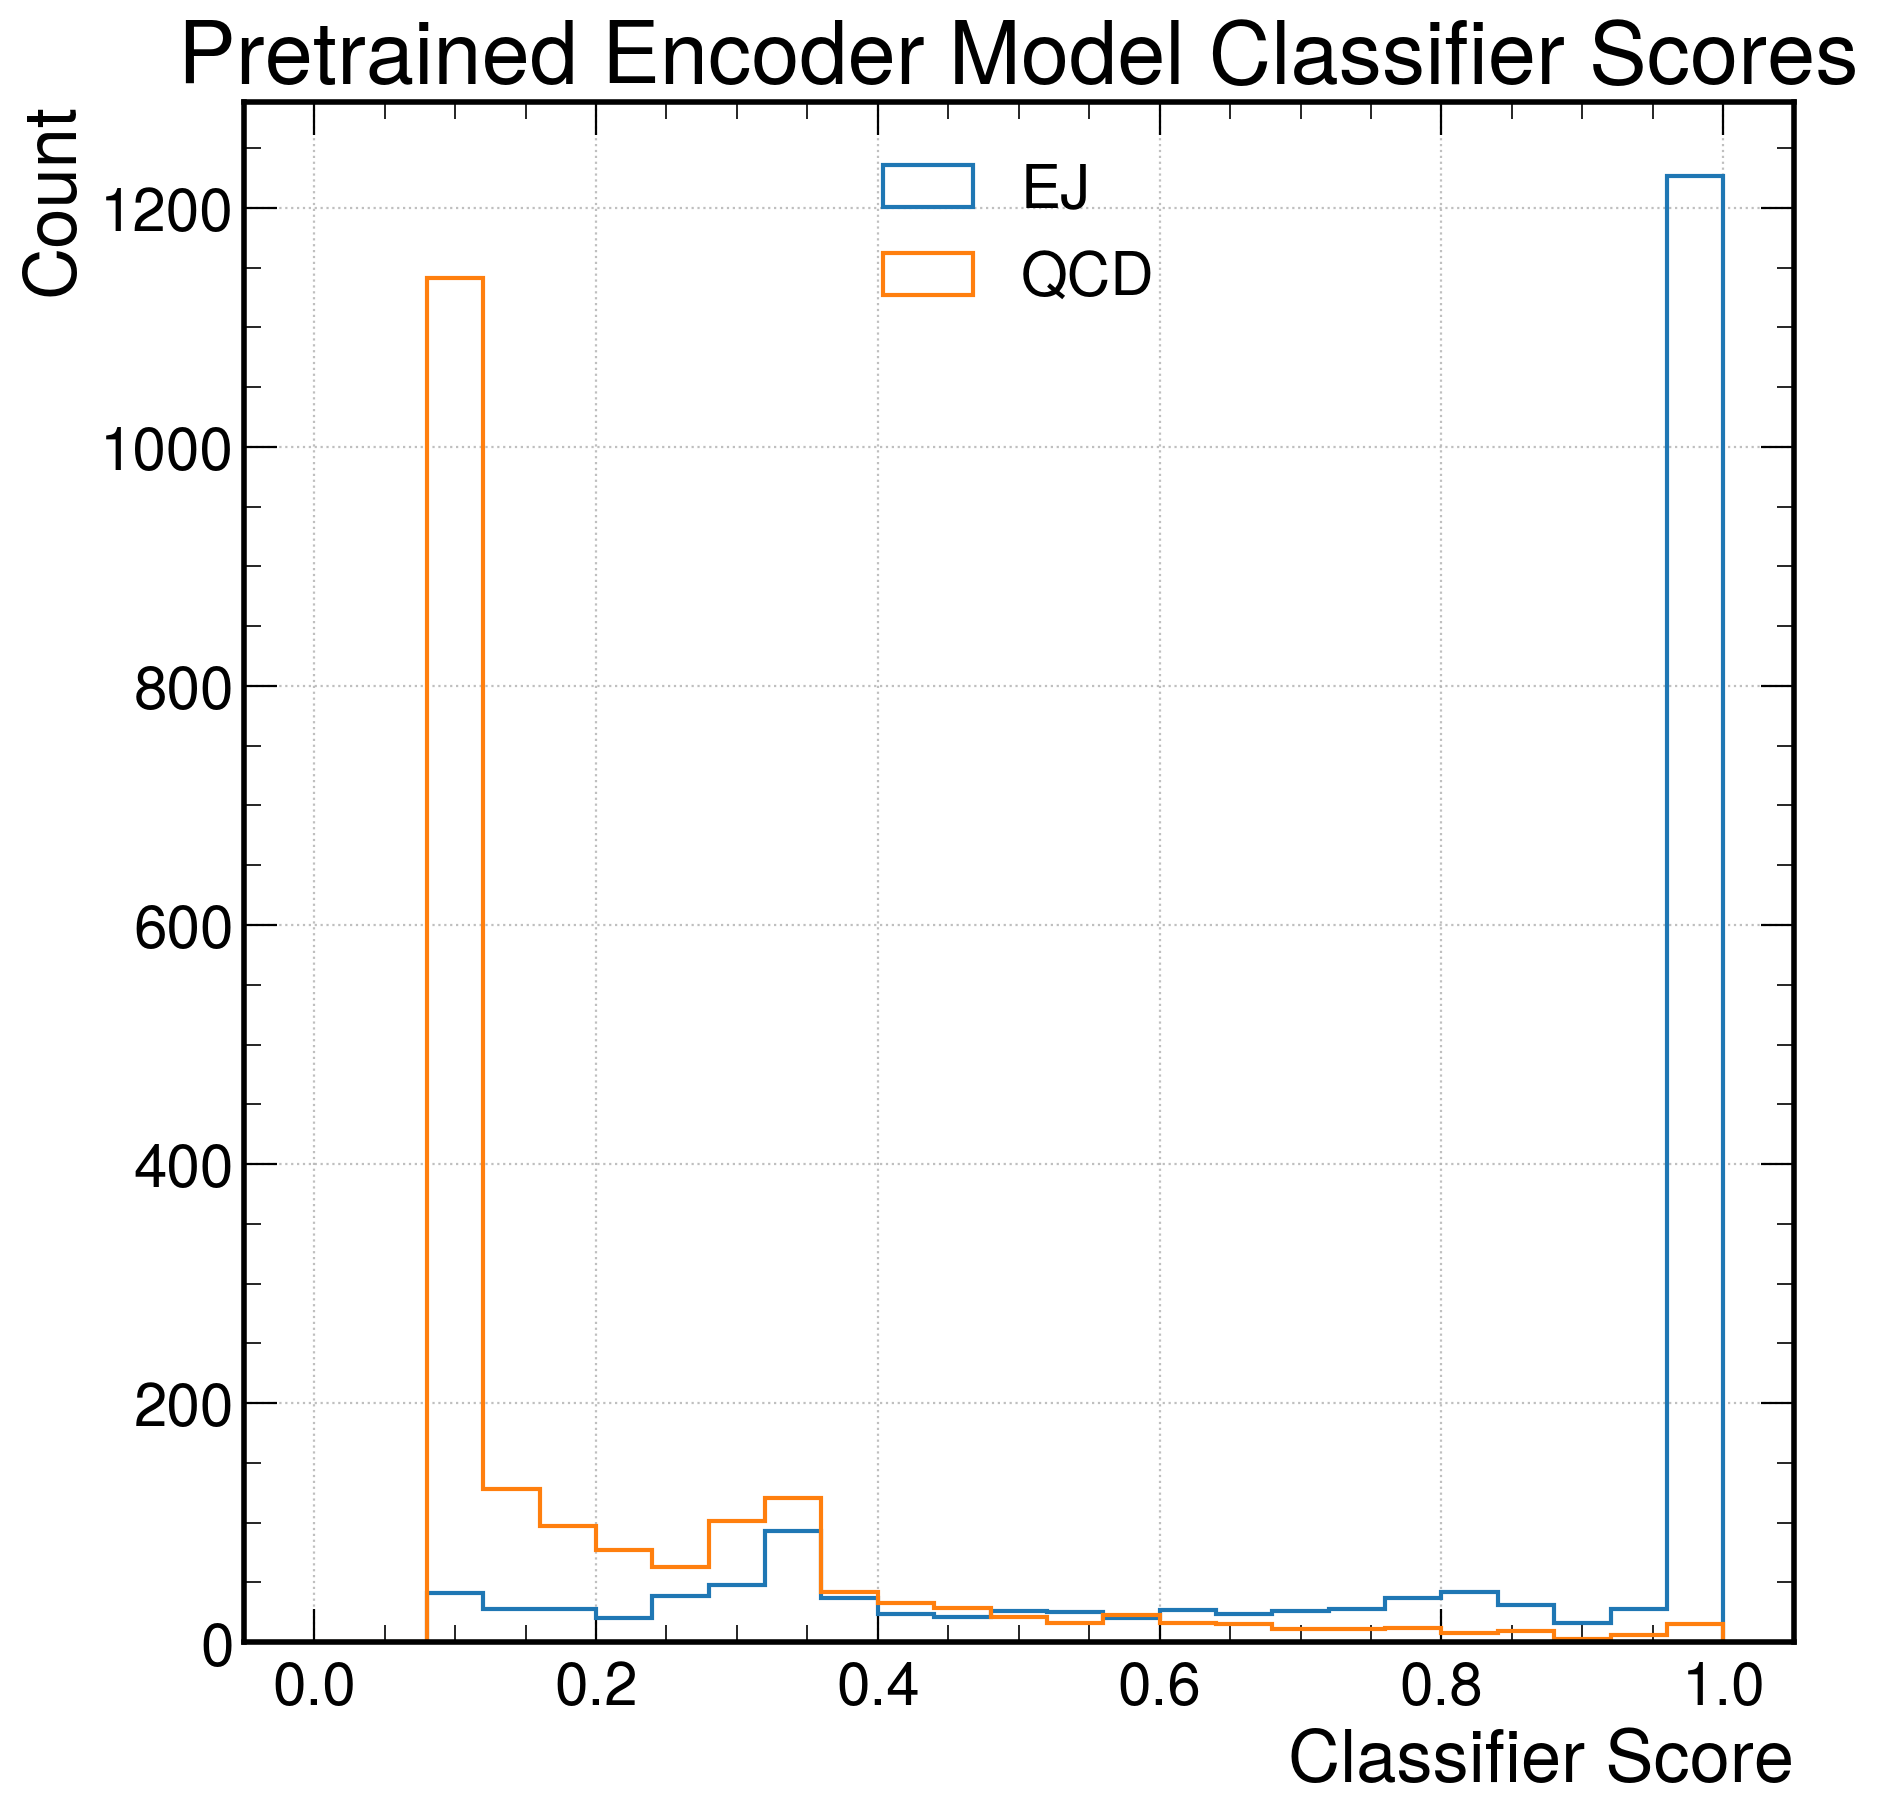

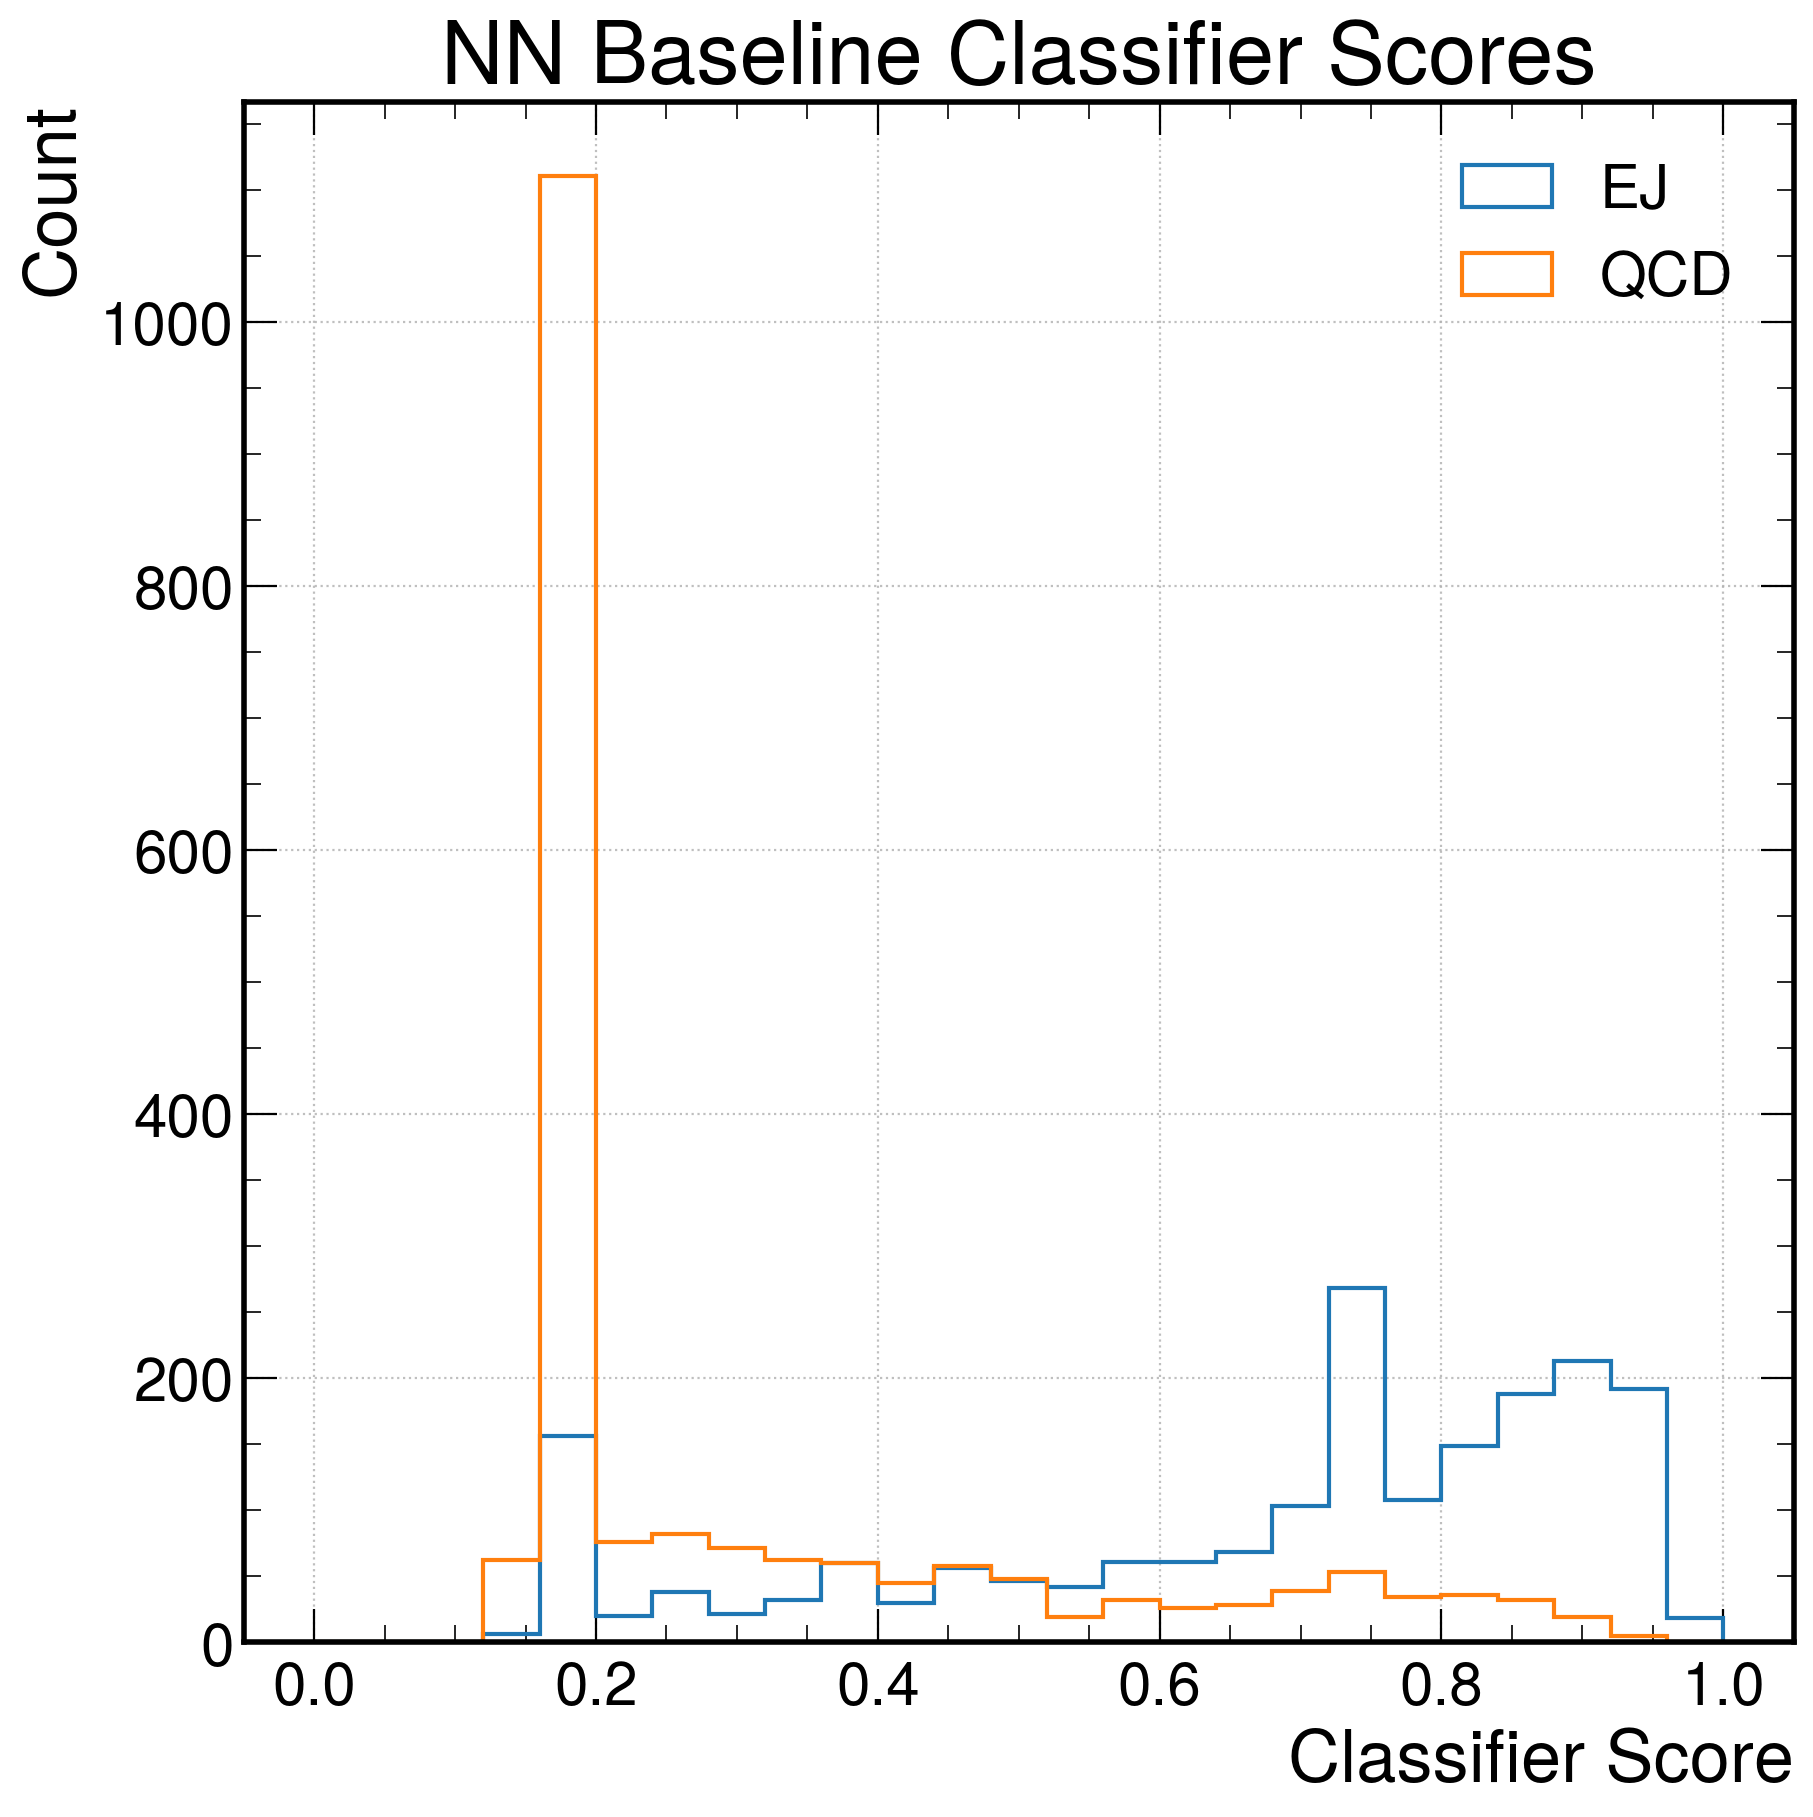

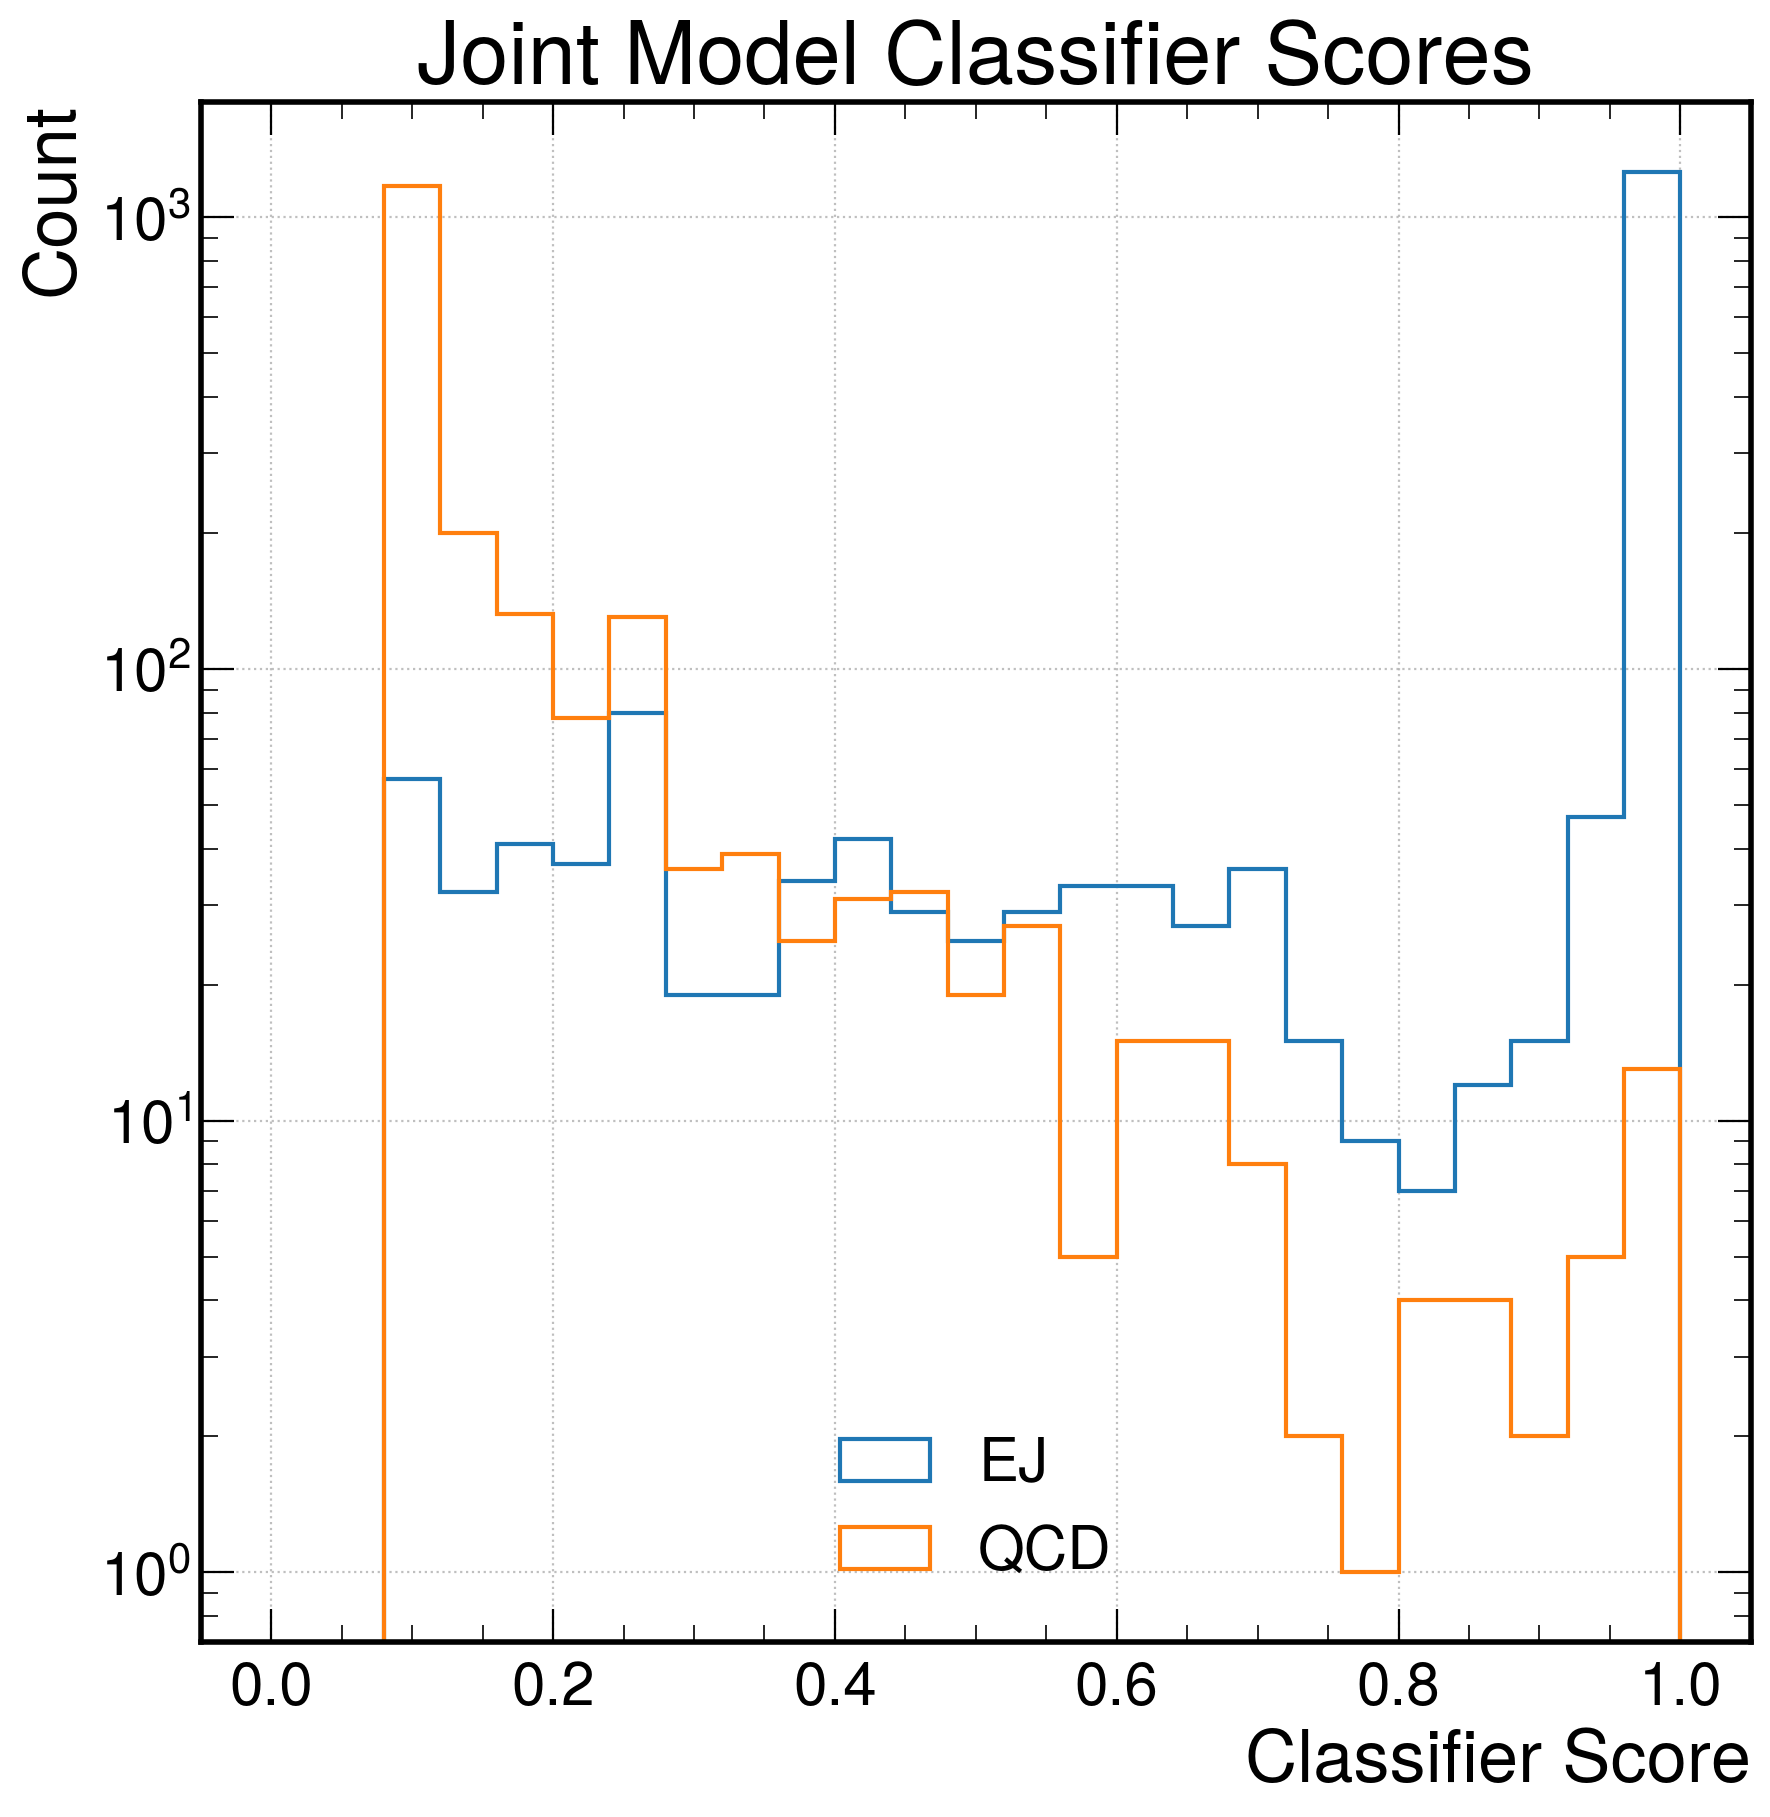

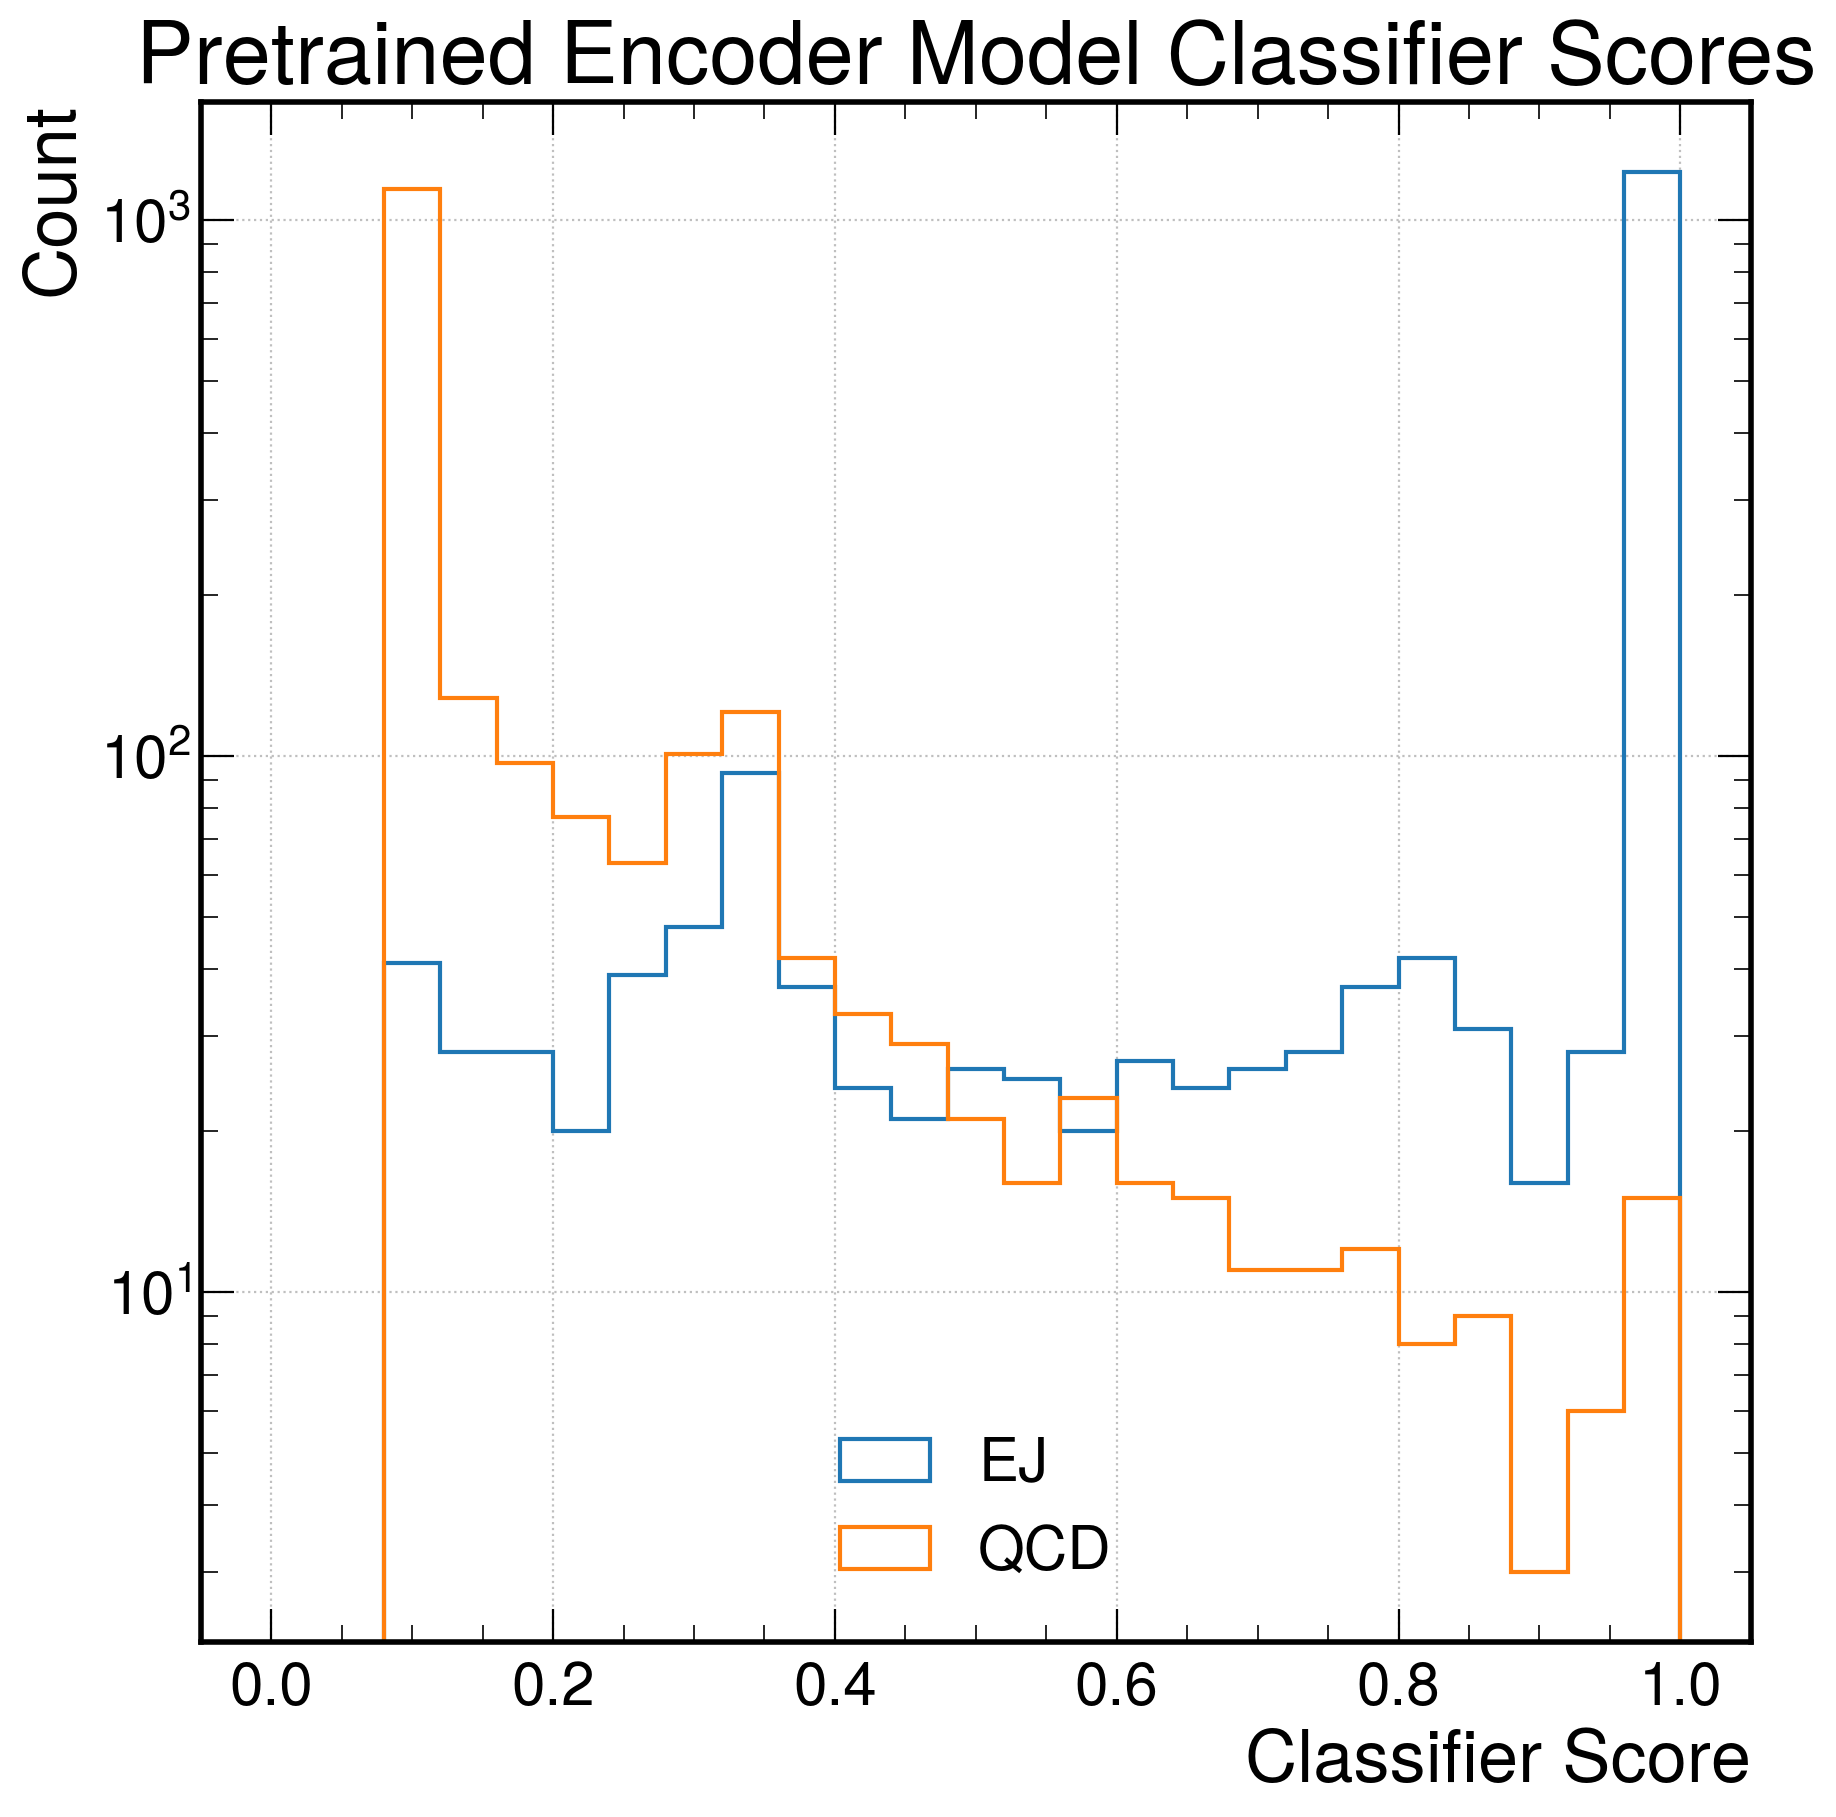

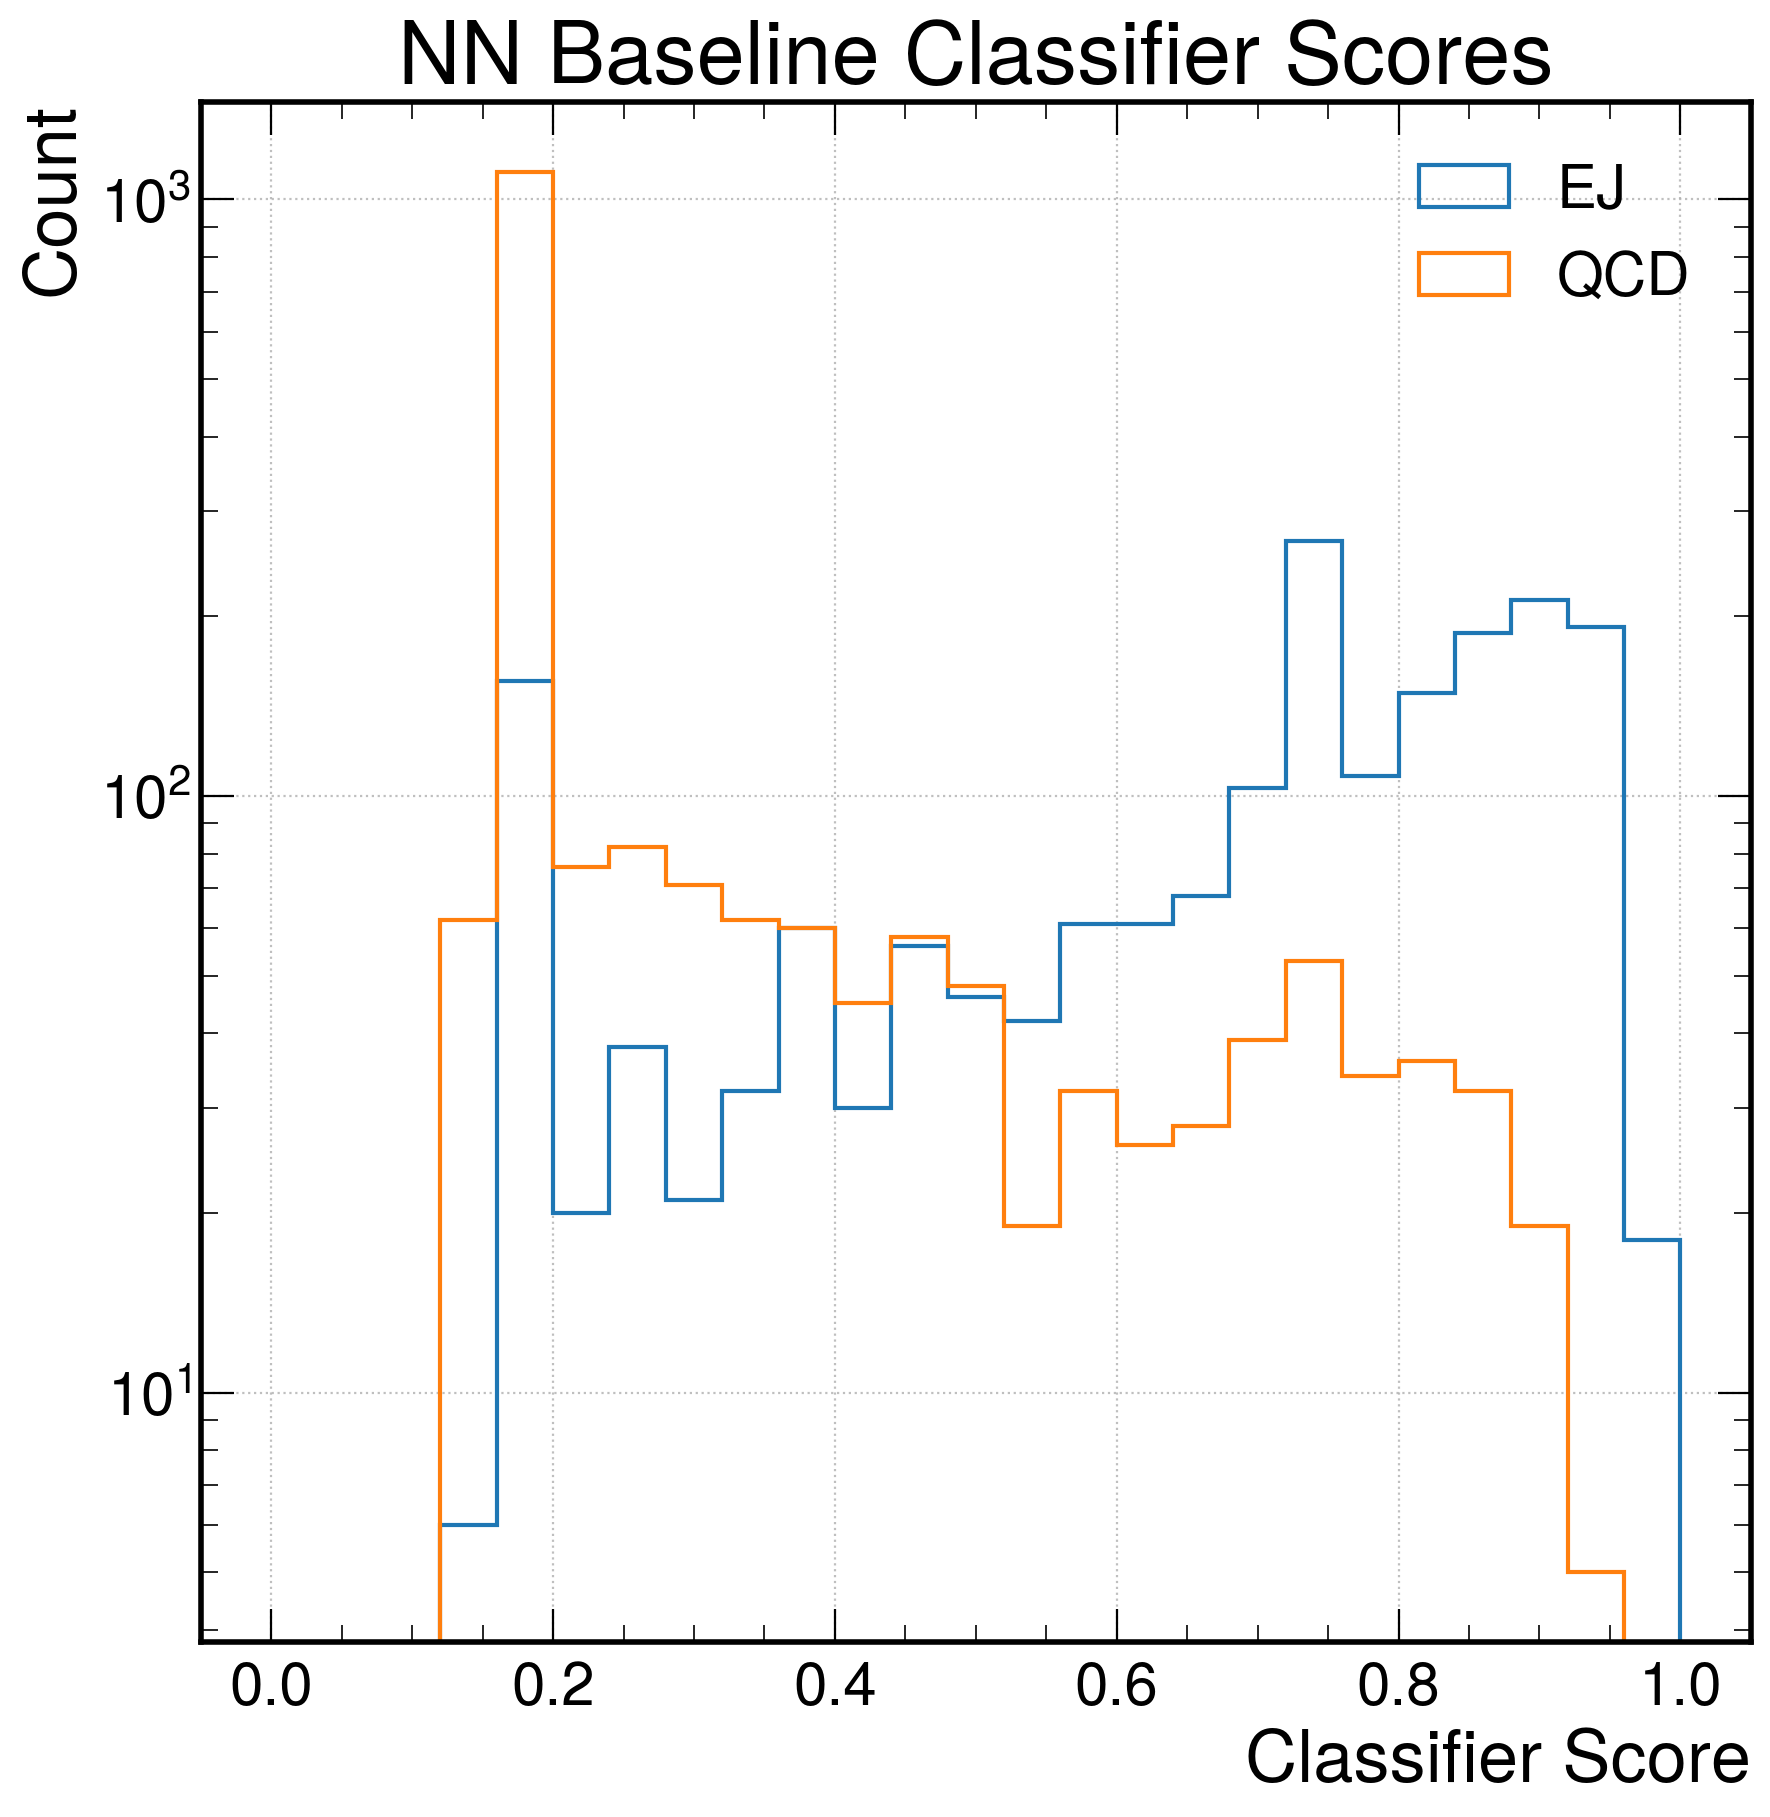

In [84]:
# Plot scores
def plot_scores(logits, labels, title, ylog=False, nbins=50):
    scores = torch.sigmoid(logits).squeeze().numpy()
    labels = labels.numpy()
    sig_scores = scores[labels == 1]
    bkg_scores = scores[labels == 0]

    fig, ax = plt.subplots()
    ax.hist(sig_scores, bins=nbins, range=(0, 1), density=False, label="EJ", histtype="step", linewidth=1.5)
    ax.hist(bkg_scores, bins=nbins, range=(0, 1), density=False, label="QCD", histtype="step", linewidth=1.5)
    ax.set_title(title)
    ax.set_xlabel("Classifier Score")
    ax.set_ylabel("Count")
    ax.set_yscale('log' if ylog else 'linear')
    ax.legend()
    ax.grid(True)
    plt.show()

plot_scores(logits_joint, labels_joint, "Joint Model Classifier Scores", nbins=25)
plot_scores(logits_pretr, labels_pretr, "Pretrained Encoder Model Classifier Scores", nbins=25)
plot_scores(logits_nn, labels_nn, "NN Baseline Classifier Scores", nbins=25)

plot_scores(logits_joint, labels_joint, "Joint Model Classifier Scores", ylog=True, nbins=25)
plot_scores(logits_pretr, labels_pretr, "Pretrained Encoder Model Classifier Scores", ylog=True, nbins=25)
plot_scores(logits_nn, labels_nn, "NN Baseline Classifier Scores", ylog=True, nbins=25)